# CarND Andvanced Lane Lines
this project goal is 
> 
 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
 2. Apply a distortion correction to raw images.
 3. Use color transforms, gradients, etc., to create a thresholded binary image.
 4. Apply a perspective transform to rectify binary image ("birds-eye view").
 5. Detect lane pixels and fit to find the lane boundary.
 6. Determine the curvature of the lane and vehicle position with respect to center.
 7. Warp the detected lane boundaries back onto the original image.
 8. Output visual display of the lane boundaries and numerical

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"
## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

###Camera Calibration

####1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.
The code for this is showed blow.
first I used image_list to stored the loaded images which path is  "./camera_cal/".And I also create a image_gray_list to store the gray image.
I created the 'obj_points' which will be the (x, y, z) coordinates of the chessboard corners in the world. and it will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.
I created the 'img_points' which will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I get 'obj_points and img_points'  to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result.
the result is blow the code ,in the code output

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline
#%matplotlib qt
import os
#defint value
nx = 9 # number of inside cornets in x
ny = 6  # number of inside corners in y
camera_cal_path = "./camera_cal/"
#load data
image_list = []
file_list = os.listdir(camera_cal_path)
image = cv2.imread(file_list[0])
for file in file_list:
    image_list.append(cv2.imread(camera_cal_path+file))
# gray the image 
image_gray_list = []
for image in image_list:
    image_gray_list.append(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY))
 # calibrate Camera effiecients
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2]= np.mgrid[0:nx,0:ny].T.reshape(-1,2)
img_points = []
obj_points = []
for gray in image_gray_list:
    ret,corners = cv2.findChessboardCorners(gray,(nx,ny),None)
    if ret:
            img_points.append(corners)
            obj_points.append(objp)
ret,mtx,dist,revcs,tvecs = cv2.calibrateCamera(obj_points,img_points,image_gray_list[0].shape[::-1],None,None)


## ###Pipeline (single images)

####1. Provide an example of a distortion-corrected image.
the undistored image is showed in code output.one is calibarate image which is chessboard,other is test image.

ORIGIN IMAGE


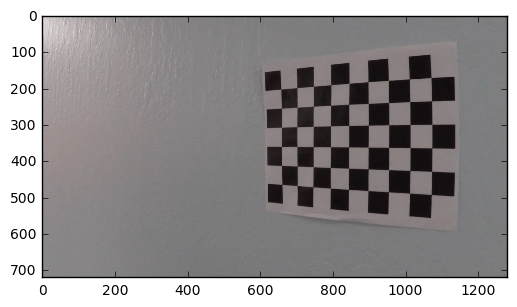

UNDISTORTED IMAGE


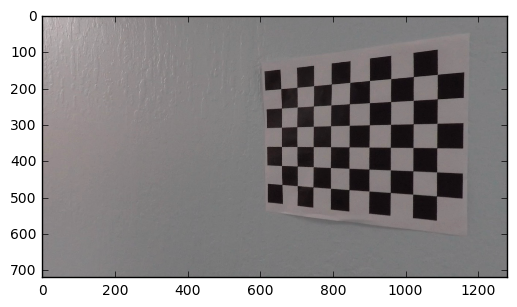

In [2]:
%matplotlib inline

# undistort the image
def getUndistortImage(img):
    undistort = cv2.undistort(img,mtx,dist,None,mtx)
    return undistort
img = image_list[0]
print("ORIGIN IMAGE")
plt.imshow(img)
plt.show()
print("UNDISTORTED IMAGE")
img = getUndistortImage(img)
plt.imshow(img)
plt.show()



origin image


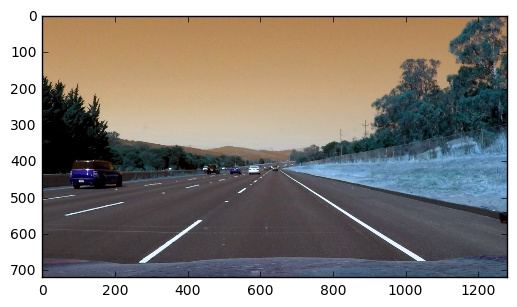

UNDISTORTED IMAGE


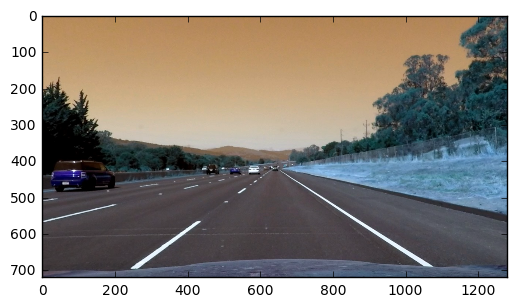

In [3]:
#%matplotlib qt
# read image
#img = cv2.imread("./test_images/test4.jpg")
img = cv2.imread("./test_images/straight_lines2.jpg")
img_size = img.shape[::-1]
print("origin image")
plt.imshow(img)
plt.show()
undistorted_img = getUndistortImage(img)
print("UNDISTORTED IMAGE")
plt.imshow(undistorted_img)
plt.show()

####2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)
before gradient the image ,I convert the image to gray.
and I write a mag_thresh function to gradient the image,the sobel_kernel =15, mag_thresh=(60, 255),tan_thresh = (0.7, 1.3))
I used tan_thresh to select the tan_Sobel = np.arctan2(np.absolute(sobelY),np.absolute( sobelX)) value.In this function ,Ireturned the binary which mag_binary==1 & arctan_binary == 1.
The code is blow in line 135 -191 in function mag_thresh
for the color selection,I converted the image to hls image ,and I used the s channel to selected the binary result.
The code is blow in line 192-206 in function hls_thresh
Last I combination of color and gradient thresholds to generate a binary.
The code is blow in line 210-234 the combination is in imgMagAndhlsFilter(image) function.
and the result is in the code output,title is Mag And HLS Filtered Image



In [4]:
def mag_thresh(image,sobel_kernel =3,mag_thresh =(0,255),tan_thresh = (0, np.pi/2),
x_thresh= (0,255),y_thresh = (0,255),is_color_image = False):
    # Apply the following steps to img
    # 1) Convert to grayscale
        
    #print("SHOW GRAY IMAGE")
    #plt.imshow(gray,'gray')
    #plt.show()
    # 2) Take the gradient in x and y separately
    sobelX = cv2.Sobel(image,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobelY = cv2.Sobel(image,cv2.CV_64F,0,1,ksize = sobel_kernel)
    abs_SobelX = np.absolute(sobelX)
    abs_SobelY = np.absolute(sobelY)
    # 3) Calculate the magnitude 
    gradmag = np.sqrt(sobelX**2 + sobelY**2)
    tan_Sobel = np.arctan2(np.absolute(sobelY),np.absolute( sobelX))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    #scaled_sobel = np.uint8(gradmag/scale_factor)
    scaled_sobel = (gradmag/scale_factor).astype(np.uint8)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobelX)
    abs_sobely = np.absolute(sobelY)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
                             
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    mag_binary = np.zeros_like(scaled_sobel)
    sobelx_binary = np.zeros_like(scaled_sobelx)
    sobely_binary = np.zeros_like(scaled_sobely)
    arctan_binary = np.zeros_like(tan_Sobel)

    mag_binary[(scaled_sobel>= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    #plt.imshow(mag_binary,'gray')
    #plt.show()
    
    #sobelx_binary[(scaled_sobelx >=200) & (scaled_sobelx <= 255)] = 1
    #plt.imshow(sobelx_binary,'gray')
    #plt.show()
    # didnot use
    #sobely_binary[(scaled_sobely >= 20) & (scaled_sobely <= 40)] = 1
    #plt.imshow(sobely_binary,'gray')
    #plt.show()
    arctan_binary[(tan_Sobel>= tan_thresh[0]) & (tan_Sobel <= tan_thresh[1])] = 1
    # plt.imshow(arctan_binary,'gray')
    # plt.show()
    binary_output[(mag_binary==1) & (arctan_binary == 1) ] = 1
    # plt.imshow(binary_output,'gray')
    # plt.show()
    #binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])
    #& (scaled_sobely >20) & (scaled_sobely <=100)]= 1
    # 
    return binary_output
#& (tan_Sobel >= tan_thresh[0]) & (tan_Sobel <= tan_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #@return binary_output
def hls_thresh(image,color_thresh = (0,255)):
    # Convert the Image 2 HLS
    hlsimage = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    # Get the sChannel
    s_channel = hlsimage[:,:,2]
    s_binary = np.zeros_like(s_channel)
    # Flitter the Image with color Schannel
    s_binary[(s_channel > color_thresh[0]) &(s_channel <= color_thresh[1] ) ] = 1
    return s_binary
# mag_binary = mag_thresh(undistorted_image, sobel_kernel=5, mag_thresh=(120, 200),tan_thresh = (0.7, 1.3),x_thresh=(100,101),y_thresh=(200,255))

Mag And HLS Filtered Image


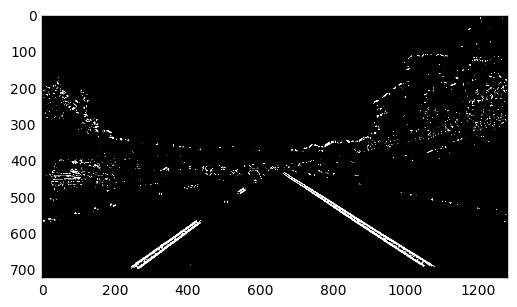

In [5]:
def imgMagAndhlsFilter(image):
    #print("UNDISTORTED IMAGE")
    #plt.imshow(image)
    #plt.show()
    #mag_binary = mag_thresh(undistorted_image, sobel_kernel=19, mag_thresh=(60, 255),tan_thresh = (-np.pi/2, np.pi/2))
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    mag_binary = mag_thresh(gray, sobel_kernel=15, mag_thresh=(60, 255),tan_thresh = (0.7, 1.3))
    #print('Thresholded Magnitude')
    #plt.imshow(mag_binary,'gray')
    #plt.show()
    s_binary = hls_thresh(image,color_thresh = (180,220))
    #print("S CHANNEL IMAGE")
    #plt.imshow(s_binary,'gray')
    #plt.show()
    combined_binary  =np.zeros_like(mag_binary)
    combined_binary[(mag_binary == 1) | (s_binary == 1)] = 1
    #print("COMBINED IMAGE")
    #plt.imshow(combined_binary,'gray')
    #plt.show()
    return combined_binary

mag_hls_image = imgMagAndhlsFilter(undistorted_img)
print("Mag And HLS Filtered Image")
plt.imshow(mag_hls_image,"gray")
plt.show()




####3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `getPerspectiveImage`, which appears in blowed code cell   The `getPerspectiveImage` function takes as inputs an image (`image`), as well as source (`src`) and destination (`dst`) points.  I chose the hardcode the source and destination points in the following manner:

```
src = np.float32([ [440,500],[870,500],[1380,680],[0,680]])
dst= np.float32([[0,300],[1280,300],[1280,720],[0,720]])
```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 440, 500      | 0 300       | 
| 870, 500      | 1280, 300      |
| 1380, 680     | 1280, 720      |
| 0, 680      | 0, 720        |

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.
I draw the src points in the code cell output.
And I create a new function to cap the function for after using.
The bird view image is also in the code cell output.which looks parallel

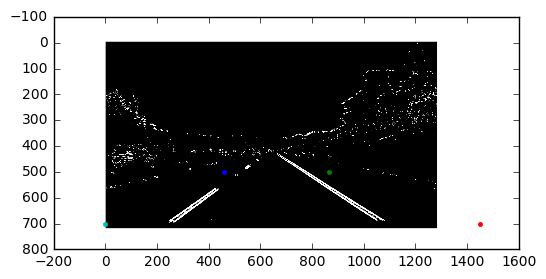

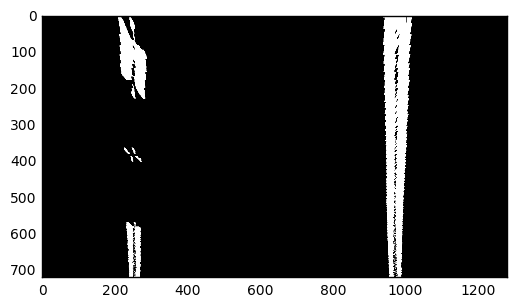

In [6]:
def getPerspectiveImage(image,src,dst):
 #   offset = 0#100
    img_size = (image.shape[1],img.shape[0])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(image, M,img_size)
    return warped,M,Minv
src = np.float32([ [460,500],[865,500],[1450,700],[0,700]])
def image2PerspectiveImage(image):
    #print('Thresholded Magnitude')
    #get birds view    
    #src = np.float32([ [430,510],[855,510],[1320,700],[0,700]])
    #src = np.float32([ [430,500],[855,500],[1320,700],[0,700]])
    src = np.float32([ [440,500],[870,500],[1380,680],[0,680]])
    dst= np.float32([[0,300],[1280,300],[1280,720],[0,720]])
    img_size = (image.shape[1],image.shape[0])
    # src = np.float32(
    # [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    # [((img_size[0] / 6) - 10), img_size[1]],
    # [(img_size[0] * 5 / 6) + 60, img_size[1]],
    # [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    # dst = np.float32(
    # [[(img_size[0] / 4), 0],
    # [(img_size[0] / 4), img_size[1]],
    # [(img_size[0] * 3 / 4), img_size[1]],
    # [(img_size[0] * 3 / 4), 0]])
    #print("darw  the selected point in image")
    #plt.imshow(image,'gray')
    # for i in range(4):
    #     plt.plot(src[i][0],src[i][1],'.')
    #     plt.show()
    warped_image,M,Minv = getPerspectiveImage(image,src,dst)
    #print("perspecitve image:")
    #plt.imshow(warped_image,'gray')
    #plt.show()
    return warped_image,M,Minv
#warped_image,M,Minv = image2PerspectiveImage(img)
#src = np.float32([ [430,510],[855,510],[1320,700],[0,700]])
plt.imshow(mag_hls_image,'gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'.')
plt.show()
perspective_img,M,Minv = image2PerspectiveImage(mag_hls_image)
plt.imshow(perspective_img,"gray")
plt.show()
    

####4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?
I used the function findRoadFit(image) which is in belowed code cell to get the lane fits.
首先，我在图片的高度的中间，找到了两侧最大的值，作为 leftx_base and rightx_base.
通过里line_width =  rightx_base - leftx_base 我获得了这两条平行线间的宽度。
我使用了左右两侧各6个窗口，窗口宽度为margin ×2 = 240 高度为图片高度/6.
在每个窗口中，找到非零点，若窗口的非零点个数大于minpix= 100 ，则认为该区域有效。并将该区域点密集区域的平均值作为有效点。并且作为下一次窗口起始点。为了防止某些情况下单侧没有点存在，使用左侧，或右侧的有效点，作为不存在有效点的一侧的参考位置，该位置获得方法为 当左侧无有效点存在时：右侧 - 平行线宽度。 当右侧无有效点存在时: 左侧 + 平行线宽度
获得了图片中的左右点位置后，使用 np.polyfit(left_current_y_array,left_current_x_array,2)，进行拟合，得到左右的拟合曲线。
代码在如下code cell中，结果绘制在code cell 的output中


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
#histogram = np.sum(warped_image[int(warped_image.shape[0]/2):,:], axis=0)
#plt.plot(histogram)
ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
def findRoadFit(image):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(image[int(image.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    #the two parallel lines width
    line_width = rightx_base - leftx_base       
    # for the lane and the position of the vehicle with respect to center:
    line_bias_pixel = (rightx_base + leftx_base)/2 - midpoint    
    #print(line_bias_pixel)
    #print("leftx_base = ",leftx_base)
    #print("rightx_base = ",rightx_base)
    # Choose the number of sliding windows
    nwindows = 6
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- marpgin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 80
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    left_current_x_array,left_current_y_array,right_current_x_array,right_current_y_array = [],[],[],[]    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds) 
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        left_good = (len(good_left_inds) > minpix)
        right_good = (len(good_right_inds) > minpix)
        
        if left_good:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))            
        if right_good:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        else:
            continue
        if left_good :            
            lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
        elif right_good :
            leftx_current =  rightx_current - line_width
            lefty_current = np.int((win_y_low+win_y_high)/2)       
            
        if right_good :            
            righty_current = np.int(np.mean(nonzeroy[good_right_inds]))
        elif left_good:
            rightx_current =  leftx_current+ line_width
            righty_current = np.int((win_y_low+win_y_high)/2)

        if lefty_current is None:
            lefty_current = np.int((win_y_low+win_y_high)/2)
        if righty_current is None:
            righty_current = np.int((win_y_low+win_y_high)/2)

        if len(good_left_inds) > minpix:
        #     leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        #     lefty_current = np.int(np.mean(nonzeroy[good_left_inds]))
        # else :
        #     leftx_current =  leftx_base
        #     lefty_current = np.int((win_y_low+win_y_high)/2)
        # if len(good_right_inds) > minpix:                    
        #     rightx_current = np.int(np.mean(nonzerox[good_right_inds]))            
        #     righty_current = np.int(np.mean(nonzeroy[good_right_inds]))
        # else:
        #     rightx_current =  rightx_base
        #     righty_current = np.int((win_y_low+win_y_high)/2)
        
        left_current_y_array.append(lefty_current)
        right_current_x_array.append(rightx_current)
        right_current_y_array.append(righty_current)       
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    left_fit= np.polyfit(left_current_y_array,left_current_x_array,2)
    right_fit = np.polyfit(right_current_y_array,right_current_x_array,2)
    #Visualization    
    #Visualization The Reuslt
    # Generate x and y values for plotting   
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]    
    #return left_fit,right_fit,ploty,leftx,lefty,rightx,righty
    return left_fit,right_fit,left_current_x_array,left_current_y_array,right_current_x_array,right_current_y_array,line_bias_pixel,out_img

(720, 0)

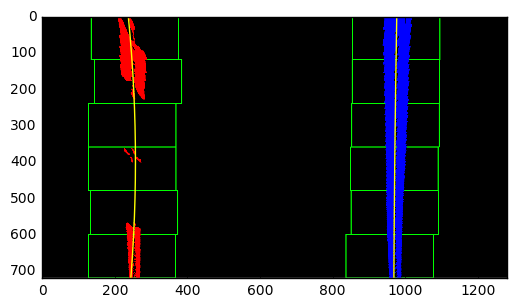

In [15]:
left_fit,right_fit,leftx,lefty,rightx,righty,line_bias_pixel,out_img = findRoadFit(perspective_img)
def getOutImage(image,left_fit,right_fit):
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return left_fitx,right_fitx
left_fitx,right_fitx = getOutImage(out_img,left_fit,right_fit)
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


In [16]:
def findNextRoadFit(image,left_fit,right_fit):
        # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 120
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1,image.shape[0] )    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((image,image,image))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    return left_fit,right_fit,ploty,leftx,lefty,rightx,righty
    #return left_fit,right_fit,ploty,leftx
   

In [10]:
#GET PLOYFIT
#left_fit,right_fit,leftx,lefty,rightx,righty = findRoadFit(warped_image)
#left_fit,right_fit,leftx,lefty,rightx,righty,line_bias_pixel = findRoadFit(warped_image)
#print(left_fit)
#print(right_fit)
#findNextRoadFit(warped_image,left_fit,right_fit)


####5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in below code cell:
the fit is : f(y)=Ay​**2​​ +By+C
so the curverad is:
curverad= ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
for the lane and the position of the vehicle with respect to center:
the line_bias_pixel is return in the findroadFit().It calculate by:
line_bias_pixel = (rightx_base + leftx_base)/2 - midpoint
the rightx_base the leftx_base is when y is center of the image height,and the x position which is none zero value mean
value. the (rightx_base + leftx_base)/2 is current parallel center position and use it to sub the center of the image width ,then plus the 3.7/700(per pixel to metter) is the position of the vehicle.
#I used  3.7/700 * line_bias_pixel


In [17]:

def calculateCurverad(left_fit,right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])    
    return left_curverad,right_curverad
def calculateCurveradMeters(leftx,rightx,lefty,righty):
    #Define conversions in x and y from pixels space to meters
    y_eval = np.max(leftx)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    #print(ploty)
    #print(leftx)
    #print(rightx)
    #leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    #rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    #print(len(ploty*ym_per_pix))
    #print(len(leftx*xm_per_pix))
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    
    left_curverad_meters = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_meters = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # if left_curverad_meters >1000:
    #     left_curverad_meters = 0
    # if right_curverad_meters >1000:
    #     right_curverad_meters = 0
        
    return left_curverad_meters,right_curverad_meters

In [18]:
left_curverad, right_curverad = calculateCurverad(left_fit,right_fit)
left_curverad_meters , right_curverad_meters = calculateCurveradMeters(np.array(leftx),
                         np.array(rightx),
                         np.array(lefty),
                         np.array(righty))
print(left_curverad, right_curverad)
print(left_curverad_meters, 'm', right_curverad_meters, 'm')
print(line_bias_pixel)
print("distance={} m ".format(3.7/700 * line_bias_pixel))

4078.54254855 58980.9875731
1327.0545372 m 19371.9023801 m
-39.0
distance=-0.20614285714285716 m 


In [19]:
def getUnPerspectiveImage(warped_img,undistorted_img,left_fit,right_fit,Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv,
                              (undistorted_img.shape[1], undistorted_img.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    return result
# #plt.imshow(perspective_img,'gray')
# plt.show()
# # Create an image to draw the lines on
# warp_zero = np.zeros_like(perspective_img).astype(np.uint8)
# color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
# ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
# left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# # Recast the x and y points into usable format for cv2.fillPoly()
# pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
# pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
# pts = np.hstack((pts_left, pts_right))
# # Draw the lane onto the warped blank image
# cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
# # Warp the blank back to original image space using inverse perspective matrix (Minv)
# newwarp = cv2.warpPerspective(color_warp, Minv,
#                               (undistorted_img.shape[1], undistorted_img.shape[0]))
# # Combine the result with the original image
# result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
# plt.imshow(result)
# plt.show()

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

####6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.
the image is showed in the belowed 2rd cell output and also in the position " ./output_images/"

In [21]:
from scipy import misc
n
def imageHandle(image):
    # Undistored Image
    undistorted_img = getUndistortImage(image)
    img_size = img.shape[::-1]
    
    # grayscale image
    # sobel for gradient
    # color channel
    fliter_img = imgMagAndhlsFilter(undistorted_img)
    # get bird view
    birdview_img,M,Minv = image2PerspectiveImage(fliter_img)
    #find road fit 
    left_fit,right_fit,leftx,lefty,rightx,righty,line_bias_pixel,out_img = findRoadFit(birdview_img)
    left_curverad,right_curverad = calculateCurverad(left_fit,right_fit)
    left_curverad_meters,right_curverad_meters = calculateCurveradMeters(np.array(leftx),
                            np.array(rightx),
                            np.array(lefty),
                            np.array(righty))
    distance  = 3.7/700 * line_bias_pixel
    return left_curverad,right_curverad,left_curverad_meters,right_curverad_meters,Minv,left_fit,right_fit,leftx,lefty,rightx,righty,distance,out_img,birdview_img,undistorted_img
def getImageResult(image):
    result = getUnPerspectiveImage(warped_img,undistorted_img,left_fit,right_fit,Minv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_string = "Radius of Curvature = {:.3f}  m".format((left_curverad_meters + right_curverad_meters)/2)
    vehicle_string = ""
    if distance > 0:
        vehicle_string = "Vehicle is {:.3f} m left of center".format(distance)
    else:
        vehicle_string = "Vehicle is {:.3f} m right of center".format(-distance)
    result = cv2.putText(result,curvature_string,(20,80),font,1.5,(255,255,255),2)
    result = cv2.putText(result,vehicle_string,(20,160),font,1.5,(255,255,255),2)    
    return result
def process_image(image):
    undistorted_img = getUndistortImage(image)
    img_size = img.shape[::-1]
    
    # grayscale image
    # sobel for gradient
    # color channel
    fliter_img = imgMagAndhlsFilter(undistorted_img)
    # get bird view
    birdview_img,M,Minv = image2PerspectiveImage(fliter_img)
    #find road fit 
    left_fit,right_fit,leftx,lefty,rightx,righty,line_bias_pixel,out_img = findRoadFit(birdview_img)
    left_curverad,right_curverad = calculateCurverad(left_fit,right_fit)
    left_curverad_meters,right_curverad_meters = calculateCurveradMeters(np.array(leftx),
                            np.array(rightx),
                            np.array(lefty),
                            np.array(righty))
    distance  = 3.7/700 * line_bias_pixel
    result = getUnPerspectiveImage(birdview_img,undistorted_img,left_fit,right_fit,Minv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_string = "Radius of Curvature = {:.3f}  m".format((left_curverad_meters + right_curverad_meters)/2)
    vehicle_string = ""
    if distance > 0:
        vehicle_string = "Vehicle is {:.3f} m left of center".format(distance)
    else:
        vehicle_string = "Vehicle is {:.3f} m right of center".format(-distance)
    result = cv2.putText(result,curvature_string,(20,80),font,1.5,(255,255,255),2)
    result = cv2.putText(result,vehicle_string,(20,160),font,1.5,(255,255,255),2)    
    return result
    

ORIGIN IMAGE


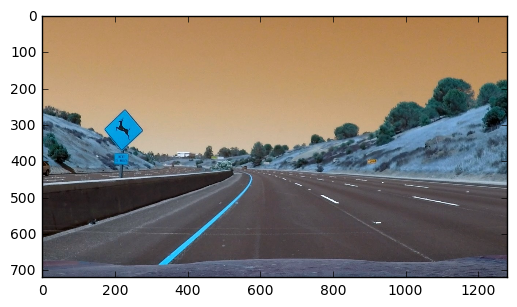

result image


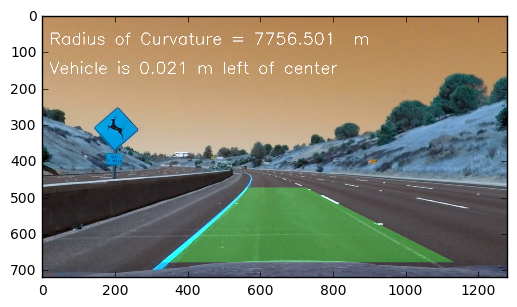

ORIGIN IMAGE


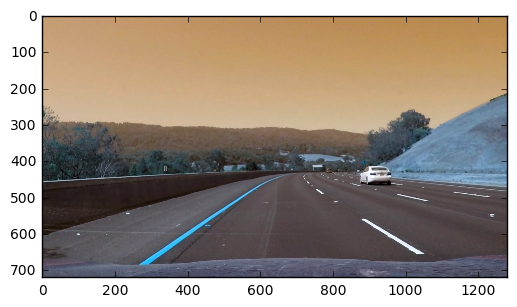

result image


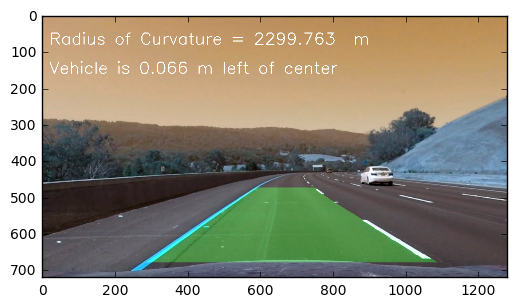

ORIGIN IMAGE


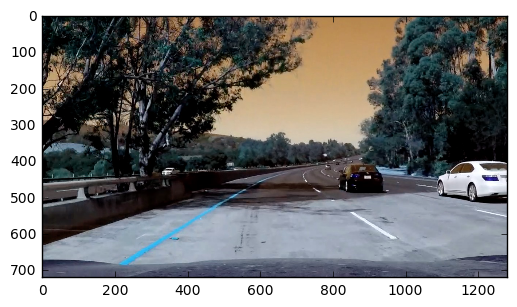

result image


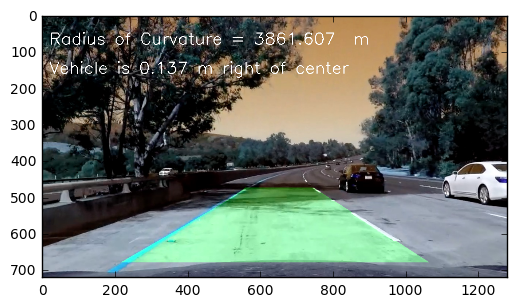

ORIGIN IMAGE


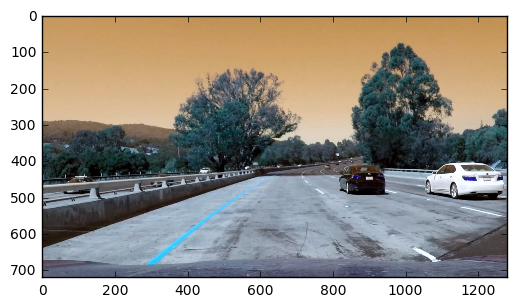

result image


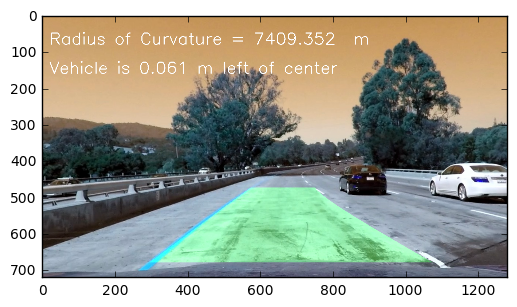

ORIGIN IMAGE


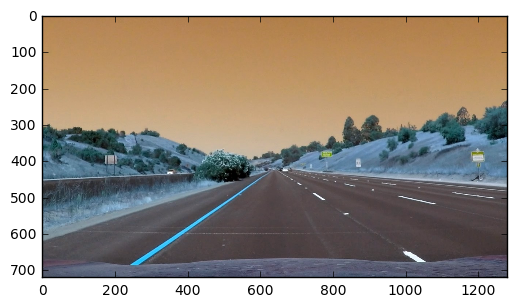

result image


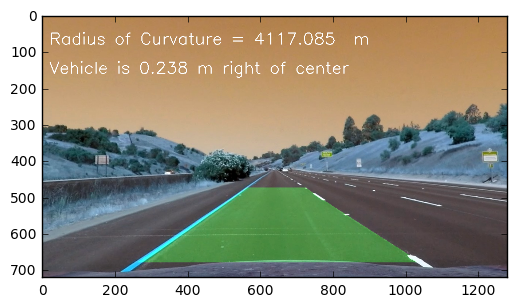

ORIGIN IMAGE


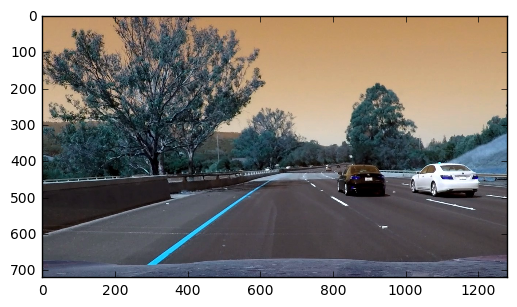

result image


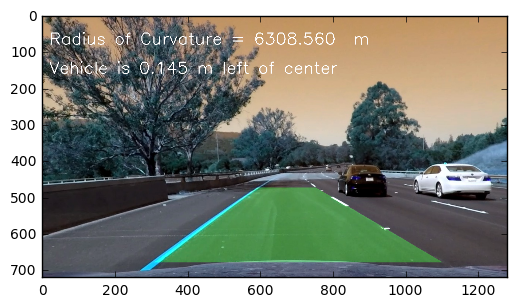

ORIGIN IMAGE


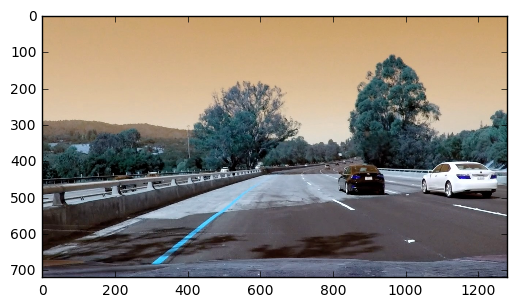

result image


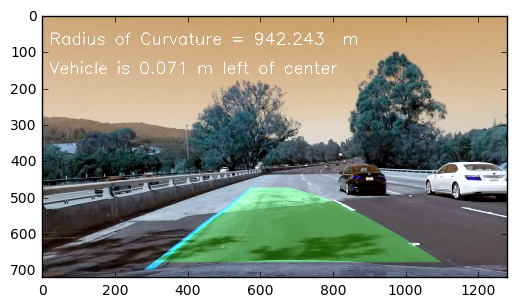

ORIGIN IMAGE


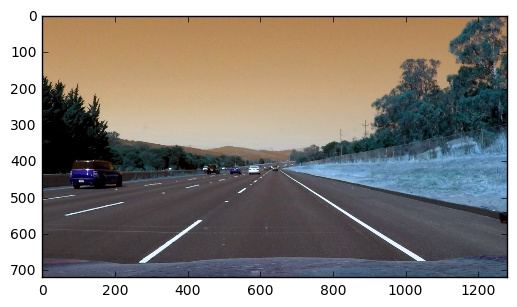

result image


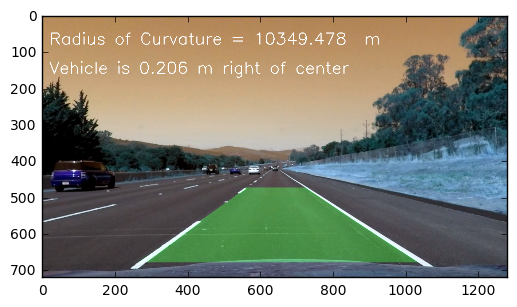

In [25]:
## processed the image

test_path = "./test_images/"
file_list = os.listdir(test_path)
test_image_list = []
fileName_list =[]
#print(file_list)
for file in file_list:
    test_image_list.append(cv2.imread(test_path+file))
    fileName_list.append(file)

output_path = "./output_images/"
file_index = 0
#print(test_image_list)
for img in test_image_list:
    print("ORIGIN IMAGE")
    plt.imshow(img)
    plt.show()

    result = process_image(img)
    result = misc.toimage(result, cmin=0, cmax=255)
    result.save(output_path+fileName_list[file_index])

    file_index += 1
    print("result image")
    plt.imshow(result)
    plt.show()

In [19]:
# video handle
from moviepy.editor import VideoFileClip
video_output = './output_images/project_video.mp4'
clip = VideoFileClip('./project_video.mp4')
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)
#video_output =


[MoviePy] >>>> Building video ./output_images/project_video.mp4


[MoviePy] Writing video ./output_images/project_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<04:24,  4.77it/s]

  0%|          | 2/1261 [00:00<04:29,  4.67it/s]

  0%|          | 3/1261 [00:00<04:26,  4.72it/s]

  0%|          | 4/1261 [00:00<04:25,  4.74it/s]

  0%|          | 5/1261 [00:01<04:22,  4.78it/s]

  0%|          | 6/1261 [00:01<04:21,  4.80it/s]

  1%|          | 7/1261 [00:01<04:20,  4.82it/s]

  1%|          | 8/1261 [00:01<04:18,  4.84it/s]

  1%|          | 9/1261 [00:01<04:18,  4.84it/s]

  1%|          | 10/1261 [00:02<04:17,  4.85it/s]

  1%|          | 11/1261 [00:02<04:16,  4.87it/s]

  1%|          | 12/1261 [00:02<04:17,  4.85it/s]

  1%|          | 13/1261 [00:02<04:18,  4.83it/s]

  1%|          | 14/1261 [00:02<04:17,  4.84it/s]

  1%|          | 15/1261 [00:03<04:16,  4.86it/s]

  1%|▏         | 16/1261 [00:03<04:17,  4.83it/s]

  1%|▏         | 17/1261 [00:03<04:22,  4.74it/s]

  1%|▏         | 18/1261 [00:03<04:21,  4.75it/s]

  2%|▏         | 19/1261 [00:03<04:21,  4.75it/s]

  2%|▏         | 20/1261 [00:04<04:22,  4.73it/s]

  2%|▏         | 21/1261 [00:04<04:19,  4.77it/s]

  2%|▏         | 22/1261 [00:04<04:20,  4.75it/s]

  2%|▏         | 23/1261 [00:04<04:17,  4.80it/s]

  2%|▏         | 24/1261 [00:05<04:17,  4.80it/s]

  2%|▏         | 25/1261 [00:05<04:16,  4.82it/s]

  2%|▏         | 26/1261 [00:05<04:15,  4.83it/s]

  2%|▏         | 27/1261 [00:05<04:13,  4.86it/s]

  2%|▏         | 28/1261 [00:05<04:13,  4.86it/s]

  2%|▏         | 29/1261 [00:06<04:13,  4.85it/s]

  2%|▏         | 30/1261 [00:06<04:12,  4.87it/s]

  2%|▏         | 31/1261 [00:06<04:14,  4.83it/s]

  3%|▎         | 32/1261 [00:06<04:14,  4.83it/s]

  3%|▎         | 33/1261 [00:06<04:12,  4.86it/s]

  3%|▎         | 34/1261 [00:07<04:11,  4.87it/s]

  3%|▎         | 35/1261 [00:07<04:12,  4.86it/s]

  3%|▎         | 36/1261 [00:07<04:12,  4.86it/s]

  3%|▎         | 37/1261 [00:07<04:12,  4.86it/s]

  3%|▎         | 38/1261 [00:07<04:13,  4.82it/s]

  3%|▎         | 39/1261 [00:08<04:13,  4.82it/s]

  3%|▎         | 40/1261 [00:08<04:15,  4.78it/s]

  3%|▎         | 41/1261 [00:08<04:17,  4.75it/s]

  3%|▎         | 42/1261 [00:08<04:16,  4.75it/s]

  3%|▎         | 43/1261 [00:08<04:19,  4.69it/s]

  3%|▎         | 44/1261 [00:09<04:19,  4.69it/s]

  4%|▎         | 45/1261 [00:09<04:20,  4.67it/s]

  4%|▎         | 46/1261 [00:09<04:19,  4.69it/s]

  4%|▎         | 47/1261 [00:09<04:18,  4.70it/s]

  4%|▍         | 48/1261 [00:10<04:19,  4.68it/s]

  4%|▍         | 49/1261 [00:10<04:17,  4.72it/s]

  4%|▍         | 50/1261 [00:10<04:16,  4.71it/s]

  4%|▍         | 51/1261 [00:10<04:18,  4.68it/s]

  4%|▍         | 52/1261 [00:10<04:22,  4.61it/s]

  4%|▍         | 53/1261 [00:11<04:21,  4.63it/s]

  4%|▍         | 54/1261 [00:11<04:19,  4.66it/s]

  4%|▍         | 55/1261 [00:11<04:20,  4.63it/s]

  4%|▍         | 56/1261 [00:11<04:20,  4.63it/s]

  5%|▍         | 57/1261 [00:11<04:19,  4.63it/s]

  5%|▍         | 58/1261 [00:12<04:23,  4.57it/s]

  5%|▍         | 59/1261 [00:12<04:19,  4.64it/s]

  5%|▍         | 60/1261 [00:12<04:17,  4.67it/s]

  5%|▍         | 61/1261 [00:12<04:17,  4.67it/s]

  5%|▍         | 62/1261 [00:13<04:15,  4.69it/s]

  5%|▍         | 63/1261 [00:13<04:16,  4.67it/s]

  5%|▌         | 64/1261 [00:13<04:16,  4.66it/s]

  5%|▌         | 65/1261 [00:13<04:20,  4.59it/s]

  5%|▌         | 66/1261 [00:13<04:19,  4.60it/s]

  5%|▌         | 67/1261 [00:14<04:17,  4.64it/s]

  5%|▌         | 68/1261 [00:14<04:17,  4.63it/s]

  5%|▌         | 69/1261 [00:14<04:14,  4.68it/s]

  6%|▌         | 70/1261 [00:14<04:12,  4.71it/s]

  6%|▌         | 71/1261 [00:14<04:17,  4.62it/s]

  6%|▌         | 72/1261 [00:15<04:18,  4.61it/s]

  6%|▌         | 73/1261 [00:15<04:18,  4.60it/s]

  6%|▌         | 74/1261 [00:15<04:18,  4.59it/s]

  6%|▌         | 75/1261 [00:15<04:17,  4.60it/s]

  6%|▌         | 76/1261 [00:16<04:16,  4.61it/s]

  6%|▌         | 77/1261 [00:16<04:20,  4.54it/s]

  6%|▌         | 78/1261 [00:16<04:19,  4.56it/s]

  6%|▋         | 79/1261 [00:16<04:18,  4.58it/s]

  6%|▋         | 80/1261 [00:16<04:14,  4.64it/s]

  6%|▋         | 81/1261 [00:17<04:14,  4.64it/s]

  7%|▋         | 82/1261 [00:17<04:14,  4.63it/s]

  7%|▋         | 83/1261 [00:17<04:14,  4.62it/s]

  7%|▋         | 84/1261 [00:17<04:13,  4.64it/s]

  7%|▋         | 85/1261 [00:18<04:13,  4.63it/s]

  7%|▋         | 86/1261 [00:18<04:13,  4.64it/s]

  7%|▋         | 87/1261 [00:18<04:15,  4.59it/s]

  7%|▋         | 88/1261 [00:18<04:15,  4.59it/s]

  7%|▋         | 89/1261 [00:18<04:16,  4.58it/s]

  7%|▋         | 90/1261 [00:19<04:15,  4.58it/s]

  7%|▋         | 91/1261 [00:19<04:14,  4.60it/s]

  7%|▋         | 92/1261 [00:19<04:16,  4.56it/s]

  7%|▋         | 93/1261 [00:19<04:13,  4.60it/s]

  7%|▋         | 94/1261 [00:19<04:12,  4.61it/s]

  8%|▊         | 95/1261 [00:20<04:11,  4.64it/s]

  8%|▊         | 96/1261 [00:20<04:11,  4.63it/s]

  8%|▊         | 97/1261 [00:20<04:10,  4.64it/s]

  8%|▊         | 98/1261 [00:20<04:09,  4.67it/s]

  8%|▊         | 99/1261 [00:21<04:07,  4.69it/s]

  8%|▊         | 100/1261 [00:21<04:06,  4.70it/s]

  8%|▊         | 101/1261 [00:21<04:05,  4.73it/s]

  8%|▊         | 102/1261 [00:21<04:03,  4.76it/s]

  8%|▊         | 103/1261 [00:21<04:05,  4.71it/s]

  8%|▊         | 104/1261 [00:22<04:07,  4.67it/s]

  8%|▊         | 105/1261 [00:22<04:07,  4.67it/s]

  8%|▊         | 106/1261 [00:22<04:07,  4.67it/s]

  8%|▊         | 107/1261 [00:22<04:13,  4.56it/s]

  9%|▊         | 108/1261 [00:22<04:08,  4.63it/s]

  9%|▊         | 109/1261 [00:23<04:07,  4.65it/s]

  9%|▊         | 110/1261 [00:23<04:04,  4.70it/s]

  9%|▉         | 111/1261 [00:23<04:02,  4.74it/s]

  9%|▉         | 112/1261 [00:23<04:03,  4.71it/s]

  9%|▉         | 113/1261 [00:24<04:03,  4.71it/s]

  9%|▉         | 114/1261 [00:24<04:02,  4.73it/s]

  9%|▉         | 115/1261 [00:24<04:01,  4.75it/s]

  9%|▉         | 116/1261 [00:24<04:07,  4.63it/s]

  9%|▉         | 117/1261 [00:24<04:13,  4.52it/s]

  9%|▉         | 118/1261 [00:25<04:17,  4.43it/s]

  9%|▉         | 119/1261 [00:25<04:17,  4.43it/s]

 10%|▉         | 120/1261 [00:25<04:20,  4.39it/s]

 10%|▉         | 121/1261 [00:25<04:21,  4.36it/s]

 10%|▉         | 122/1261 [00:26<04:19,  4.39it/s]

 10%|▉         | 123/1261 [00:26<04:18,  4.41it/s]

 10%|▉         | 124/1261 [00:26<04:19,  4.38it/s]

 10%|▉         | 125/1261 [00:26<04:21,  4.35it/s]

 10%|▉         | 126/1261 [00:26<04:24,  4.29it/s]

 10%|█         | 127/1261 [00:27<04:23,  4.30it/s]

 10%|█         | 128/1261 [00:27<04:24,  4.28it/s]

 10%|█         | 129/1261 [00:27<04:20,  4.35it/s]

 10%|█         | 130/1261 [00:27<04:23,  4.29it/s]

 10%|█         | 131/1261 [00:28<04:20,  4.34it/s]

 10%|█         | 132/1261 [00:28<04:16,  4.40it/s]

 11%|█         | 133/1261 [00:28<04:14,  4.43it/s]

 11%|█         | 134/1261 [00:28<04:14,  4.43it/s]

 11%|█         | 135/1261 [00:29<04:11,  4.48it/s]

 11%|█         | 136/1261 [00:29<04:10,  4.50it/s]

 11%|█         | 137/1261 [00:29<04:12,  4.46it/s]

 11%|█         | 138/1261 [00:29<04:16,  4.39it/s]

 11%|█         | 139/1261 [00:29<04:18,  4.34it/s]

 11%|█         | 140/1261 [00:30<04:20,  4.31it/s]

 11%|█         | 141/1261 [00:30<04:23,  4.25it/s]

 11%|█▏        | 142/1261 [00:30<04:23,  4.24it/s]

 11%|█▏        | 143/1261 [00:30<04:22,  4.26it/s]

 11%|█▏        | 144/1261 [00:31<04:21,  4.27it/s]

 11%|█▏        | 145/1261 [00:31<04:19,  4.31it/s]

 12%|█▏        | 146/1261 [00:31<04:17,  4.32it/s]

 12%|█▏        | 147/1261 [00:31<04:16,  4.35it/s]

 12%|█▏        | 148/1261 [00:32<04:16,  4.33it/s]

 12%|█▏        | 149/1261 [00:32<04:17,  4.31it/s]

 12%|█▏        | 150/1261 [00:32<04:15,  4.35it/s]

 12%|█▏        | 151/1261 [00:32<04:14,  4.37it/s]

 12%|█▏        | 152/1261 [00:32<04:09,  4.45it/s]

 12%|█▏        | 153/1261 [00:33<04:13,  4.37it/s]

 12%|█▏        | 154/1261 [00:33<04:14,  4.36it/s]

 12%|█▏        | 155/1261 [00:33<04:09,  4.43it/s]

 12%|█▏        | 156/1261 [00:33<04:08,  4.44it/s]

 12%|█▏        | 157/1261 [00:34<04:09,  4.42it/s]

 13%|█▎        | 158/1261 [00:34<04:08,  4.45it/s]

 13%|█▎        | 159/1261 [00:34<04:07,  4.46it/s]

 13%|█▎        | 160/1261 [00:34<04:10,  4.40it/s]

 13%|█▎        | 161/1261 [00:34<04:04,  4.50it/s]

 13%|█▎        | 162/1261 [00:35<04:02,  4.53it/s]

 13%|█▎        | 163/1261 [00:35<04:05,  4.48it/s]

 13%|█▎        | 164/1261 [00:35<04:07,  4.44it/s]

 13%|█▎        | 165/1261 [00:35<04:08,  4.40it/s]

 13%|█▎        | 166/1261 [00:36<04:09,  4.39it/s]

 13%|█▎        | 167/1261 [00:36<04:04,  4.48it/s]

 13%|█▎        | 168/1261 [00:36<04:06,  4.44it/s]

 13%|█▎        | 169/1261 [00:36<04:06,  4.44it/s]

 13%|█▎        | 170/1261 [00:36<04:02,  4.50it/s]

 14%|█▎        | 171/1261 [00:37<03:57,  4.60it/s]

 14%|█▎        | 172/1261 [00:37<03:59,  4.55it/s]

 14%|█▎        | 173/1261 [00:37<03:58,  4.56it/s]

 14%|█▍        | 174/1261 [00:37<03:56,  4.60it/s]

 14%|█▍        | 175/1261 [00:38<03:55,  4.61it/s]

 14%|█▍        | 176/1261 [00:38<03:57,  4.56it/s]

 14%|█▍        | 177/1261 [00:38<03:59,  4.52it/s]

 14%|█▍        | 178/1261 [00:38<04:04,  4.43it/s]

 14%|█▍        | 179/1261 [00:38<04:07,  4.37it/s]

 14%|█▍        | 180/1261 [00:39<04:03,  4.45it/s]

 14%|█▍        | 181/1261 [00:39<04:00,  4.50it/s]

 14%|█▍        | 182/1261 [00:39<03:58,  4.52it/s]

 15%|█▍        | 183/1261 [00:39<03:58,  4.52it/s]

 15%|█▍        | 184/1261 [00:40<03:57,  4.54it/s]

 15%|█▍        | 185/1261 [00:40<03:57,  4.54it/s]

 15%|█▍        | 186/1261 [00:40<03:58,  4.51it/s]

 15%|█▍        | 187/1261 [00:40<03:58,  4.51it/s]

 15%|█▍        | 188/1261 [00:40<03:56,  4.53it/s]

 15%|█▍        | 189/1261 [00:41<03:53,  4.59it/s]

 15%|█▌        | 190/1261 [00:41<03:55,  4.55it/s]

 15%|█▌        | 191/1261 [00:41<03:52,  4.59it/s]

 15%|█▌        | 192/1261 [00:41<03:50,  4.63it/s]

 15%|█▌        | 193/1261 [00:42<03:49,  4.65it/s]

 15%|█▌        | 194/1261 [00:42<03:47,  4.68it/s]

 15%|█▌        | 195/1261 [00:42<03:47,  4.69it/s]

 16%|█▌        | 196/1261 [00:42<03:48,  4.67it/s]

 16%|█▌        | 197/1261 [00:42<03:46,  4.71it/s]

 16%|█▌        | 198/1261 [00:43<03:46,  4.69it/s]

 16%|█▌        | 199/1261 [00:43<03:45,  4.72it/s]

 16%|█▌        | 200/1261 [00:43<03:45,  4.70it/s]

 16%|█▌        | 201/1261 [00:43<03:49,  4.62it/s]

 16%|█▌        | 202/1261 [00:43<03:47,  4.65it/s]

 16%|█▌        | 203/1261 [00:44<03:46,  4.67it/s]

 16%|█▌        | 204/1261 [00:44<03:47,  4.65it/s]

 16%|█▋        | 205/1261 [00:44<03:46,  4.66it/s]

 16%|█▋        | 206/1261 [00:44<03:45,  4.68it/s]

 16%|█▋        | 207/1261 [00:45<03:45,  4.67it/s]

 16%|█▋        | 208/1261 [00:45<03:46,  4.64it/s]

 17%|█▋        | 209/1261 [00:45<03:47,  4.63it/s]

 17%|█▋        | 210/1261 [00:45<03:47,  4.63it/s]

 17%|█▋        | 211/1261 [00:45<03:46,  4.64it/s]

 17%|█▋        | 212/1261 [00:46<03:45,  4.66it/s]

 17%|█▋        | 213/1261 [00:46<03:44,  4.68it/s]

 17%|█▋        | 214/1261 [00:46<03:44,  4.66it/s]

 17%|█▋        | 215/1261 [00:46<03:46,  4.62it/s]

 17%|█▋        | 216/1261 [00:46<03:45,  4.63it/s]

 17%|█▋        | 217/1261 [00:47<03:43,  4.66it/s]

 17%|█▋        | 218/1261 [00:47<03:43,  4.66it/s]

 17%|█▋        | 219/1261 [00:47<03:43,  4.66it/s]

 17%|█▋        | 220/1261 [00:47<03:45,  4.62it/s]

 18%|█▊        | 221/1261 [00:48<03:43,  4.65it/s]

 18%|█▊        | 222/1261 [00:48<03:41,  4.70it/s]

 18%|█▊        | 223/1261 [00:48<03:42,  4.67it/s]

 18%|█▊        | 224/1261 [00:48<03:45,  4.61it/s]

 18%|█▊        | 225/1261 [00:48<03:43,  4.63it/s]

 18%|█▊        | 226/1261 [00:49<03:43,  4.64it/s]

 18%|█▊        | 227/1261 [00:49<03:41,  4.67it/s]

 18%|█▊        | 228/1261 [00:49<03:41,  4.67it/s]

 18%|█▊        | 229/1261 [00:49<03:42,  4.63it/s]

 18%|█▊        | 230/1261 [00:49<03:43,  4.62it/s]

 18%|█▊        | 231/1261 [00:50<03:46,  4.55it/s]

 18%|█▊        | 232/1261 [00:50<03:47,  4.53it/s]

 18%|█▊        | 233/1261 [00:50<03:51,  4.44it/s]

 19%|█▊        | 234/1261 [00:50<03:49,  4.47it/s]

 19%|█▊        | 235/1261 [00:51<03:47,  4.51it/s]

 19%|█▊        | 236/1261 [00:51<03:47,  4.51it/s]

 19%|█▉        | 237/1261 [00:51<03:47,  4.51it/s]

 19%|█▉        | 238/1261 [00:51<03:47,  4.50it/s]

 19%|█▉        | 239/1261 [00:52<03:45,  4.53it/s]

 19%|█▉        | 240/1261 [00:52<03:42,  4.58it/s]

 19%|█▉        | 241/1261 [00:52<03:40,  4.63it/s]

 19%|█▉        | 242/1261 [00:52<03:39,  4.63it/s]

 19%|█▉        | 243/1261 [00:52<03:38,  4.67it/s]

 19%|█▉        | 244/1261 [00:53<03:35,  4.72it/s]

 19%|█▉        | 245/1261 [00:53<03:34,  4.73it/s]

 20%|█▉        | 246/1261 [00:53<03:36,  4.69it/s]

 20%|█▉        | 247/1261 [00:53<03:35,  4.70it/s]

 20%|█▉        | 248/1261 [00:53<03:35,  4.70it/s]

 20%|█▉        | 249/1261 [00:54<03:35,  4.69it/s]

 20%|█▉        | 250/1261 [00:54<03:37,  4.66it/s]

 20%|█▉        | 251/1261 [00:54<03:36,  4.66it/s]

 20%|█▉        | 252/1261 [00:54<03:37,  4.65it/s]

 20%|██        | 253/1261 [00:54<03:38,  4.61it/s]

 20%|██        | 254/1261 [00:55<03:37,  4.63it/s]

 20%|██        | 255/1261 [00:55<03:35,  4.66it/s]

 20%|██        | 256/1261 [00:55<03:33,  4.71it/s]

 20%|██        | 257/1261 [00:55<03:31,  4.74it/s]

 20%|██        | 258/1261 [00:56<03:32,  4.73it/s]

 21%|██        | 259/1261 [00:56<03:32,  4.72it/s]

 21%|██        | 260/1261 [00:56<03:33,  4.69it/s]

 21%|██        | 261/1261 [00:56<03:32,  4.70it/s]

 21%|██        | 262/1261 [00:56<03:34,  4.65it/s]

 21%|██        | 263/1261 [00:57<03:33,  4.67it/s]

 21%|██        | 264/1261 [00:57<03:32,  4.68it/s]

 21%|██        | 265/1261 [00:57<03:32,  4.69it/s]

 21%|██        | 266/1261 [00:57<03:32,  4.69it/s]

 21%|██        | 267/1261 [00:57<03:31,  4.71it/s]

 21%|██▏       | 268/1261 [00:58<03:32,  4.67it/s]

 21%|██▏       | 269/1261 [00:58<03:31,  4.68it/s]

 21%|██▏       | 270/1261 [00:58<03:33,  4.63it/s]

 21%|██▏       | 271/1261 [00:58<03:33,  4.64it/s]

 22%|██▏       | 272/1261 [00:59<03:32,  4.66it/s]

 22%|██▏       | 273/1261 [00:59<03:32,  4.65it/s]

 22%|██▏       | 274/1261 [00:59<03:31,  4.66it/s]

 22%|██▏       | 275/1261 [00:59<03:31,  4.65it/s]

 22%|██▏       | 276/1261 [00:59<03:31,  4.65it/s]

 22%|██▏       | 277/1261 [01:00<03:31,  4.65it/s]

 22%|██▏       | 278/1261 [01:00<03:32,  4.63it/s]

 22%|██▏       | 279/1261 [01:00<03:33,  4.60it/s]

 22%|██▏       | 280/1261 [01:00<03:32,  4.62it/s]

 22%|██▏       | 281/1261 [01:00<03:31,  4.63it/s]

 22%|██▏       | 282/1261 [01:01<03:31,  4.63it/s]

 22%|██▏       | 283/1261 [01:01<03:32,  4.61it/s]

 23%|██▎       | 284/1261 [01:01<03:31,  4.61it/s]

 23%|██▎       | 285/1261 [01:01<03:28,  4.68it/s]

 23%|██▎       | 286/1261 [01:02<03:27,  4.69it/s]

 23%|██▎       | 287/1261 [01:02<03:25,  4.73it/s]

 23%|██▎       | 288/1261 [01:02<03:25,  4.73it/s]

 23%|██▎       | 289/1261 [01:02<03:26,  4.70it/s]

 23%|██▎       | 290/1261 [01:02<03:26,  4.71it/s]

 23%|██▎       | 291/1261 [01:03<03:27,  4.68it/s]

 23%|██▎       | 292/1261 [01:03<03:29,  4.63it/s]

 23%|██▎       | 293/1261 [01:03<03:28,  4.64it/s]

 23%|██▎       | 294/1261 [01:03<03:31,  4.57it/s]

 23%|██▎       | 295/1261 [01:04<03:35,  4.49it/s]

 23%|██▎       | 296/1261 [01:04<03:31,  4.56it/s]

 24%|██▎       | 297/1261 [01:04<03:31,  4.55it/s]

 24%|██▎       | 298/1261 [01:04<03:31,  4.55it/s]

 24%|██▎       | 299/1261 [01:04<03:30,  4.57it/s]

 24%|██▍       | 300/1261 [01:05<03:32,  4.53it/s]

 24%|██▍       | 301/1261 [01:05<03:29,  4.58it/s]

 24%|██▍       | 302/1261 [01:05<03:28,  4.59it/s]

 24%|██▍       | 303/1261 [01:05<03:26,  4.64it/s]

 24%|██▍       | 304/1261 [01:05<03:25,  4.66it/s]

 24%|██▍       | 305/1261 [01:06<03:23,  4.70it/s]

 24%|██▍       | 306/1261 [01:06<03:24,  4.68it/s]

 24%|██▍       | 307/1261 [01:06<03:24,  4.67it/s]

 24%|██▍       | 308/1261 [01:06<03:25,  4.65it/s]

 25%|██▍       | 309/1261 [01:07<03:23,  4.69it/s]

 25%|██▍       | 310/1261 [01:07<03:26,  4.61it/s]

 25%|██▍       | 311/1261 [01:07<03:23,  4.66it/s]

 25%|██▍       | 312/1261 [01:07<03:23,  4.67it/s]

 25%|██▍       | 313/1261 [01:07<03:21,  4.71it/s]

 25%|██▍       | 314/1261 [01:08<03:20,  4.73it/s]

 25%|██▍       | 315/1261 [01:08<03:19,  4.75it/s]

 25%|██▌       | 316/1261 [01:08<03:19,  4.74it/s]

 25%|██▌       | 317/1261 [01:08<03:21,  4.69it/s]

 25%|██▌       | 318/1261 [01:08<03:20,  4.71it/s]

 25%|██▌       | 319/1261 [01:09<03:19,  4.72it/s]

 25%|██▌       | 320/1261 [01:09<03:19,  4.72it/s]

 25%|██▌       | 321/1261 [01:09<03:19,  4.72it/s]

 26%|██▌       | 322/1261 [01:09<03:18,  4.73it/s]

 26%|██▌       | 323/1261 [01:09<03:17,  4.75it/s]

 26%|██▌       | 324/1261 [01:10<03:18,  4.73it/s]

 26%|██▌       | 325/1261 [01:10<03:18,  4.73it/s]

 26%|██▌       | 326/1261 [01:10<03:17,  4.74it/s]

 26%|██▌       | 327/1261 [01:10<03:18,  4.71it/s]

 26%|██▌       | 328/1261 [01:11<03:19,  4.68it/s]

 26%|██▌       | 329/1261 [01:11<03:18,  4.70it/s]

 26%|██▌       | 330/1261 [01:11<03:16,  4.73it/s]

 26%|██▌       | 331/1261 [01:11<03:17,  4.71it/s]

 26%|██▋       | 332/1261 [01:11<03:17,  4.70it/s]

 26%|██▋       | 333/1261 [01:12<03:17,  4.70it/s]

 26%|██▋       | 334/1261 [01:12<03:17,  4.70it/s]

 27%|██▋       | 335/1261 [01:12<03:17,  4.69it/s]

 27%|██▋       | 336/1261 [01:12<03:17,  4.68it/s]

 27%|██▋       | 337/1261 [01:12<03:17,  4.68it/s]

 27%|██▋       | 338/1261 [01:13<03:17,  4.67it/s]

 27%|██▋       | 339/1261 [01:13<03:18,  4.65it/s]

 27%|██▋       | 340/1261 [01:13<03:22,  4.55it/s]

 27%|██▋       | 341/1261 [01:13<03:22,  4.55it/s]

 27%|██▋       | 342/1261 [01:14<03:19,  4.60it/s]

 27%|██▋       | 343/1261 [01:14<03:17,  4.64it/s]

 27%|██▋       | 344/1261 [01:14<03:15,  4.69it/s]

 27%|██▋       | 345/1261 [01:14<03:18,  4.62it/s]

 27%|██▋       | 346/1261 [01:14<03:20,  4.56it/s]

 28%|██▊       | 347/1261 [01:15<03:17,  4.63it/s]

 28%|██▊       | 348/1261 [01:15<03:15,  4.68it/s]

 28%|██▊       | 349/1261 [01:15<03:13,  4.70it/s]

 28%|██▊       | 350/1261 [01:15<03:13,  4.71it/s]

 28%|██▊       | 351/1261 [01:15<03:13,  4.71it/s]

 28%|██▊       | 352/1261 [01:16<03:12,  4.71it/s]

 28%|██▊       | 353/1261 [01:16<03:11,  4.74it/s]

 28%|██▊       | 354/1261 [01:16<03:10,  4.77it/s]

 28%|██▊       | 355/1261 [01:16<03:09,  4.79it/s]

 28%|██▊       | 356/1261 [01:17<03:09,  4.77it/s]

 28%|██▊       | 357/1261 [01:17<03:13,  4.66it/s]

 28%|██▊       | 358/1261 [01:17<03:14,  4.64it/s]

 28%|██▊       | 359/1261 [01:17<03:14,  4.63it/s]

 29%|██▊       | 360/1261 [01:17<03:13,  4.67it/s]

 29%|██▊       | 361/1261 [01:18<03:13,  4.66it/s]

 29%|██▊       | 362/1261 [01:18<03:12,  4.67it/s]

 29%|██▉       | 363/1261 [01:18<03:13,  4.64it/s]

 29%|██▉       | 364/1261 [01:18<03:13,  4.63it/s]

 29%|██▉       | 365/1261 [01:18<03:13,  4.63it/s]

 29%|██▉       | 366/1261 [01:19<03:12,  4.66it/s]

 29%|██▉       | 367/1261 [01:19<03:12,  4.64it/s]

 29%|██▉       | 368/1261 [01:19<03:11,  4.65it/s]

 29%|██▉       | 369/1261 [01:19<03:11,  4.66it/s]

 29%|██▉       | 370/1261 [01:20<03:10,  4.68it/s]

 29%|██▉       | 371/1261 [01:20<03:09,  4.70it/s]

 30%|██▉       | 372/1261 [01:20<03:07,  4.75it/s]

 30%|██▉       | 373/1261 [01:20<03:08,  4.72it/s]

 30%|██▉       | 374/1261 [01:20<03:06,  4.76it/s]

 30%|██▉       | 375/1261 [01:21<03:10,  4.65it/s]

 30%|██▉       | 376/1261 [01:21<03:11,  4.61it/s]

 30%|██▉       | 377/1261 [01:21<03:15,  4.53it/s]

 30%|██▉       | 378/1261 [01:21<03:12,  4.59it/s]

 30%|███       | 379/1261 [01:22<03:13,  4.57it/s]

 30%|███       | 380/1261 [01:22<03:10,  4.63it/s]

 30%|███       | 381/1261 [01:22<03:14,  4.52it/s]

 30%|███       | 382/1261 [01:22<03:21,  4.35it/s]

 30%|███       | 383/1261 [01:22<03:24,  4.30it/s]

 30%|███       | 384/1261 [01:23<03:22,  4.33it/s]

 31%|███       | 385/1261 [01:23<03:21,  4.35it/s]

 31%|███       | 386/1261 [01:23<03:18,  4.40it/s]

 31%|███       | 387/1261 [01:23<03:19,  4.39it/s]

 31%|███       | 388/1261 [01:24<03:18,  4.40it/s]

 31%|███       | 389/1261 [01:24<03:17,  4.41it/s]

 31%|███       | 390/1261 [01:24<03:16,  4.43it/s]

 31%|███       | 391/1261 [01:24<03:16,  4.43it/s]

 31%|███       | 392/1261 [01:24<03:15,  4.45it/s]

 31%|███       | 393/1261 [01:25<03:11,  4.53it/s]

 31%|███       | 394/1261 [01:25<03:13,  4.49it/s]

 31%|███▏      | 395/1261 [01:25<03:10,  4.54it/s]

 31%|███▏      | 396/1261 [01:25<03:13,  4.48it/s]

 31%|███▏      | 397/1261 [01:26<03:09,  4.56it/s]

 32%|███▏      | 398/1261 [01:26<03:08,  4.57it/s]

 32%|███▏      | 399/1261 [01:26<03:07,  4.60it/s]

 32%|███▏      | 400/1261 [01:26<03:06,  4.62it/s]

 32%|███▏      | 401/1261 [01:26<03:06,  4.61it/s]

 32%|███▏      | 402/1261 [01:27<03:06,  4.61it/s]

 32%|███▏      | 403/1261 [01:27<03:05,  4.61it/s]

 32%|███▏      | 404/1261 [01:27<03:05,  4.62it/s]

 32%|███▏      | 405/1261 [01:27<03:06,  4.59it/s]

 32%|███▏      | 406/1261 [01:28<03:06,  4.59it/s]

 32%|███▏      | 407/1261 [01:28<03:05,  4.61it/s]

 32%|███▏      | 408/1261 [01:28<03:04,  4.63it/s]

 32%|███▏      | 409/1261 [01:28<03:03,  4.65it/s]

 33%|███▎      | 410/1261 [01:28<03:01,  4.68it/s]

 33%|███▎      | 411/1261 [01:29<03:01,  4.67it/s]

 33%|███▎      | 412/1261 [01:29<03:02,  4.66it/s]

 33%|███▎      | 413/1261 [01:29<03:00,  4.69it/s]

 33%|███▎      | 414/1261 [01:29<02:59,  4.71it/s]

 33%|███▎      | 415/1261 [01:29<03:00,  4.69it/s]

 33%|███▎      | 416/1261 [01:30<03:02,  4.64it/s]

 33%|███▎      | 417/1261 [01:30<03:03,  4.59it/s]

 33%|███▎      | 418/1261 [01:30<03:02,  4.63it/s]

 33%|███▎      | 419/1261 [01:30<03:01,  4.64it/s]

 33%|███▎      | 420/1261 [01:31<03:00,  4.65it/s]

 33%|███▎      | 421/1261 [01:31<03:02,  4.61it/s]

 33%|███▎      | 422/1261 [01:31<03:02,  4.61it/s]

 34%|███▎      | 423/1261 [01:31<02:59,  4.66it/s]

 34%|███▎      | 424/1261 [01:31<03:01,  4.61it/s]

 34%|███▎      | 425/1261 [01:32<03:00,  4.62it/s]

 34%|███▍      | 426/1261 [01:32<03:00,  4.63it/s]

 34%|███▍      | 427/1261 [01:32<03:00,  4.63it/s]

 34%|███▍      | 428/1261 [01:32<02:59,  4.64it/s]

 34%|███▍      | 429/1261 [01:32<02:57,  4.68it/s]

 34%|███▍      | 430/1261 [01:33<02:56,  4.70it/s]

 34%|███▍      | 431/1261 [01:33<02:54,  4.75it/s]

 34%|███▍      | 432/1261 [01:33<02:54,  4.74it/s]

 34%|███▍      | 433/1261 [01:33<02:54,  4.76it/s]

 34%|███▍      | 434/1261 [01:34<02:59,  4.61it/s]

 34%|███▍      | 435/1261 [01:34<02:58,  4.63it/s]

 35%|███▍      | 436/1261 [01:34<02:59,  4.60it/s]

 35%|███▍      | 437/1261 [01:34<03:00,  4.58it/s]

 35%|███▍      | 438/1261 [01:34<03:02,  4.50it/s]

 35%|███▍      | 439/1261 [01:35<03:01,  4.53it/s]

 35%|███▍      | 440/1261 [01:35<03:00,  4.55it/s]

 35%|███▍      | 441/1261 [01:35<03:00,  4.54it/s]

 35%|███▌      | 442/1261 [01:35<02:59,  4.56it/s]

 35%|███▌      | 443/1261 [01:35<02:57,  4.60it/s]

 35%|███▌      | 444/1261 [01:36<02:56,  4.64it/s]

 35%|███▌      | 445/1261 [01:36<02:54,  4.68it/s]

 35%|███▌      | 446/1261 [01:36<02:54,  4.68it/s]

 35%|███▌      | 447/1261 [01:36<02:52,  4.72it/s]

 36%|███▌      | 448/1261 [01:37<02:53,  4.69it/s]

 36%|███▌      | 449/1261 [01:37<02:53,  4.69it/s]

 36%|███▌      | 450/1261 [01:37<02:52,  4.69it/s]

 36%|███▌      | 451/1261 [01:37<02:53,  4.67it/s]

 36%|███▌      | 452/1261 [01:37<02:53,  4.65it/s]

 36%|███▌      | 453/1261 [01:38<02:52,  4.69it/s]

 36%|███▌      | 454/1261 [01:38<02:50,  4.72it/s]

 36%|███▌      | 455/1261 [01:38<02:50,  4.73it/s]

 36%|███▌      | 456/1261 [01:38<02:50,  4.73it/s]

 36%|███▌      | 457/1261 [01:38<02:50,  4.72it/s]

 36%|███▋      | 458/1261 [01:39<02:50,  4.71it/s]

 36%|███▋      | 459/1261 [01:39<02:50,  4.70it/s]

 36%|███▋      | 460/1261 [01:39<02:49,  4.72it/s]

 37%|███▋      | 461/1261 [01:39<02:50,  4.70it/s]

 37%|███▋      | 462/1261 [01:40<02:52,  4.64it/s]

 37%|███▋      | 463/1261 [01:40<02:51,  4.66it/s]

 37%|███▋      | 464/1261 [01:40<02:51,  4.65it/s]

 37%|███▋      | 465/1261 [01:40<02:51,  4.64it/s]

 37%|███▋      | 466/1261 [01:40<02:51,  4.63it/s]

 37%|███▋      | 467/1261 [01:41<02:51,  4.64it/s]

 37%|███▋      | 468/1261 [01:41<02:50,  4.66it/s]

 37%|███▋      | 469/1261 [01:41<02:49,  4.66it/s]

 37%|███▋      | 470/1261 [01:41<02:50,  4.65it/s]

 37%|███▋      | 471/1261 [01:41<02:50,  4.62it/s]

 37%|███▋      | 472/1261 [01:42<02:50,  4.63it/s]

 38%|███▊      | 473/1261 [01:42<02:50,  4.62it/s]

 38%|███▊      | 474/1261 [01:42<02:48,  4.67it/s]

 38%|███▊      | 475/1261 [01:42<02:48,  4.66it/s]

 38%|███▊      | 476/1261 [01:43<02:49,  4.64it/s]

 38%|███▊      | 477/1261 [01:43<02:49,  4.61it/s]

 38%|███▊      | 478/1261 [01:43<02:49,  4.62it/s]

 38%|███▊      | 479/1261 [01:43<02:48,  4.63it/s]

 38%|███▊      | 480/1261 [01:43<02:47,  4.65it/s]

 38%|███▊      | 481/1261 [01:44<02:46,  4.67it/s]

 38%|███▊      | 482/1261 [01:44<02:46,  4.67it/s]

 38%|███▊      | 483/1261 [01:44<02:46,  4.69it/s]

 38%|███▊      | 484/1261 [01:44<02:45,  4.68it/s]

 38%|███▊      | 485/1261 [01:44<02:44,  4.72it/s]

 39%|███▊      | 486/1261 [01:45<02:45,  4.69it/s]

 39%|███▊      | 487/1261 [01:45<02:44,  4.71it/s]

 39%|███▊      | 488/1261 [01:45<02:45,  4.68it/s]

 39%|███▉      | 489/1261 [01:45<02:46,  4.64it/s]

 39%|███▉      | 490/1261 [01:46<02:46,  4.63it/s]

 39%|███▉      | 491/1261 [01:46<02:46,  4.63it/s]

 39%|███▉      | 492/1261 [01:46<02:45,  4.65it/s]

 39%|███▉      | 493/1261 [01:46<02:45,  4.65it/s]

 39%|███▉      | 494/1261 [01:46<02:45,  4.63it/s]

 39%|███▉      | 495/1261 [01:47<02:43,  4.68it/s]

 39%|███▉      | 496/1261 [01:47<02:42,  4.70it/s]

 39%|███▉      | 497/1261 [01:47<02:43,  4.68it/s]

 39%|███▉      | 498/1261 [01:47<02:43,  4.68it/s]

 40%|███▉      | 499/1261 [01:47<02:42,  4.69it/s]

 40%|███▉      | 500/1261 [01:48<02:42,  4.68it/s]

 40%|███▉      | 501/1261 [01:48<02:40,  4.72it/s]

 40%|███▉      | 502/1261 [01:48<02:40,  4.73it/s]

 40%|███▉      | 503/1261 [01:48<02:41,  4.68it/s]

 40%|███▉      | 504/1261 [01:49<02:43,  4.64it/s]

 40%|████      | 505/1261 [01:49<02:43,  4.62it/s]

 40%|████      | 506/1261 [01:49<02:43,  4.61it/s]

 40%|████      | 507/1261 [01:49<02:42,  4.65it/s]

 40%|████      | 508/1261 [01:49<02:42,  4.63it/s]

 40%|████      | 509/1261 [01:50<02:40,  4.69it/s]

 40%|████      | 510/1261 [01:50<02:40,  4.67it/s]

 41%|████      | 511/1261 [01:50<02:41,  4.66it/s]

 41%|████      | 512/1261 [01:50<02:39,  4.71it/s]

 41%|████      | 513/1261 [01:50<02:39,  4.68it/s]

 41%|████      | 514/1261 [01:51<02:40,  4.67it/s]

 41%|████      | 515/1261 [01:51<02:39,  4.68it/s]

 41%|████      | 516/1261 [01:51<02:38,  4.69it/s]

 41%|████      | 517/1261 [01:51<02:38,  4.70it/s]

 41%|████      | 518/1261 [01:52<02:38,  4.70it/s]

 41%|████      | 519/1261 [01:52<02:36,  4.74it/s]

 41%|████      | 520/1261 [01:52<02:35,  4.75it/s]

 41%|████▏     | 521/1261 [01:52<02:34,  4.78it/s]

 41%|████▏     | 522/1261 [01:52<02:34,  4.78it/s]

 41%|████▏     | 523/1261 [01:53<02:34,  4.79it/s]

 42%|████▏     | 524/1261 [01:53<02:37,  4.69it/s]

 42%|████▏     | 525/1261 [01:53<02:36,  4.71it/s]

 42%|████▏     | 526/1261 [01:53<02:36,  4.69it/s]

 42%|████▏     | 527/1261 [01:53<02:39,  4.61it/s]

 42%|████▏     | 528/1261 [01:54<02:38,  4.63it/s]

 42%|████▏     | 529/1261 [01:54<02:37,  4.65it/s]

 42%|████▏     | 530/1261 [01:54<02:37,  4.63it/s]

 42%|████▏     | 531/1261 [01:54<02:37,  4.62it/s]

 42%|████▏     | 532/1261 [01:55<02:37,  4.63it/s]

 42%|████▏     | 533/1261 [01:55<02:36,  4.65it/s]

 42%|████▏     | 534/1261 [01:55<02:36,  4.65it/s]

 42%|████▏     | 535/1261 [01:55<02:34,  4.69it/s]

 43%|████▎     | 536/1261 [01:55<02:34,  4.69it/s]

 43%|████▎     | 537/1261 [01:56<02:32,  4.73it/s]

 43%|████▎     | 538/1261 [01:56<02:32,  4.74it/s]

 43%|████▎     | 539/1261 [01:56<02:31,  4.77it/s]

 43%|████▎     | 540/1261 [01:56<02:31,  4.77it/s]

 43%|████▎     | 541/1261 [01:56<02:31,  4.76it/s]

 43%|████▎     | 542/1261 [01:57<02:31,  4.73it/s]

 43%|████▎     | 543/1261 [01:57<02:31,  4.73it/s]

 43%|████▎     | 544/1261 [01:57<02:34,  4.63it/s]

 43%|████▎     | 545/1261 [01:57<02:33,  4.65it/s]

 43%|████▎     | 546/1261 [01:58<02:35,  4.59it/s]

 43%|████▎     | 547/1261 [01:58<02:34,  4.63it/s]

 43%|████▎     | 548/1261 [01:58<02:33,  4.64it/s]

 44%|████▎     | 549/1261 [01:58<02:32,  4.66it/s]

 44%|████▎     | 550/1261 [01:58<02:33,  4.65it/s]

 44%|████▎     | 551/1261 [01:59<02:32,  4.65it/s]

 44%|████▍     | 552/1261 [01:59<02:31,  4.69it/s]

 44%|████▍     | 553/1261 [01:59<02:34,  4.60it/s]

 44%|████▍     | 554/1261 [01:59<02:32,  4.62it/s]

 44%|████▍     | 555/1261 [01:59<02:31,  4.65it/s]

 44%|████▍     | 556/1261 [02:00<02:31,  4.67it/s]

 44%|████▍     | 557/1261 [02:00<02:31,  4.63it/s]

 44%|████▍     | 558/1261 [02:00<02:31,  4.64it/s]

 44%|████▍     | 559/1261 [02:00<02:32,  4.60it/s]

 44%|████▍     | 560/1261 [02:01<02:32,  4.61it/s]

 44%|████▍     | 561/1261 [02:01<02:31,  4.61it/s]

 45%|████▍     | 562/1261 [02:01<02:30,  4.64it/s]

 45%|████▍     | 563/1261 [02:01<02:29,  4.65it/s]

 45%|████▍     | 564/1261 [02:01<02:29,  4.67it/s]

 45%|████▍     | 565/1261 [02:02<02:27,  4.72it/s]

 45%|████▍     | 566/1261 [02:02<02:27,  4.70it/s]

 45%|████▍     | 567/1261 [02:02<02:27,  4.71it/s]

 45%|████▌     | 568/1261 [02:02<02:28,  4.68it/s]

 45%|████▌     | 569/1261 [02:02<02:29,  4.62it/s]

 45%|████▌     | 570/1261 [02:03<02:30,  4.60it/s]

 45%|████▌     | 571/1261 [02:03<02:31,  4.55it/s]

 45%|████▌     | 572/1261 [02:03<02:30,  4.56it/s]

 45%|████▌     | 573/1261 [02:03<02:32,  4.51it/s]

 46%|████▌     | 574/1261 [02:04<02:30,  4.57it/s]

 46%|████▌     | 575/1261 [02:04<02:29,  4.60it/s]

 46%|████▌     | 576/1261 [02:04<02:30,  4.55it/s]

 46%|████▌     | 577/1261 [02:04<02:28,  4.59it/s]

 46%|████▌     | 578/1261 [02:04<02:28,  4.61it/s]

 46%|████▌     | 579/1261 [02:05<02:26,  4.65it/s]

 46%|████▌     | 580/1261 [02:05<02:25,  4.67it/s]

 46%|████▌     | 581/1261 [02:05<02:26,  4.65it/s]

 46%|████▌     | 582/1261 [02:05<02:26,  4.63it/s]

 46%|████▌     | 583/1261 [02:06<02:28,  4.56it/s]

 46%|████▋     | 584/1261 [02:06<02:29,  4.52it/s]

 46%|████▋     | 585/1261 [02:06<02:27,  4.58it/s]

 46%|████▋     | 586/1261 [02:06<02:27,  4.58it/s]

 47%|████▋     | 587/1261 [02:06<02:24,  4.68it/s]

 47%|████▋     | 588/1261 [02:07<02:23,  4.69it/s]

 47%|████▋     | 589/1261 [02:07<02:21,  4.74it/s]

 47%|████▋     | 590/1261 [02:07<02:23,  4.67it/s]

 47%|████▋     | 591/1261 [02:07<02:21,  4.73it/s]

 47%|████▋     | 592/1261 [02:07<02:20,  4.76it/s]

 47%|████▋     | 593/1261 [02:08<02:21,  4.73it/s]

 47%|████▋     | 594/1261 [02:08<02:19,  4.76it/s]

 47%|████▋     | 595/1261 [02:08<02:18,  4.80it/s]

 47%|████▋     | 596/1261 [02:08<02:18,  4.79it/s]

 47%|████▋     | 597/1261 [02:08<02:19,  4.77it/s]

 47%|████▋     | 598/1261 [02:09<02:18,  4.78it/s]

 48%|████▊     | 599/1261 [02:09<02:18,  4.79it/s]

 48%|████▊     | 600/1261 [02:09<02:17,  4.81it/s]

 48%|████▊     | 601/1261 [02:09<02:17,  4.79it/s]

 48%|████▊     | 602/1261 [02:10<02:17,  4.78it/s]

 48%|████▊     | 603/1261 [02:10<02:19,  4.73it/s]

 48%|████▊     | 604/1261 [02:10<02:19,  4.70it/s]

 48%|████▊     | 605/1261 [02:10<02:22,  4.60it/s]

 48%|████▊     | 606/1261 [02:10<02:22,  4.59it/s]

 48%|████▊     | 607/1261 [02:11<02:21,  4.62it/s]

 48%|████▊     | 608/1261 [02:11<02:20,  4.64it/s]

 48%|████▊     | 609/1261 [02:11<02:18,  4.70it/s]

 48%|████▊     | 610/1261 [02:11<02:18,  4.71it/s]

 48%|████▊     | 611/1261 [02:11<02:17,  4.73it/s]

 49%|████▊     | 612/1261 [02:12<02:17,  4.72it/s]

 49%|████▊     | 613/1261 [02:12<02:16,  4.75it/s]

 49%|████▊     | 614/1261 [02:12<02:17,  4.69it/s]

 49%|████▉     | 615/1261 [02:12<02:17,  4.71it/s]

 49%|████▉     | 616/1261 [02:13<02:17,  4.69it/s]

 49%|████▉     | 617/1261 [02:13<02:16,  4.73it/s]

 49%|████▉     | 618/1261 [02:13<02:17,  4.68it/s]

 49%|████▉     | 619/1261 [02:13<02:17,  4.65it/s]

 49%|████▉     | 620/1261 [02:13<02:18,  4.64it/s]

 49%|████▉     | 621/1261 [02:14<02:17,  4.67it/s]

 49%|████▉     | 622/1261 [02:14<02:19,  4.60it/s]

 49%|████▉     | 623/1261 [02:14<02:18,  4.61it/s]

 49%|████▉     | 624/1261 [02:14<02:17,  4.65it/s]

 50%|████▉     | 625/1261 [02:14<02:16,  4.66it/s]

 50%|████▉     | 626/1261 [02:15<02:15,  4.67it/s]

 50%|████▉     | 627/1261 [02:15<02:14,  4.70it/s]

 50%|████▉     | 628/1261 [02:15<02:15,  4.68it/s]

 50%|████▉     | 629/1261 [02:15<02:14,  4.69it/s]

 50%|████▉     | 630/1261 [02:16<02:14,  4.69it/s]

 50%|█████     | 631/1261 [02:16<02:14,  4.68it/s]

 50%|█████     | 632/1261 [02:16<02:14,  4.68it/s]

 50%|█████     | 633/1261 [02:16<02:14,  4.67it/s]

 50%|█████     | 634/1261 [02:16<02:16,  4.61it/s]

 50%|█████     | 635/1261 [02:17<02:15,  4.60it/s]

 50%|█████     | 636/1261 [02:17<02:15,  4.63it/s]

 51%|█████     | 637/1261 [02:17<02:16,  4.56it/s]

 51%|█████     | 638/1261 [02:17<02:15,  4.59it/s]

 51%|█████     | 639/1261 [02:17<02:14,  4.64it/s]

 51%|█████     | 640/1261 [02:18<02:12,  4.67it/s]

 51%|█████     | 641/1261 [02:18<02:12,  4.66it/s]

 51%|█████     | 642/1261 [02:18<02:12,  4.68it/s]

 51%|█████     | 643/1261 [02:18<02:13,  4.63it/s]

 51%|█████     | 644/1261 [02:19<02:13,  4.62it/s]

 51%|█████     | 645/1261 [02:19<02:14,  4.58it/s]

 51%|█████     | 646/1261 [02:19<02:12,  4.66it/s]

 51%|█████▏    | 647/1261 [02:19<02:11,  4.68it/s]

 51%|█████▏    | 648/1261 [02:19<02:11,  4.66it/s]

 51%|█████▏    | 649/1261 [02:20<02:12,  4.63it/s]

 52%|█████▏    | 650/1261 [02:20<02:14,  4.56it/s]

 52%|█████▏    | 651/1261 [02:20<02:12,  4.59it/s]

 52%|█████▏    | 652/1261 [02:20<02:12,  4.60it/s]

 52%|█████▏    | 653/1261 [02:21<02:13,  4.54it/s]

 52%|█████▏    | 654/1261 [02:21<02:13,  4.56it/s]

 52%|█████▏    | 655/1261 [02:21<02:12,  4.58it/s]

 52%|█████▏    | 656/1261 [02:21<02:11,  4.60it/s]

 52%|█████▏    | 657/1261 [02:21<02:11,  4.58it/s]

 52%|█████▏    | 658/1261 [02:22<02:11,  4.58it/s]

 52%|█████▏    | 659/1261 [02:22<02:14,  4.48it/s]

 52%|█████▏    | 660/1261 [02:22<02:14,  4.47it/s]

 52%|█████▏    | 661/1261 [02:22<02:13,  4.48it/s]

 52%|█████▏    | 662/1261 [02:22<02:13,  4.49it/s]

 53%|█████▎    | 663/1261 [02:23<02:12,  4.51it/s]

 53%|█████▎    | 664/1261 [02:23<02:11,  4.54it/s]

 53%|█████▎    | 665/1261 [02:23<02:10,  4.57it/s]

 53%|█████▎    | 666/1261 [02:23<02:08,  4.62it/s]

 53%|█████▎    | 667/1261 [02:24<02:08,  4.62it/s]

 53%|█████▎    | 668/1261 [02:24<02:10,  4.54it/s]

 53%|█████▎    | 669/1261 [02:24<02:09,  4.56it/s]

 53%|█████▎    | 670/1261 [02:24<02:08,  4.60it/s]

 53%|█████▎    | 671/1261 [02:24<02:07,  4.63it/s]

 53%|█████▎    | 672/1261 [02:25<02:06,  4.65it/s]

 53%|█████▎    | 673/1261 [02:25<02:07,  4.60it/s]

 53%|█████▎    | 674/1261 [02:25<02:07,  4.59it/s]

 54%|█████▎    | 675/1261 [02:25<02:07,  4.59it/s]

 54%|█████▎    | 676/1261 [02:26<02:07,  4.57it/s]

 54%|█████▎    | 677/1261 [02:26<02:12,  4.41it/s]

 54%|█████▍    | 678/1261 [02:26<02:10,  4.47it/s]

 54%|█████▍    | 679/1261 [02:26<02:09,  4.51it/s]

 54%|█████▍    | 680/1261 [02:26<02:07,  4.55it/s]

 54%|█████▍    | 681/1261 [02:27<02:06,  4.58it/s]

 54%|█████▍    | 682/1261 [02:27<02:05,  4.61it/s]

 54%|█████▍    | 683/1261 [02:27<02:03,  4.68it/s]

 54%|█████▍    | 684/1261 [02:27<02:03,  4.67it/s]

 54%|█████▍    | 685/1261 [02:28<02:04,  4.63it/s]

 54%|█████▍    | 686/1261 [02:28<02:04,  4.61it/s]

 54%|█████▍    | 687/1261 [02:28<02:04,  4.63it/s]

 55%|█████▍    | 688/1261 [02:28<02:02,  4.66it/s]

 55%|█████▍    | 689/1261 [02:28<02:01,  4.69it/s]

 55%|█████▍    | 690/1261 [02:29<02:00,  4.72it/s]

 55%|█████▍    | 691/1261 [02:29<02:00,  4.72it/s]

 55%|█████▍    | 692/1261 [02:29<02:00,  4.73it/s]

 55%|█████▍    | 693/1261 [02:29<01:59,  4.76it/s]

 55%|█████▌    | 694/1261 [02:29<01:58,  4.77it/s]

 55%|█████▌    | 695/1261 [02:30<01:58,  4.78it/s]

 55%|█████▌    | 696/1261 [02:30<01:58,  4.76it/s]

 55%|█████▌    | 697/1261 [02:30<01:59,  4.72it/s]

 55%|█████▌    | 698/1261 [02:30<02:00,  4.68it/s]

 55%|█████▌    | 699/1261 [02:30<02:00,  4.65it/s]

 56%|█████▌    | 700/1261 [02:31<02:01,  4.63it/s]

 56%|█████▌    | 701/1261 [02:31<02:00,  4.66it/s]

 56%|█████▌    | 702/1261 [02:31<02:00,  4.66it/s]

 56%|█████▌    | 703/1261 [02:31<01:58,  4.71it/s]

 56%|█████▌    | 704/1261 [02:32<01:57,  4.75it/s]

 56%|█████▌    | 705/1261 [02:32<01:57,  4.72it/s]

 56%|█████▌    | 706/1261 [02:32<01:56,  4.76it/s]

 56%|█████▌    | 707/1261 [02:32<01:56,  4.77it/s]

 56%|█████▌    | 708/1261 [02:32<01:57,  4.72it/s]

 56%|█████▌    | 709/1261 [02:33<01:56,  4.75it/s]

 56%|█████▋    | 710/1261 [02:33<01:56,  4.72it/s]

 56%|█████▋    | 711/1261 [02:33<01:56,  4.71it/s]

 56%|█████▋    | 712/1261 [02:33<01:59,  4.60it/s]

 57%|█████▋    | 713/1261 [02:33<01:57,  4.65it/s]

 57%|█████▋    | 714/1261 [02:34<01:57,  4.65it/s]

 57%|█████▋    | 715/1261 [02:34<01:56,  4.69it/s]

 57%|█████▋    | 716/1261 [02:34<01:56,  4.67it/s]

 57%|█████▋    | 717/1261 [02:34<01:55,  4.69it/s]

 57%|█████▋    | 718/1261 [02:35<01:55,  4.70it/s]

 57%|█████▋    | 719/1261 [02:35<01:55,  4.71it/s]

 57%|█████▋    | 720/1261 [02:35<01:55,  4.67it/s]

 57%|█████▋    | 721/1261 [02:35<01:54,  4.70it/s]

 57%|█████▋    | 722/1261 [02:35<01:54,  4.72it/s]

 57%|█████▋    | 723/1261 [02:36<01:53,  4.75it/s]

 57%|█████▋    | 724/1261 [02:36<01:52,  4.75it/s]

 57%|█████▋    | 725/1261 [02:36<01:52,  4.78it/s]

 58%|█████▊    | 726/1261 [02:36<01:52,  4.77it/s]

 58%|█████▊    | 727/1261 [02:36<01:51,  4.77it/s]

 58%|█████▊    | 728/1261 [02:37<01:51,  4.78it/s]

 58%|█████▊    | 729/1261 [02:37<01:52,  4.75it/s]

 58%|█████▊    | 730/1261 [02:37<01:53,  4.70it/s]

 58%|█████▊    | 731/1261 [02:37<01:52,  4.71it/s]

 58%|█████▊    | 732/1261 [02:37<01:52,  4.72it/s]

 58%|█████▊    | 733/1261 [02:38<01:52,  4.69it/s]

 58%|█████▊    | 734/1261 [02:38<01:53,  4.66it/s]

 58%|█████▊    | 735/1261 [02:38<01:53,  4.64it/s]

 58%|█████▊    | 736/1261 [02:38<01:52,  4.67it/s]

 58%|█████▊    | 737/1261 [02:39<01:54,  4.57it/s]

 59%|█████▊    | 738/1261 [02:39<01:53,  4.59it/s]

 59%|█████▊    | 739/1261 [02:39<01:54,  4.57it/s]

 59%|█████▊    | 740/1261 [02:39<01:52,  4.62it/s]

 59%|█████▉    | 741/1261 [02:39<01:51,  4.67it/s]

 59%|█████▉    | 742/1261 [02:40<01:50,  4.68it/s]

 59%|█████▉    | 743/1261 [02:40<01:49,  4.71it/s]

 59%|█████▉    | 744/1261 [02:40<01:48,  4.74it/s]

 59%|█████▉    | 745/1261 [02:40<01:48,  4.75it/s]

 59%|█████▉    | 746/1261 [02:40<01:52,  4.58it/s]

 59%|█████▉    | 747/1261 [02:41<01:55,  4.45it/s]

 59%|█████▉    | 748/1261 [02:41<01:54,  4.47it/s]

 59%|█████▉    | 749/1261 [02:41<01:55,  4.44it/s]

 59%|█████▉    | 750/1261 [02:41<01:55,  4.41it/s]

 60%|█████▉    | 751/1261 [02:42<01:58,  4.32it/s]

 60%|█████▉    | 752/1261 [02:42<01:57,  4.33it/s]

 60%|█████▉    | 753/1261 [02:42<01:57,  4.34it/s]

 60%|█████▉    | 754/1261 [02:42<01:57,  4.31it/s]

 60%|█████▉    | 755/1261 [02:43<01:55,  4.38it/s]

 60%|█████▉    | 756/1261 [02:43<01:53,  4.43it/s]

 60%|██████    | 757/1261 [02:43<01:53,  4.43it/s]

 60%|██████    | 758/1261 [02:43<01:52,  4.46it/s]

 60%|██████    | 759/1261 [02:43<01:52,  4.46it/s]

 60%|██████    | 760/1261 [02:44<01:52,  4.47it/s]

 60%|██████    | 761/1261 [02:44<01:51,  4.49it/s]

 60%|██████    | 762/1261 [02:44<01:48,  4.59it/s]

 61%|██████    | 763/1261 [02:44<01:48,  4.58it/s]

 61%|██████    | 764/1261 [02:45<01:47,  4.63it/s]

 61%|██████    | 765/1261 [02:45<01:46,  4.65it/s]

 61%|██████    | 766/1261 [02:45<01:46,  4.65it/s]

 61%|██████    | 767/1261 [02:45<01:46,  4.64it/s]

 61%|██████    | 768/1261 [02:45<01:45,  4.66it/s]

 61%|██████    | 769/1261 [02:46<01:46,  4.63it/s]

 61%|██████    | 770/1261 [02:46<01:46,  4.61it/s]

 61%|██████    | 771/1261 [02:46<01:45,  4.65it/s]

 61%|██████    | 772/1261 [02:46<01:44,  4.70it/s]

 61%|██████▏   | 773/1261 [02:46<01:44,  4.65it/s]

 61%|██████▏   | 774/1261 [02:47<01:45,  4.62it/s]

 61%|██████▏   | 775/1261 [02:47<01:45,  4.61it/s]

 62%|██████▏   | 776/1261 [02:47<01:45,  4.62it/s]

 62%|██████▏   | 777/1261 [02:47<01:44,  4.63it/s]

 62%|██████▏   | 778/1261 [02:48<01:43,  4.65it/s]

 62%|██████▏   | 779/1261 [02:48<01:44,  4.63it/s]

 62%|██████▏   | 780/1261 [02:48<01:43,  4.63it/s]

 62%|██████▏   | 781/1261 [02:48<01:45,  4.55it/s]

 62%|██████▏   | 782/1261 [02:48<01:46,  4.48it/s]

 62%|██████▏   | 783/1261 [02:49<01:45,  4.53it/s]

 62%|██████▏   | 784/1261 [02:49<01:44,  4.57it/s]

 62%|██████▏   | 785/1261 [02:49<01:43,  4.61it/s]

 62%|██████▏   | 786/1261 [02:49<01:42,  4.65it/s]

 62%|██████▏   | 787/1261 [02:50<01:41,  4.68it/s]

 62%|██████▏   | 788/1261 [02:50<01:39,  4.73it/s]

 63%|██████▎   | 789/1261 [02:50<01:40,  4.72it/s]

 63%|██████▎   | 790/1261 [02:50<01:40,  4.70it/s]

 63%|██████▎   | 791/1261 [02:50<01:39,  4.74it/s]

 63%|██████▎   | 792/1261 [02:51<01:39,  4.73it/s]

 63%|██████▎   | 793/1261 [02:51<01:40,  4.67it/s]

 63%|██████▎   | 794/1261 [02:51<01:41,  4.62it/s]

 63%|██████▎   | 795/1261 [02:51<01:40,  4.64it/s]

 63%|██████▎   | 796/1261 [02:51<01:40,  4.63it/s]

 63%|██████▎   | 797/1261 [02:52<01:40,  4.62it/s]

 63%|██████▎   | 798/1261 [02:52<01:39,  4.64it/s]

 63%|██████▎   | 799/1261 [02:52<01:38,  4.69it/s]

 63%|██████▎   | 800/1261 [02:52<01:38,  4.69it/s]

 64%|██████▎   | 801/1261 [02:53<01:38,  4.69it/s]

 64%|██████▎   | 802/1261 [02:53<01:37,  4.70it/s]

 64%|██████▎   | 803/1261 [02:53<01:37,  4.72it/s]

 64%|██████▍   | 804/1261 [02:53<01:36,  4.72it/s]

 64%|██████▍   | 805/1261 [02:53<01:37,  4.68it/s]

 64%|██████▍   | 806/1261 [02:54<01:37,  4.68it/s]

 64%|██████▍   | 807/1261 [02:54<01:36,  4.70it/s]

 64%|██████▍   | 808/1261 [02:54<01:36,  4.71it/s]

 64%|██████▍   | 809/1261 [02:54<01:37,  4.64it/s]

 64%|██████▍   | 810/1261 [02:54<01:38,  4.60it/s]

 64%|██████▍   | 811/1261 [02:55<01:39,  4.54it/s]

 64%|██████▍   | 812/1261 [02:55<01:38,  4.58it/s]

 64%|██████▍   | 813/1261 [02:55<01:37,  4.62it/s]

 65%|██████▍   | 814/1261 [02:55<01:37,  4.61it/s]

 65%|██████▍   | 815/1261 [02:56<01:37,  4.55it/s]

 65%|██████▍   | 816/1261 [02:56<01:36,  4.61it/s]

 65%|██████▍   | 817/1261 [02:56<01:36,  4.60it/s]

 65%|██████▍   | 818/1261 [02:56<01:35,  4.64it/s]

 65%|██████▍   | 819/1261 [02:56<01:34,  4.67it/s]

 65%|██████▌   | 820/1261 [02:57<01:33,  4.72it/s]

 65%|██████▌   | 821/1261 [02:57<01:32,  4.77it/s]

 65%|██████▌   | 822/1261 [02:57<01:32,  4.77it/s]

 65%|██████▌   | 823/1261 [02:57<01:32,  4.73it/s]

 65%|██████▌   | 824/1261 [02:57<01:33,  4.69it/s]

 65%|██████▌   | 825/1261 [02:58<01:33,  4.68it/s]

 66%|██████▌   | 826/1261 [02:58<01:33,  4.65it/s]

 66%|██████▌   | 827/1261 [02:58<01:32,  4.67it/s]

 66%|██████▌   | 828/1261 [02:58<01:32,  4.69it/s]

 66%|██████▌   | 829/1261 [02:59<01:32,  4.69it/s]

 66%|██████▌   | 830/1261 [02:59<01:31,  4.69it/s]

 66%|██████▌   | 831/1261 [02:59<01:31,  4.71it/s]

 66%|██████▌   | 832/1261 [02:59<01:31,  4.69it/s]

 66%|██████▌   | 833/1261 [02:59<01:31,  4.67it/s]

 66%|██████▌   | 834/1261 [03:00<01:31,  4.67it/s]

 66%|██████▌   | 835/1261 [03:00<01:31,  4.67it/s]

 66%|██████▋   | 836/1261 [03:00<01:31,  4.66it/s]

 66%|██████▋   | 837/1261 [03:00<01:30,  4.67it/s]

 66%|██████▋   | 838/1261 [03:00<01:31,  4.64it/s]

 67%|██████▋   | 839/1261 [03:01<01:30,  4.65it/s]

 67%|██████▋   | 840/1261 [03:01<01:32,  4.55it/s]

 67%|██████▋   | 841/1261 [03:01<01:32,  4.56it/s]

 67%|██████▋   | 842/1261 [03:01<01:31,  4.56it/s]

 67%|██████▋   | 843/1261 [03:02<01:30,  4.61it/s]

 67%|██████▋   | 844/1261 [03:02<01:29,  4.68it/s]

 67%|██████▋   | 845/1261 [03:02<01:28,  4.69it/s]

 67%|██████▋   | 846/1261 [03:02<01:28,  4.67it/s]

 67%|██████▋   | 847/1261 [03:02<01:28,  4.70it/s]

 67%|██████▋   | 848/1261 [03:03<01:28,  4.69it/s]

 67%|██████▋   | 849/1261 [03:03<01:27,  4.71it/s]

 67%|██████▋   | 850/1261 [03:03<01:29,  4.61it/s]

 67%|██████▋   | 851/1261 [03:03<01:28,  4.65it/s]

 68%|██████▊   | 852/1261 [03:03<01:28,  4.64it/s]

 68%|██████▊   | 853/1261 [03:04<01:27,  4.68it/s]

 68%|██████▊   | 854/1261 [03:04<01:27,  4.66it/s]

 68%|██████▊   | 855/1261 [03:04<01:27,  4.62it/s]

 68%|██████▊   | 856/1261 [03:04<01:28,  4.56it/s]

 68%|██████▊   | 857/1261 [03:05<01:28,  4.57it/s]

 68%|██████▊   | 858/1261 [03:05<01:27,  4.60it/s]

 68%|██████▊   | 859/1261 [03:05<01:27,  4.61it/s]

 68%|██████▊   | 860/1261 [03:05<01:26,  4.62it/s]

 68%|██████▊   | 861/1261 [03:05<01:26,  4.63it/s]

 68%|██████▊   | 862/1261 [03:06<01:26,  4.59it/s]

 68%|██████▊   | 863/1261 [03:06<01:26,  4.59it/s]

 69%|██████▊   | 864/1261 [03:06<01:26,  4.59it/s]

 69%|██████▊   | 865/1261 [03:06<01:25,  4.65it/s]

 69%|██████▊   | 866/1261 [03:06<01:24,  4.66it/s]

 69%|██████▉   | 867/1261 [03:07<01:25,  4.63it/s]

 69%|██████▉   | 868/1261 [03:07<01:24,  4.64it/s]

 69%|██████▉   | 869/1261 [03:07<01:24,  4.65it/s]

 69%|██████▉   | 870/1261 [03:07<01:23,  4.66it/s]

 69%|██████▉   | 871/1261 [03:08<01:23,  4.64it/s]

 69%|██████▉   | 872/1261 [03:08<01:23,  4.68it/s]

 69%|██████▉   | 873/1261 [03:08<01:22,  4.72it/s]

 69%|██████▉   | 874/1261 [03:08<01:22,  4.69it/s]

 69%|██████▉   | 875/1261 [03:08<01:22,  4.70it/s]

 69%|██████▉   | 876/1261 [03:09<01:22,  4.68it/s]

 70%|██████▉   | 877/1261 [03:09<01:23,  4.61it/s]

 70%|██████▉   | 878/1261 [03:09<01:23,  4.59it/s]

 70%|██████▉   | 879/1261 [03:09<01:22,  4.64it/s]

 70%|██████▉   | 880/1261 [03:09<01:22,  4.64it/s]

 70%|██████▉   | 881/1261 [03:10<01:21,  4.68it/s]

 70%|██████▉   | 882/1261 [03:10<01:20,  4.73it/s]

 70%|███████   | 883/1261 [03:10<01:19,  4.77it/s]

 70%|███████   | 884/1261 [03:10<01:19,  4.73it/s]

 70%|███████   | 885/1261 [03:11<01:19,  4.72it/s]

 70%|███████   | 886/1261 [03:11<01:19,  4.71it/s]

 70%|███████   | 887/1261 [03:11<01:20,  4.65it/s]

 70%|███████   | 888/1261 [03:11<01:21,  4.59it/s]

 70%|███████   | 889/1261 [03:11<01:20,  4.63it/s]

 71%|███████   | 890/1261 [03:12<01:19,  4.66it/s]

 71%|███████   | 891/1261 [03:12<01:19,  4.68it/s]

 71%|███████   | 892/1261 [03:12<01:18,  4.70it/s]

 71%|███████   | 893/1261 [03:12<01:18,  4.71it/s]

 71%|███████   | 894/1261 [03:12<01:17,  4.71it/s]

 71%|███████   | 895/1261 [03:13<01:17,  4.72it/s]

 71%|███████   | 896/1261 [03:13<01:17,  4.74it/s]

 71%|███████   | 897/1261 [03:13<01:16,  4.75it/s]

 71%|███████   | 898/1261 [03:13<01:16,  4.75it/s]

 71%|███████▏  | 899/1261 [03:14<01:16,  4.74it/s]

 71%|███████▏  | 900/1261 [03:14<01:16,  4.73it/s]

 71%|███████▏  | 901/1261 [03:14<01:16,  4.70it/s]

 72%|███████▏  | 902/1261 [03:14<01:16,  4.71it/s]

 72%|███████▏  | 903/1261 [03:14<01:16,  4.70it/s]

 72%|███████▏  | 904/1261 [03:15<01:16,  4.69it/s]

 72%|███████▏  | 905/1261 [03:15<01:16,  4.67it/s]

 72%|███████▏  | 906/1261 [03:15<01:16,  4.65it/s]

 72%|███████▏  | 907/1261 [03:15<01:15,  4.67it/s]

 72%|███████▏  | 908/1261 [03:15<01:15,  4.68it/s]

 72%|███████▏  | 909/1261 [03:16<01:14,  4.72it/s]

 72%|███████▏  | 910/1261 [03:16<01:14,  4.74it/s]

 72%|███████▏  | 911/1261 [03:16<01:13,  4.74it/s]

 72%|███████▏  | 912/1261 [03:16<01:13,  4.76it/s]

 72%|███████▏  | 913/1261 [03:17<01:13,  4.75it/s]

 72%|███████▏  | 914/1261 [03:17<01:12,  4.76it/s]

 73%|███████▎  | 915/1261 [03:17<01:13,  4.74it/s]

 73%|███████▎  | 916/1261 [03:17<01:12,  4.74it/s]

 73%|███████▎  | 917/1261 [03:17<01:12,  4.75it/s]

 73%|███████▎  | 918/1261 [03:18<01:11,  4.77it/s]

 73%|███████▎  | 919/1261 [03:18<01:12,  4.75it/s]

 73%|███████▎  | 920/1261 [03:18<01:13,  4.63it/s]

 73%|███████▎  | 921/1261 [03:18<01:13,  4.63it/s]

 73%|███████▎  | 922/1261 [03:18<01:13,  4.63it/s]

 73%|███████▎  | 923/1261 [03:19<01:13,  4.59it/s]

 73%|███████▎  | 924/1261 [03:19<01:12,  4.62it/s]

 73%|███████▎  | 925/1261 [03:19<01:12,  4.62it/s]

 73%|███████▎  | 926/1261 [03:19<01:11,  4.67it/s]

 74%|███████▎  | 927/1261 [03:19<01:11,  4.70it/s]

 74%|███████▎  | 928/1261 [03:20<01:10,  4.70it/s]

 74%|███████▎  | 929/1261 [03:20<01:10,  4.70it/s]

 74%|███████▍  | 930/1261 [03:20<01:09,  4.74it/s]

 74%|███████▍  | 931/1261 [03:20<01:09,  4.76it/s]

 74%|███████▍  | 932/1261 [03:21<01:09,  4.74it/s]

 74%|███████▍  | 933/1261 [03:21<01:09,  4.74it/s]

 74%|███████▍  | 934/1261 [03:21<01:08,  4.76it/s]

 74%|███████▍  | 935/1261 [03:21<01:08,  4.76it/s]

 74%|███████▍  | 936/1261 [03:21<01:08,  4.75it/s]

 74%|███████▍  | 937/1261 [03:22<01:07,  4.78it/s]

 74%|███████▍  | 938/1261 [03:22<01:07,  4.75it/s]

 74%|███████▍  | 939/1261 [03:22<01:07,  4.76it/s]

 75%|███████▍  | 940/1261 [03:22<01:07,  4.78it/s]

 75%|███████▍  | 941/1261 [03:22<01:06,  4.79it/s]

 75%|███████▍  | 942/1261 [03:23<01:06,  4.78it/s]

 75%|███████▍  | 943/1261 [03:23<01:07,  4.72it/s]

 75%|███████▍  | 944/1261 [03:23<01:08,  4.64it/s]

 75%|███████▍  | 945/1261 [03:23<01:08,  4.64it/s]

 75%|███████▌  | 946/1261 [03:24<01:08,  4.62it/s]

 75%|███████▌  | 947/1261 [03:24<01:07,  4.62it/s]

 75%|███████▌  | 948/1261 [03:24<01:07,  4.61it/s]

 75%|███████▌  | 949/1261 [03:24<01:07,  4.62it/s]

 75%|███████▌  | 950/1261 [03:24<01:07,  4.62it/s]

 75%|███████▌  | 951/1261 [03:25<01:07,  4.57it/s]

 75%|███████▌  | 952/1261 [03:25<01:07,  4.60it/s]

 76%|███████▌  | 953/1261 [03:25<01:07,  4.55it/s]

 76%|███████▌  | 954/1261 [03:25<01:07,  4.57it/s]

 76%|███████▌  | 955/1261 [03:25<01:06,  4.63it/s]

 76%|███████▌  | 956/1261 [03:26<01:05,  4.65it/s]

 76%|███████▌  | 957/1261 [03:26<01:05,  4.64it/s]

 76%|███████▌  | 958/1261 [03:26<01:05,  4.63it/s]

 76%|███████▌  | 959/1261 [03:26<01:05,  4.62it/s]

 76%|███████▌  | 960/1261 [03:27<01:04,  4.64it/s]

 76%|███████▌  | 961/1261 [03:27<01:04,  4.66it/s]

 76%|███████▋  | 962/1261 [03:27<01:04,  4.64it/s]

 76%|███████▋  | 963/1261 [03:27<01:04,  4.60it/s]

 76%|███████▋  | 964/1261 [03:27<01:04,  4.57it/s]

 77%|███████▋  | 965/1261 [03:28<01:06,  4.46it/s]

 77%|███████▋  | 966/1261 [03:28<01:05,  4.52it/s]

 77%|███████▋  | 967/1261 [03:28<01:05,  4.50it/s]

 77%|███████▋  | 968/1261 [03:28<01:04,  4.53it/s]

 77%|███████▋  | 969/1261 [03:29<01:05,  4.49it/s]

 77%|███████▋  | 970/1261 [03:29<01:04,  4.49it/s]

 77%|███████▋  | 971/1261 [03:29<01:04,  4.51it/s]

 77%|███████▋  | 972/1261 [03:29<01:05,  4.41it/s]

 77%|███████▋  | 973/1261 [03:29<01:05,  4.39it/s]

 77%|███████▋  | 974/1261 [03:30<01:05,  4.35it/s]

 77%|███████▋  | 975/1261 [03:30<01:04,  4.40it/s]

 77%|███████▋  | 976/1261 [03:30<01:03,  4.45it/s]

 77%|███████▋  | 977/1261 [03:30<01:02,  4.54it/s]

 78%|███████▊  | 978/1261 [03:31<01:01,  4.62it/s]

 78%|███████▊  | 979/1261 [03:31<01:02,  4.53it/s]

 78%|███████▊  | 980/1261 [03:31<01:02,  4.50it/s]

 78%|███████▊  | 981/1261 [03:31<01:01,  4.55it/s]

 78%|███████▊  | 982/1261 [03:31<01:01,  4.57it/s]

 78%|███████▊  | 983/1261 [03:32<00:59,  4.64it/s]

 78%|███████▊  | 984/1261 [03:32<00:59,  4.68it/s]

 78%|███████▊  | 985/1261 [03:32<00:58,  4.72it/s]

 78%|███████▊  | 986/1261 [03:32<00:58,  4.72it/s]

 78%|███████▊  | 987/1261 [03:32<00:58,  4.72it/s]

 78%|███████▊  | 988/1261 [03:33<00:57,  4.74it/s]

 78%|███████▊  | 989/1261 [03:33<00:57,  4.73it/s]

 79%|███████▊  | 990/1261 [03:33<00:57,  4.72it/s]

 79%|███████▊  | 991/1261 [03:33<00:57,  4.71it/s]

 79%|███████▊  | 992/1261 [03:34<00:56,  4.72it/s]

 79%|███████▊  | 993/1261 [03:34<00:56,  4.72it/s]

 79%|███████▉  | 994/1261 [03:34<00:56,  4.74it/s]

 79%|███████▉  | 995/1261 [03:34<00:55,  4.76it/s]

 79%|███████▉  | 996/1261 [03:34<00:55,  4.75it/s]

 79%|███████▉  | 997/1261 [03:35<00:55,  4.74it/s]

 79%|███████▉  | 998/1261 [03:35<00:55,  4.74it/s]

 79%|███████▉  | 999/1261 [03:35<00:55,  4.73it/s]

 79%|███████▉  | 1000/1261 [03:35<00:54,  4.77it/s]

 79%|███████▉  | 1001/1261 [03:35<00:55,  4.65it/s]

 79%|███████▉  | 1002/1261 [03:36<00:55,  4.70it/s]

 80%|███████▉  | 1003/1261 [03:36<00:55,  4.68it/s]

 80%|███████▉  | 1004/1261 [03:36<00:54,  4.69it/s]

 80%|███████▉  | 1005/1261 [03:36<00:55,  4.64it/s]

 80%|███████▉  | 1006/1261 [03:37<00:54,  4.66it/s]

 80%|███████▉  | 1007/1261 [03:37<00:54,  4.67it/s]

 80%|███████▉  | 1008/1261 [03:37<00:54,  4.65it/s]

 80%|████████  | 1009/1261 [03:37<00:54,  4.65it/s]

 80%|████████  | 1010/1261 [03:37<00:53,  4.67it/s]

 80%|████████  | 1011/1261 [03:38<00:53,  4.69it/s]

 80%|████████  | 1012/1261 [03:38<00:53,  4.69it/s]

 80%|████████  | 1013/1261 [03:38<00:52,  4.69it/s]

 80%|████████  | 1014/1261 [03:38<00:52,  4.72it/s]

 80%|████████  | 1015/1261 [03:38<00:52,  4.73it/s]

 81%|████████  | 1016/1261 [03:39<00:51,  4.72it/s]

 81%|████████  | 1017/1261 [03:39<00:51,  4.73it/s]

 81%|████████  | 1018/1261 [03:39<00:51,  4.73it/s]

 81%|████████  | 1019/1261 [03:39<00:51,  4.73it/s]

 81%|████████  | 1020/1261 [03:39<00:50,  4.74it/s]

 81%|████████  | 1021/1261 [03:40<00:50,  4.72it/s]

 81%|████████  | 1022/1261 [03:40<00:50,  4.71it/s]

 81%|████████  | 1023/1261 [03:40<00:50,  4.70it/s]

 81%|████████  | 1024/1261 [03:40<00:50,  4.69it/s]

 81%|████████▏ | 1025/1261 [03:41<00:50,  4.68it/s]

 81%|████████▏ | 1026/1261 [03:41<00:50,  4.67it/s]

 81%|████████▏ | 1027/1261 [03:41<00:49,  4.70it/s]

 82%|████████▏ | 1028/1261 [03:41<00:49,  4.69it/s]

 82%|████████▏ | 1029/1261 [03:41<00:49,  4.70it/s]

 82%|████████▏ | 1030/1261 [03:42<00:49,  4.70it/s]

 82%|████████▏ | 1031/1261 [03:42<00:48,  4.71it/s]

 82%|████████▏ | 1032/1261 [03:42<00:48,  4.70it/s]

 82%|████████▏ | 1033/1261 [03:42<00:48,  4.69it/s]

 82%|████████▏ | 1034/1261 [03:42<00:49,  4.63it/s]

 82%|████████▏ | 1035/1261 [03:43<00:48,  4.66it/s]

 82%|████████▏ | 1036/1261 [03:43<00:48,  4.66it/s]

 82%|████████▏ | 1037/1261 [03:43<00:48,  4.66it/s]

 82%|████████▏ | 1038/1261 [03:43<00:48,  4.63it/s]

 82%|████████▏ | 1039/1261 [03:44<00:48,  4.61it/s]

 82%|████████▏ | 1040/1261 [03:44<00:48,  4.60it/s]

 83%|████████▎ | 1041/1261 [03:44<00:47,  4.63it/s]

 83%|████████▎ | 1042/1261 [03:44<00:47,  4.57it/s]

 83%|████████▎ | 1043/1261 [03:44<00:47,  4.59it/s]

 83%|████████▎ | 1044/1261 [03:45<00:47,  4.59it/s]

 83%|████████▎ | 1045/1261 [03:45<00:46,  4.60it/s]

 83%|████████▎ | 1046/1261 [03:45<00:47,  4.56it/s]

 83%|████████▎ | 1047/1261 [03:45<00:47,  4.53it/s]

 83%|████████▎ | 1048/1261 [03:46<00:46,  4.54it/s]

 83%|████████▎ | 1049/1261 [03:46<00:46,  4.59it/s]

 83%|████████▎ | 1050/1261 [03:46<00:45,  4.61it/s]

 83%|████████▎ | 1051/1261 [03:46<00:45,  4.63it/s]

 83%|████████▎ | 1052/1261 [03:46<00:45,  4.62it/s]

 84%|████████▎ | 1053/1261 [03:47<00:44,  4.66it/s]

 84%|████████▎ | 1054/1261 [03:47<00:44,  4.62it/s]

 84%|████████▎ | 1055/1261 [03:47<00:44,  4.64it/s]

 84%|████████▎ | 1056/1261 [03:47<00:44,  4.60it/s]

 84%|████████▍ | 1057/1261 [03:47<00:44,  4.60it/s]

 84%|████████▍ | 1058/1261 [03:48<00:44,  4.61it/s]

 84%|████████▍ | 1059/1261 [03:48<00:43,  4.62it/s]

 84%|████████▍ | 1060/1261 [03:48<00:43,  4.66it/s]

 84%|████████▍ | 1061/1261 [03:48<00:42,  4.65it/s]

 84%|████████▍ | 1062/1261 [03:49<00:42,  4.64it/s]

 84%|████████▍ | 1063/1261 [03:49<00:42,  4.69it/s]

 84%|████████▍ | 1064/1261 [03:49<00:42,  4.64it/s]

 84%|████████▍ | 1065/1261 [03:49<00:42,  4.66it/s]

 85%|████████▍ | 1066/1261 [03:49<00:41,  4.65it/s]

 85%|████████▍ | 1067/1261 [03:50<00:41,  4.63it/s]

 85%|████████▍ | 1068/1261 [03:50<00:41,  4.63it/s]

 85%|████████▍ | 1069/1261 [03:50<00:41,  4.65it/s]

 85%|████████▍ | 1070/1261 [03:50<00:40,  4.66it/s]

 85%|████████▍ | 1071/1261 [03:50<00:40,  4.69it/s]

 85%|████████▌ | 1072/1261 [03:51<00:40,  4.67it/s]

 85%|████████▌ | 1073/1261 [03:51<00:40,  4.68it/s]

 85%|████████▌ | 1074/1261 [03:51<00:40,  4.65it/s]

 85%|████████▌ | 1075/1261 [03:51<00:39,  4.68it/s]

 85%|████████▌ | 1076/1261 [03:52<00:39,  4.64it/s]

 85%|████████▌ | 1077/1261 [03:52<00:39,  4.63it/s]

 85%|████████▌ | 1078/1261 [03:52<00:39,  4.58it/s]

 86%|████████▌ | 1079/1261 [03:52<00:39,  4.62it/s]

 86%|████████▌ | 1080/1261 [03:52<00:39,  4.63it/s]

 86%|████████▌ | 1081/1261 [03:53<00:39,  4.53it/s]

 86%|████████▌ | 1082/1261 [03:53<00:39,  4.57it/s]

 86%|████████▌ | 1083/1261 [03:53<00:39,  4.56it/s]

 86%|████████▌ | 1084/1261 [03:53<00:39,  4.53it/s]

 86%|████████▌ | 1085/1261 [03:54<00:38,  4.55it/s]

 86%|████████▌ | 1086/1261 [03:54<00:38,  4.59it/s]

 86%|████████▌ | 1087/1261 [03:54<00:37,  4.63it/s]

 86%|████████▋ | 1088/1261 [03:54<00:36,  4.69it/s]

 86%|████████▋ | 1089/1261 [03:54<00:36,  4.65it/s]

 86%|████████▋ | 1090/1261 [03:55<00:36,  4.66it/s]

 87%|████████▋ | 1091/1261 [03:55<00:36,  4.66it/s]

 87%|████████▋ | 1092/1261 [03:55<00:36,  4.64it/s]

 87%|████████▋ | 1093/1261 [03:55<00:35,  4.68it/s]

 87%|████████▋ | 1094/1261 [03:55<00:35,  4.68it/s]

 87%|████████▋ | 1095/1261 [03:56<00:35,  4.68it/s]

 87%|████████▋ | 1096/1261 [03:56<00:35,  4.67it/s]

 87%|████████▋ | 1097/1261 [03:56<00:35,  4.67it/s]

 87%|████████▋ | 1098/1261 [03:56<00:34,  4.68it/s]

 87%|████████▋ | 1099/1261 [03:57<00:34,  4.68it/s]

 87%|████████▋ | 1100/1261 [03:57<00:34,  4.70it/s]

 87%|████████▋ | 1101/1261 [03:57<00:34,  4.70it/s]

 87%|████████▋ | 1102/1261 [03:57<00:33,  4.70it/s]

 87%|████████▋ | 1103/1261 [03:57<00:33,  4.71it/s]

 88%|████████▊ | 1104/1261 [03:58<00:33,  4.72it/s]

 88%|████████▊ | 1105/1261 [03:58<00:33,  4.72it/s]

 88%|████████▊ | 1106/1261 [03:58<00:33,  4.69it/s]

 88%|████████▊ | 1107/1261 [03:58<00:33,  4.61it/s]

 88%|████████▊ | 1108/1261 [03:58<00:32,  4.67it/s]

 88%|████████▊ | 1109/1261 [03:59<00:32,  4.72it/s]

 88%|████████▊ | 1110/1261 [03:59<00:31,  4.74it/s]

 88%|████████▊ | 1111/1261 [03:59<00:32,  4.68it/s]

 88%|████████▊ | 1112/1261 [03:59<00:31,  4.69it/s]

 88%|████████▊ | 1113/1261 [04:00<00:31,  4.70it/s]

 88%|████████▊ | 1114/1261 [04:00<00:31,  4.68it/s]

 88%|████████▊ | 1115/1261 [04:00<00:31,  4.69it/s]

 89%|████████▊ | 1116/1261 [04:00<00:30,  4.70it/s]

 89%|████████▊ | 1117/1261 [04:00<00:30,  4.69it/s]

 89%|████████▊ | 1118/1261 [04:01<00:30,  4.73it/s]

 89%|████████▊ | 1119/1261 [04:01<00:30,  4.68it/s]

 89%|████████▉ | 1120/1261 [04:01<00:29,  4.71it/s]

 89%|████████▉ | 1121/1261 [04:01<00:30,  4.66it/s]

 89%|████████▉ | 1122/1261 [04:01<00:29,  4.72it/s]

 89%|████████▉ | 1123/1261 [04:02<00:29,  4.74it/s]

 89%|████████▉ | 1124/1261 [04:02<00:29,  4.68it/s]

 89%|████████▉ | 1125/1261 [04:02<00:29,  4.65it/s]

 89%|████████▉ | 1126/1261 [04:02<00:28,  4.66it/s]

 89%|████████▉ | 1127/1261 [04:02<00:28,  4.70it/s]

 89%|████████▉ | 1128/1261 [04:03<00:28,  4.69it/s]

 90%|████████▉ | 1129/1261 [04:03<00:28,  4.64it/s]

 90%|████████▉ | 1130/1261 [04:03<00:28,  4.58it/s]

 90%|████████▉ | 1131/1261 [04:03<00:28,  4.58it/s]

 90%|████████▉ | 1132/1261 [04:04<00:28,  4.58it/s]

 90%|████████▉ | 1133/1261 [04:04<00:27,  4.60it/s]

 90%|████████▉ | 1134/1261 [04:04<00:27,  4.60it/s]

 90%|█████████ | 1135/1261 [04:04<00:27,  4.62it/s]

 90%|█████████ | 1136/1261 [04:04<00:27,  4.63it/s]

 90%|█████████ | 1137/1261 [04:05<00:26,  4.69it/s]

 90%|█████████ | 1138/1261 [04:05<00:26,  4.68it/s]

 90%|█████████ | 1139/1261 [04:05<00:26,  4.60it/s]

 90%|█████████ | 1140/1261 [04:05<00:26,  4.60it/s]

 90%|█████████ | 1141/1261 [04:06<00:26,  4.58it/s]

 91%|█████████ | 1142/1261 [04:06<00:25,  4.59it/s]

 91%|█████████ | 1143/1261 [04:06<00:25,  4.57it/s]

 91%|█████████ | 1144/1261 [04:06<00:25,  4.61it/s]

 91%|█████████ | 1145/1261 [04:06<00:25,  4.63it/s]

 91%|█████████ | 1146/1261 [04:07<00:24,  4.61it/s]

 91%|█████████ | 1147/1261 [04:07<00:24,  4.59it/s]

 91%|█████████ | 1148/1261 [04:07<00:24,  4.57it/s]

 91%|█████████ | 1149/1261 [04:07<00:24,  4.58it/s]

 91%|█████████ | 1150/1261 [04:08<00:24,  4.52it/s]

 91%|█████████▏| 1151/1261 [04:08<00:24,  4.55it/s]

 91%|█████████▏| 1152/1261 [04:08<00:23,  4.60it/s]

 91%|█████████▏| 1153/1261 [04:08<00:23,  4.56it/s]

 92%|█████████▏| 1154/1261 [04:08<00:23,  4.51it/s]

 92%|█████████▏| 1155/1261 [04:09<00:23,  4.54it/s]

 92%|█████████▏| 1156/1261 [04:09<00:23,  4.49it/s]

 92%|█████████▏| 1157/1261 [04:09<00:23,  4.44it/s]

 92%|█████████▏| 1158/1261 [04:09<00:23,  4.44it/s]

 92%|█████████▏| 1159/1261 [04:10<00:22,  4.50it/s]

 92%|█████████▏| 1160/1261 [04:10<00:22,  4.55it/s]

 92%|█████████▏| 1161/1261 [04:10<00:21,  4.61it/s]

 92%|█████████▏| 1162/1261 [04:10<00:21,  4.63it/s]

 92%|█████████▏| 1163/1261 [04:10<00:21,  4.62it/s]

 92%|█████████▏| 1164/1261 [04:11<00:20,  4.64it/s]

 92%|█████████▏| 1165/1261 [04:11<00:20,  4.67it/s]

 92%|█████████▏| 1166/1261 [04:11<00:20,  4.70it/s]

 93%|█████████▎| 1167/1261 [04:11<00:19,  4.72it/s]

 93%|█████████▎| 1168/1261 [04:11<00:19,  4.67it/s]

 93%|█████████▎| 1169/1261 [04:12<00:19,  4.65it/s]

 93%|█████████▎| 1170/1261 [04:12<00:19,  4.58it/s]

 93%|█████████▎| 1171/1261 [04:12<00:19,  4.59it/s]

 93%|█████████▎| 1172/1261 [04:12<00:19,  4.61it/s]

 93%|█████████▎| 1173/1261 [04:13<00:19,  4.60it/s]

 93%|█████████▎| 1174/1261 [04:13<00:18,  4.60it/s]

 93%|█████████▎| 1175/1261 [04:13<00:18,  4.60it/s]

 93%|█████████▎| 1176/1261 [04:13<00:18,  4.63it/s]

 93%|█████████▎| 1177/1261 [04:13<00:17,  4.67it/s]

 93%|█████████▎| 1178/1261 [04:14<00:17,  4.66it/s]

 93%|█████████▎| 1179/1261 [04:14<00:17,  4.68it/s]

 94%|█████████▎| 1180/1261 [04:14<00:17,  4.66it/s]

 94%|█████████▎| 1181/1261 [04:14<00:17,  4.70it/s]

 94%|█████████▎| 1182/1261 [04:14<00:16,  4.71it/s]

 94%|█████████▍| 1183/1261 [04:15<00:16,  4.72it/s]

 94%|█████████▍| 1184/1261 [04:15<00:16,  4.71it/s]

 94%|█████████▍| 1185/1261 [04:15<00:16,  4.72it/s]

 94%|█████████▍| 1186/1261 [04:15<00:15,  4.72it/s]

 94%|█████████▍| 1187/1261 [04:15<00:15,  4.70it/s]

 94%|█████████▍| 1188/1261 [04:16<00:15,  4.71it/s]

 94%|█████████▍| 1189/1261 [04:16<00:15,  4.74it/s]

 94%|█████████▍| 1190/1261 [04:16<00:14,  4.74it/s]

 94%|█████████▍| 1191/1261 [04:16<00:14,  4.70it/s]

 95%|█████████▍| 1192/1261 [04:17<00:14,  4.67it/s]

 95%|█████████▍| 1193/1261 [04:17<00:14,  4.70it/s]

 95%|█████████▍| 1194/1261 [04:17<00:14,  4.65it/s]

 95%|█████████▍| 1195/1261 [04:17<00:14,  4.71it/s]

 95%|█████████▍| 1196/1261 [04:17<00:13,  4.73it/s]

 95%|█████████▍| 1197/1261 [04:18<00:13,  4.75it/s]

 95%|█████████▌| 1198/1261 [04:18<00:13,  4.74it/s]

 95%|█████████▌| 1199/1261 [04:18<00:13,  4.75it/s]

 95%|█████████▌| 1200/1261 [04:18<00:12,  4.71it/s]

 95%|█████████▌| 1201/1261 [04:18<00:12,  4.71it/s]

 95%|█████████▌| 1202/1261 [04:19<00:12,  4.73it/s]

 95%|█████████▌| 1203/1261 [04:19<00:12,  4.73it/s]

 95%|█████████▌| 1204/1261 [04:19<00:12,  4.71it/s]

 96%|█████████▌| 1205/1261 [04:19<00:11,  4.71it/s]

 96%|█████████▌| 1206/1261 [04:20<00:11,  4.70it/s]

 96%|█████████▌| 1207/1261 [04:20<00:11,  4.69it/s]

 96%|█████████▌| 1208/1261 [04:20<00:11,  4.66it/s]

 96%|█████████▌| 1209/1261 [04:20<00:11,  4.65it/s]

 96%|█████████▌| 1210/1261 [04:20<00:10,  4.65it/s]

 96%|█████████▌| 1211/1261 [04:21<00:10,  4.67it/s]

 96%|█████████▌| 1212/1261 [04:21<00:10,  4.71it/s]

 96%|█████████▌| 1213/1261 [04:21<00:10,  4.70it/s]

 96%|█████████▋| 1214/1261 [04:21<00:10,  4.68it/s]

 96%|█████████▋| 1215/1261 [04:21<00:09,  4.68it/s]

 96%|█████████▋| 1216/1261 [04:22<00:09,  4.60it/s]

 97%|█████████▋| 1217/1261 [04:22<00:09,  4.59it/s]

 97%|█████████▋| 1218/1261 [04:22<00:09,  4.59it/s]

 97%|█████████▋| 1219/1261 [04:22<00:09,  4.60it/s]

 97%|█████████▋| 1220/1261 [04:23<00:08,  4.64it/s]

 97%|█████████▋| 1221/1261 [04:23<00:08,  4.65it/s]

 97%|█████████▋| 1222/1261 [04:23<00:08,  4.66it/s]

 97%|█████████▋| 1223/1261 [04:23<00:08,  4.71it/s]

 97%|█████████▋| 1224/1261 [04:23<00:07,  4.68it/s]

 97%|█████████▋| 1225/1261 [04:24<00:07,  4.65it/s]

 97%|█████████▋| 1226/1261 [04:24<00:07,  4.63it/s]

 97%|█████████▋| 1227/1261 [04:24<00:07,  4.67it/s]

 97%|█████████▋| 1228/1261 [04:24<00:07,  4.67it/s]

 97%|█████████▋| 1229/1261 [04:24<00:06,  4.68it/s]

 98%|█████████▊| 1230/1261 [04:25<00:06,  4.69it/s]

 98%|█████████▊| 1231/1261 [04:25<00:06,  4.69it/s]

 98%|█████████▊| 1232/1261 [04:25<00:06,  4.65it/s]

 98%|█████████▊| 1233/1261 [04:25<00:06,  4.64it/s]

 98%|█████████▊| 1234/1261 [04:26<00:05,  4.65it/s]

 98%|█████████▊| 1235/1261 [04:26<00:05,  4.69it/s]

 98%|█████████▊| 1236/1261 [04:26<00:05,  4.69it/s]

 98%|█████████▊| 1237/1261 [04:26<00:05,  4.65it/s]

 98%|█████████▊| 1238/1261 [04:26<00:04,  4.61it/s]

 98%|█████████▊| 1239/1261 [04:27<00:04,  4.64it/s]

 98%|█████████▊| 1240/1261 [04:27<00:04,  4.63it/s]

 98%|█████████▊| 1241/1261 [04:27<00:04,  4.64it/s]

 98%|█████████▊| 1242/1261 [04:27<00:04,  4.67it/s]

 99%|█████████▊| 1243/1261 [04:27<00:03,  4.65it/s]

 99%|█████████▊| 1244/1261 [04:28<00:03,  4.61it/s]

 99%|█████████▊| 1245/1261 [04:28<00:03,  4.61it/s]

 99%|█████████▉| 1246/1261 [04:28<00:03,  4.61it/s]

 99%|█████████▉| 1247/1261 [04:28<00:03,  4.62it/s]

 99%|█████████▉| 1248/1261 [04:29<00:02,  4.60it/s]

 99%|█████████▉| 1249/1261 [04:29<00:02,  4.59it/s]

 99%|█████████▉| 1250/1261 [04:29<00:02,  4.61it/s]

 99%|█████████▉| 1251/1261 [04:29<00:02,  4.58it/s]

 99%|█████████▉| 1252/1261 [04:29<00:01,  4.61it/s]

 99%|█████████▉| 1253/1261 [04:30<00:01,  4.61it/s]

 99%|█████████▉| 1254/1261 [04:30<00:01,  4.61it/s]

100%|█████████▉| 1255/1261 [04:30<00:01,  4.63it/s]

100%|█████████▉| 1256/1261 [04:30<00:01,  4.65it/s]

100%|█████████▉| 1257/1261 [04:31<00:00,  4.68it/s]

100%|█████████▉| 1258/1261 [04:31<00:00,  4.68it/s]

100%|█████████▉| 1259/1261 [04:31<00:00,  4.71it/s]

100%|█████████▉| 1260/1261 [04:31<00:00,  4.67it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_images/project_video.mp4 



CPU times: user 6min 53s, sys: 10.8 s, total: 7min 3s
Wall time: 4min 32s


###Pipeline (video)

####1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).
the code cell out put is the video.
And here is also a link:
[link to my video result](./output_images/project_video.mp4)

In [27]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

<IPython.core.display.HTML object>

###Discussion

####1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?
problems / issues :
   At first I can not make the bird view image lines become parallel.after change the src and dst to get the rules,It becomes easy.
   For fliter the color and mag ,fisrt ,there are some big horizontal line in the image, and I change the gradient thresh and color thresh to reduce the lines.
r
fail:
  if there is shadow in font of the road,It is hard to find the line,and in some statution ,the line is dotted lines,and it is easy to disappear in the bird view image,So It is hard to find the fit.
  for the shadow station ,a good parameters with gradient and color thresh will solve the problem
  and for the dotted lines,Use the last frame fit to find current frame fit will work.

In [23]:
# video handle
from moviepy.editor import VideoFileClip
video_output = './output_images/challenge_project_video.mp4'
clip = VideoFileClip('./challenge_video.mp4')
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/challenge_project_video.mp4


[MoviePy] Writing video ./output_images/challenge_project_video.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

  0%|          | 1/485 [00:00<01:45,  4.60it/s]

  0%|          | 2/485 [00:00<01:44,  4.61it/s]

  1%|          | 3/485 [00:00<01:43,  4.66it/s]

  1%|          | 4/485 [00:00<01:42,  4.69it/s]

  1%|          | 5/485 [00:01<01:41,  4.72it/s]

  1%|          | 6/485 [00:01<01:41,  4.72it/s]

  1%|▏         | 7/485 [00:01<01:41,  4.72it/s]

  2%|▏         | 8/485 [00:01<01:41,  4.70it/s]

  2%|▏         | 9/485 [00:01<01:41,  4.70it/s]

  2%|▏         | 10/485 [00:02<01:41,  4.69it/s]

  2%|▏         | 11/485 [00:02<01:40,  4.72it/s]

  2%|▏         | 12/485 [00:02<01:40,  4.72it/s]

  3%|▎         | 13/485 [00:02<01:39,  4.74it/s]

  3%|▎         | 14/485 [00:02<01:38,  4.77it/s]

  3%|▎         | 15/485 [00:03<01:38,  4.77it/s]

  3%|▎         | 16/485 [00:03<01:38,  4.78it/s]

  4%|▎         | 17/485 [00:03<01:38,  4.75it/s]

  4%|▎         | 18/485 [00:03<01:38,  4.74it/s]

  4%|▍         | 19/485 [00:04<01:37,  4.78it/s]

  4%|▍         | 20/485 [00:04<01:36,  4.80it/s]

  4%|▍         | 21/485 [00:04<01:36,  4.79it/s]

  5%|▍         | 22/485 [00:04<01:37,  4.75it/s]

  5%|▍         | 23/485 [00:04<01:36,  4.78it/s]

  5%|▍         | 24/485 [00:05<01:36,  4.79it/s]

  5%|▌         | 25/485 [00:05<01:35,  4.79it/s]

  5%|▌         | 26/485 [00:05<01:36,  4.74it/s]

  6%|▌         | 27/485 [00:05<01:36,  4.73it/s]

  6%|▌         | 28/485 [00:05<01:36,  4.73it/s]

  6%|▌         | 29/485 [00:06<01:35,  4.77it/s]

  6%|▌         | 30/485 [00:06<01:35,  4.77it/s]

  6%|▋         | 31/485 [00:06<01:34,  4.79it/s]

  7%|▋         | 32/485 [00:06<01:34,  4.79it/s]

  7%|▋         | 33/485 [00:06<01:34,  4.76it/s]

  7%|▋         | 34/485 [00:07<01:34,  4.77it/s]

  7%|▋         | 35/485 [00:07<01:34,  4.78it/s]

  7%|▋         | 36/485 [00:07<01:33,  4.80it/s]

  8%|▊         | 37/485 [00:07<01:33,  4.81it/s]

  8%|▊         | 38/485 [00:07<01:33,  4.79it/s]

  8%|▊         | 39/485 [00:08<01:32,  4.81it/s]

  8%|▊         | 40/485 [00:08<01:32,  4.81it/s]

  8%|▊         | 41/485 [00:08<01:32,  4.82it/s]

  9%|▊         | 42/485 [00:08<01:32,  4.81it/s]

  9%|▉         | 43/485 [00:09<01:34,  4.68it/s]

  9%|▉         | 44/485 [00:09<01:33,  4.69it/s]

  9%|▉         | 45/485 [00:09<01:32,  4.74it/s]

  9%|▉         | 46/485 [00:09<01:31,  4.78it/s]

 10%|▉         | 47/485 [00:09<01:32,  4.76it/s]

 10%|▉         | 48/485 [00:10<01:31,  4.75it/s]

 10%|█         | 49/485 [00:10<01:31,  4.76it/s]

 10%|█         | 50/485 [00:10<01:31,  4.76it/s]

 11%|█         | 51/485 [00:10<01:31,  4.74it/s]

 11%|█         | 52/485 [00:10<01:32,  4.68it/s]

 11%|█         | 53/485 [00:11<01:34,  4.55it/s]

 11%|█         | 54/485 [00:11<01:35,  4.52it/s]

 11%|█▏        | 55/485 [00:11<01:35,  4.52it/s]

 12%|█▏        | 56/485 [00:11<01:34,  4.53it/s]

 12%|█▏        | 57/485 [00:12<01:33,  4.56it/s]

 12%|█▏        | 58/485 [00:12<01:34,  4.53it/s]

 12%|█▏        | 59/485 [00:12<01:35,  4.46it/s]

 12%|█▏        | 60/485 [00:12<01:33,  4.52it/s]

 13%|█▎        | 61/485 [00:12<01:33,  4.53it/s]

 13%|█▎        | 62/485 [00:13<01:33,  4.51it/s]

 13%|█▎        | 63/485 [00:13<01:33,  4.49it/s]

 13%|█▎        | 64/485 [00:13<01:33,  4.49it/s]

 13%|█▎        | 65/485 [00:13<01:32,  4.53it/s]

 14%|█▎        | 66/485 [00:14<01:32,  4.52it/s]

 14%|█▍        | 67/485 [00:14<01:33,  4.47it/s]

 14%|█▍        | 68/485 [00:14<01:32,  4.50it/s]

 14%|█▍        | 69/485 [00:14<01:31,  4.54it/s]

 14%|█▍        | 70/485 [00:14<01:30,  4.59it/s]

 15%|█▍        | 71/485 [00:15<01:30,  4.56it/s]

 15%|█▍        | 72/485 [00:15<01:30,  4.55it/s]

 15%|█▌        | 73/485 [00:15<01:29,  4.58it/s]

 15%|█▌        | 74/485 [00:15<01:29,  4.59it/s]

 15%|█▌        | 75/485 [00:16<01:29,  4.59it/s]

 16%|█▌        | 76/485 [00:16<01:28,  4.60it/s]

 16%|█▌        | 77/485 [00:16<01:29,  4.56it/s]

 16%|█▌        | 78/485 [00:16<01:29,  4.55it/s]

 16%|█▋        | 79/485 [00:16<01:29,  4.54it/s]

 16%|█▋        | 80/485 [00:17<01:27,  4.61it/s]

 17%|█▋        | 81/485 [00:17<01:27,  4.60it/s]

 17%|█▋        | 82/485 [00:17<01:27,  4.63it/s]

 17%|█▋        | 83/485 [00:17<01:27,  4.60it/s]

 17%|█▋        | 84/485 [00:17<01:27,  4.59it/s]

 18%|█▊        | 85/485 [00:18<01:27,  4.56it/s]

 18%|█▊        | 86/485 [00:18<01:27,  4.58it/s]

 18%|█▊        | 87/485 [00:18<01:27,  4.53it/s]

 18%|█▊        | 88/485 [00:18<01:28,  4.49it/s]

 18%|█▊        | 89/485 [00:19<01:29,  4.41it/s]

 19%|█▊        | 90/485 [00:19<01:29,  4.40it/s]

 19%|█▉        | 91/485 [00:19<01:32,  4.28it/s]

 19%|█▉        | 92/485 [00:19<01:30,  4.35it/s]

 19%|█▉        | 93/485 [00:20<01:28,  4.41it/s]

 19%|█▉        | 94/485 [00:20<01:28,  4.44it/s]

 20%|█▉        | 95/485 [00:20<01:27,  4.47it/s]

 20%|█▉        | 96/485 [00:20<01:25,  4.52it/s]

 20%|██        | 97/485 [00:20<01:27,  4.42it/s]

 20%|██        | 98/485 [00:21<01:28,  4.38it/s]

 20%|██        | 99/485 [00:21<01:29,  4.33it/s]

 21%|██        | 100/485 [00:21<01:31,  4.22it/s]

 21%|██        | 101/485 [00:21<01:30,  4.26it/s]

 21%|██        | 102/485 [00:22<01:29,  4.26it/s]

 21%|██        | 103/485 [00:22<01:29,  4.25it/s]

 21%|██▏       | 104/485 [00:22<01:31,  4.16it/s]

 22%|██▏       | 105/485 [00:22<01:30,  4.18it/s]

 22%|██▏       | 106/485 [00:23<01:31,  4.13it/s]

 22%|██▏       | 107/485 [00:23<01:30,  4.17it/s]

 22%|██▏       | 108/485 [00:23<01:29,  4.22it/s]

 22%|██▏       | 109/485 [00:23<01:28,  4.27it/s]

 23%|██▎       | 110/485 [00:24<01:27,  4.27it/s]

 23%|██▎       | 111/485 [00:24<01:27,  4.28it/s]

 23%|██▎       | 112/485 [00:24<01:26,  4.30it/s]

 23%|██▎       | 113/485 [00:24<01:25,  4.33it/s]

 24%|██▎       | 114/485 [00:24<01:24,  4.37it/s]

 24%|██▎       | 115/485 [00:25<01:23,  4.41it/s]

 24%|██▍       | 116/485 [00:25<01:23,  4.44it/s]

 24%|██▍       | 117/485 [00:25<01:22,  4.45it/s]

 24%|██▍       | 118/485 [00:25<01:22,  4.45it/s]

 25%|██▍       | 119/485 [00:26<01:21,  4.49it/s]

 25%|██▍       | 120/485 [00:26<01:20,  4.54it/s]

 25%|██▍       | 121/485 [00:26<01:20,  4.54it/s]

 25%|██▌       | 122/485 [00:26<01:20,  4.52it/s]

 25%|██▌       | 123/485 [00:26<01:20,  4.52it/s]

 26%|██▌       | 124/485 [00:27<01:19,  4.53it/s]

 26%|██▌       | 125/485 [00:27<01:19,  4.52it/s]

 26%|██▌       | 126/485 [00:27<01:18,  4.56it/s]

 26%|██▌       | 127/485 [00:27<01:17,  4.59it/s]

 26%|██▋       | 128/485 [00:28<01:17,  4.62it/s]

 27%|██▋       | 129/485 [00:28<01:16,  4.65it/s]

 27%|██▋       | 130/485 [00:28<01:16,  4.64it/s]

 27%|██▋       | 131/485 [00:28<01:16,  4.65it/s]

 27%|██▋       | 132/485 [00:28<01:15,  4.69it/s]

 27%|██▋       | 133/485 [00:29<01:15,  4.68it/s]

 28%|██▊       | 134/485 [00:29<01:15,  4.66it/s]

 28%|██▊       | 135/485 [00:29<01:14,  4.67it/s]

 28%|██▊       | 136/485 [00:29<01:14,  4.66it/s]

 28%|██▊       | 137/485 [00:29<01:14,  4.65it/s]

 28%|██▊       | 138/485 [00:30<01:14,  4.63it/s]

 29%|██▊       | 139/485 [00:30<01:14,  4.65it/s]

 29%|██▉       | 140/485 [00:30<01:14,  4.63it/s]

 29%|██▉       | 141/485 [00:30<01:14,  4.60it/s]

 29%|██▉       | 142/485 [00:31<01:14,  4.59it/s]

 29%|██▉       | 143/485 [00:31<01:14,  4.56it/s]

 30%|██▉       | 144/485 [00:31<01:14,  4.55it/s]

 30%|██▉       | 145/485 [00:31<01:13,  4.60it/s]

 30%|███       | 146/485 [00:31<01:12,  4.65it/s]

 30%|███       | 147/485 [00:32<01:13,  4.63it/s]

 31%|███       | 148/485 [00:32<01:12,  4.63it/s]

 31%|███       | 149/485 [00:32<01:12,  4.63it/s]

 31%|███       | 150/485 [00:32<01:12,  4.60it/s]

 31%|███       | 151/485 [00:32<01:12,  4.58it/s]

 31%|███▏      | 152/485 [00:33<01:12,  4.58it/s]

 32%|███▏      | 153/485 [00:33<01:12,  4.59it/s]

 32%|███▏      | 154/485 [00:33<01:11,  4.61it/s]

 32%|███▏      | 155/485 [00:33<01:11,  4.60it/s]

 32%|███▏      | 156/485 [00:34<01:10,  4.65it/s]

 32%|███▏      | 157/485 [00:34<01:10,  4.67it/s]

 33%|███▎      | 158/485 [00:34<01:10,  4.66it/s]

 33%|███▎      | 159/485 [00:34<01:10,  4.65it/s]

 33%|███▎      | 160/485 [00:34<01:10,  4.64it/s]

 33%|███▎      | 161/485 [00:35<01:09,  4.64it/s]

 33%|███▎      | 162/485 [00:35<01:09,  4.62it/s]

 34%|███▎      | 163/485 [00:35<01:09,  4.63it/s]

 34%|███▍      | 164/485 [00:35<01:09,  4.64it/s]

 34%|███▍      | 165/485 [00:35<01:09,  4.62it/s]

 34%|███▍      | 166/485 [00:36<01:08,  4.65it/s]

 34%|███▍      | 167/485 [00:36<01:08,  4.64it/s]

 35%|███▍      | 168/485 [00:36<01:09,  4.57it/s]

 35%|███▍      | 169/485 [00:36<01:08,  4.60it/s]

 35%|███▌      | 170/485 [00:37<01:08,  4.59it/s]

 35%|███▌      | 171/485 [00:37<01:08,  4.61it/s]

 35%|███▌      | 172/485 [00:37<01:07,  4.62it/s]

 36%|███▌      | 173/485 [00:37<01:07,  4.64it/s]

 36%|███▌      | 174/485 [00:37<01:07,  4.63it/s]

 36%|███▌      | 175/485 [00:38<01:06,  4.68it/s]

 36%|███▋      | 176/485 [00:38<01:05,  4.69it/s]

 36%|███▋      | 177/485 [00:38<01:06,  4.64it/s]

 37%|███▋      | 178/485 [00:38<01:05,  4.66it/s]

 37%|███▋      | 179/485 [00:39<01:05,  4.66it/s]

 37%|███▋      | 180/485 [00:39<01:05,  4.65it/s]

 37%|███▋      | 181/485 [00:39<01:05,  4.64it/s]

 38%|███▊      | 182/485 [00:39<01:06,  4.59it/s]

 38%|███▊      | 183/485 [00:39<01:05,  4.58it/s]

 38%|███▊      | 184/485 [00:40<01:06,  4.55it/s]

 38%|███▊      | 185/485 [00:40<01:05,  4.55it/s]

 38%|███▊      | 186/485 [00:40<01:05,  4.58it/s]

 39%|███▊      | 187/485 [00:40<01:04,  4.61it/s]

 39%|███▉      | 188/485 [00:40<01:04,  4.62it/s]

 39%|███▉      | 189/485 [00:41<01:03,  4.64it/s]

 39%|███▉      | 190/485 [00:41<01:04,  4.60it/s]

 39%|███▉      | 191/485 [00:41<01:04,  4.53it/s]

 40%|███▉      | 192/485 [00:41<01:03,  4.60it/s]

 40%|███▉      | 193/485 [00:42<01:02,  4.64it/s]

 40%|████      | 194/485 [00:42<01:02,  4.62it/s]

 40%|████      | 195/485 [00:42<01:02,  4.61it/s]

 40%|████      | 196/485 [00:42<01:02,  4.59it/s]

 41%|████      | 197/485 [00:42<01:02,  4.64it/s]

 41%|████      | 198/485 [00:43<01:01,  4.66it/s]

 41%|████      | 199/485 [00:43<01:01,  4.68it/s]

 41%|████      | 200/485 [00:43<01:00,  4.71it/s]

 41%|████▏     | 201/485 [00:43<01:00,  4.66it/s]

 42%|████▏     | 202/485 [00:43<01:00,  4.68it/s]

 42%|████▏     | 203/485 [00:44<00:59,  4.71it/s]

 42%|████▏     | 204/485 [00:44<00:59,  4.71it/s]

 42%|████▏     | 205/485 [00:44<00:59,  4.69it/s]

 42%|████▏     | 206/485 [00:44<00:59,  4.70it/s]

 43%|████▎     | 207/485 [00:45<01:00,  4.61it/s]

 43%|████▎     | 208/485 [00:45<01:00,  4.60it/s]

 43%|████▎     | 209/485 [00:45<00:59,  4.64it/s]

 43%|████▎     | 210/485 [00:45<00:58,  4.67it/s]

 44%|████▎     | 211/485 [00:45<00:58,  4.71it/s]

 44%|████▎     | 212/485 [00:46<00:57,  4.74it/s]

 44%|████▍     | 213/485 [00:46<00:57,  4.74it/s]

 44%|████▍     | 214/485 [00:46<00:57,  4.74it/s]

 44%|████▍     | 215/485 [00:46<00:56,  4.74it/s]

 45%|████▍     | 216/485 [00:46<00:56,  4.75it/s]

 45%|████▍     | 217/485 [00:47<00:56,  4.71it/s]

 45%|████▍     | 218/485 [00:47<00:56,  4.72it/s]

 45%|████▌     | 219/485 [00:47<00:56,  4.67it/s]

 45%|████▌     | 220/485 [00:47<00:56,  4.67it/s]

 46%|████▌     | 221/485 [00:48<00:56,  4.69it/s]

 46%|████▌     | 222/485 [00:48<00:55,  4.73it/s]

 46%|████▌     | 223/485 [00:48<00:55,  4.74it/s]

 46%|████▌     | 224/485 [00:48<00:55,  4.69it/s]

 46%|████▋     | 225/485 [00:48<00:55,  4.70it/s]

 47%|████▋     | 226/485 [00:49<00:55,  4.64it/s]

 47%|████▋     | 227/485 [00:49<00:55,  4.67it/s]

 47%|████▋     | 228/485 [00:49<00:55,  4.67it/s]

 47%|████▋     | 229/485 [00:49<00:54,  4.71it/s]

 47%|████▋     | 230/485 [00:49<00:54,  4.70it/s]

 48%|████▊     | 231/485 [00:50<00:54,  4.70it/s]

 48%|████▊     | 232/485 [00:50<00:54,  4.67it/s]

 48%|████▊     | 233/485 [00:50<00:53,  4.68it/s]

 48%|████▊     | 234/485 [00:50<00:53,  4.68it/s]

 48%|████▊     | 235/485 [00:51<00:53,  4.70it/s]

 49%|████▊     | 236/485 [00:51<00:53,  4.68it/s]

 49%|████▉     | 237/485 [00:51<00:53,  4.66it/s]

 49%|████▉     | 238/485 [00:51<00:52,  4.70it/s]

 49%|████▉     | 239/485 [00:51<00:51,  4.76it/s]

 49%|████▉     | 240/485 [00:52<00:51,  4.75it/s]

 50%|████▉     | 241/485 [00:52<00:51,  4.74it/s]

 50%|████▉     | 242/485 [00:52<00:51,  4.71it/s]

 50%|█████     | 243/485 [00:52<00:51,  4.68it/s]

 50%|█████     | 244/485 [00:52<00:51,  4.67it/s]

 51%|█████     | 245/485 [00:53<00:51,  4.68it/s]

 51%|█████     | 246/485 [00:53<00:52,  4.59it/s]

 51%|█████     | 247/485 [00:53<00:51,  4.66it/s]

 51%|█████     | 248/485 [00:53<00:50,  4.67it/s]

 51%|█████▏    | 249/485 [00:54<00:50,  4.70it/s]

 52%|█████▏    | 250/485 [00:54<00:49,  4.71it/s]

 52%|█████▏    | 251/485 [00:54<00:50,  4.68it/s]

 52%|█████▏    | 252/485 [00:54<00:50,  4.64it/s]

 52%|█████▏    | 253/485 [00:54<00:49,  4.67it/s]

 52%|█████▏    | 254/485 [00:55<00:49,  4.66it/s]

 53%|█████▎    | 255/485 [00:55<00:49,  4.66it/s]

 53%|█████▎    | 256/485 [00:55<00:49,  4.64it/s]

 53%|█████▎    | 257/485 [00:55<00:49,  4.62it/s]

 53%|█████▎    | 258/485 [00:55<00:49,  4.60it/s]

 53%|█████▎    | 259/485 [00:56<00:49,  4.60it/s]

 54%|█████▎    | 260/485 [00:56<00:48,  4.60it/s]

 54%|█████▍    | 261/485 [00:56<00:48,  4.64it/s]

 54%|█████▍    | 262/485 [00:56<00:48,  4.64it/s]

 54%|█████▍    | 263/485 [00:57<00:47,  4.65it/s]

 54%|█████▍    | 264/485 [00:57<00:47,  4.67it/s]

 55%|█████▍    | 265/485 [00:57<00:47,  4.67it/s]

 55%|█████▍    | 266/485 [00:57<00:47,  4.64it/s]

 55%|█████▌    | 267/485 [00:57<00:47,  4.62it/s]

 55%|█████▌    | 268/485 [00:58<00:47,  4.60it/s]

 55%|█████▌    | 269/485 [00:58<00:46,  4.64it/s]

 56%|█████▌    | 270/485 [00:58<00:46,  4.59it/s]

 56%|█████▌    | 271/485 [00:58<00:46,  4.59it/s]

 56%|█████▌    | 272/485 [00:58<00:46,  4.61it/s]

 56%|█████▋    | 273/485 [00:59<00:46,  4.54it/s]

 56%|█████▋    | 274/485 [00:59<00:46,  4.57it/s]

 57%|█████▋    | 275/485 [00:59<00:45,  4.61it/s]

 57%|█████▋    | 276/485 [00:59<00:45,  4.64it/s]

 57%|█████▋    | 277/485 [01:00<00:44,  4.68it/s]

 57%|█████▋    | 278/485 [01:00<00:44,  4.64it/s]

 58%|█████▊    | 279/485 [01:00<00:44,  4.62it/s]

 58%|█████▊    | 280/485 [01:00<00:44,  4.61it/s]

 58%|█████▊    | 281/485 [01:00<00:44,  4.64it/s]

 58%|█████▊    | 282/485 [01:01<00:43,  4.62it/s]

 58%|█████▊    | 283/485 [01:01<00:44,  4.59it/s]

 59%|█████▊    | 284/485 [01:01<00:43,  4.58it/s]

 59%|█████▉    | 285/485 [01:01<00:44,  4.53it/s]

 59%|█████▉    | 286/485 [01:02<00:44,  4.50it/s]

 59%|█████▉    | 287/485 [01:02<00:43,  4.52it/s]

 59%|█████▉    | 288/485 [01:02<00:43,  4.52it/s]

 60%|█████▉    | 289/485 [01:02<00:43,  4.53it/s]

 60%|█████▉    | 290/485 [01:02<00:42,  4.55it/s]

 60%|██████    | 291/485 [01:03<00:42,  4.59it/s]

 60%|██████    | 292/485 [01:03<00:41,  4.60it/s]

 60%|██████    | 293/485 [01:03<00:41,  4.58it/s]

 61%|██████    | 294/485 [01:03<00:41,  4.61it/s]

 61%|██████    | 295/485 [01:03<00:40,  4.68it/s]

 61%|██████    | 296/485 [01:04<00:40,  4.70it/s]

 61%|██████    | 297/485 [01:04<00:40,  4.69it/s]

 61%|██████▏   | 298/485 [01:04<00:39,  4.69it/s]

 62%|██████▏   | 299/485 [01:04<00:39,  4.71it/s]

 62%|██████▏   | 300/485 [01:05<00:39,  4.69it/s]

 62%|██████▏   | 301/485 [01:05<00:39,  4.66it/s]

 62%|██████▏   | 302/485 [01:05<00:39,  4.65it/s]

 62%|██████▏   | 303/485 [01:05<00:39,  4.61it/s]

 63%|██████▎   | 304/485 [01:05<00:39,  4.58it/s]

 63%|██████▎   | 305/485 [01:06<00:39,  4.60it/s]

 63%|██████▎   | 306/485 [01:06<00:39,  4.54it/s]

 63%|██████▎   | 307/485 [01:06<00:39,  4.53it/s]

 64%|██████▎   | 308/485 [01:06<00:38,  4.57it/s]

 64%|██████▎   | 309/485 [01:07<00:38,  4.60it/s]

 64%|██████▍   | 310/485 [01:07<00:38,  4.59it/s]

 64%|██████▍   | 311/485 [01:07<00:37,  4.59it/s]

 64%|██████▍   | 312/485 [01:07<00:37,  4.56it/s]

 65%|██████▍   | 313/485 [01:07<00:37,  4.63it/s]

 65%|██████▍   | 314/485 [01:08<00:36,  4.63it/s]

 65%|██████▍   | 315/485 [01:08<00:36,  4.60it/s]

 65%|██████▌   | 316/485 [01:08<00:36,  4.59it/s]

 65%|██████▌   | 317/485 [01:08<00:36,  4.60it/s]

 66%|██████▌   | 318/485 [01:08<00:36,  4.62it/s]

 66%|██████▌   | 319/485 [01:09<00:36,  4.60it/s]

 66%|██████▌   | 320/485 [01:09<00:35,  4.60it/s]

 66%|██████▌   | 321/485 [01:09<00:35,  4.59it/s]

 66%|██████▋   | 322/485 [01:09<00:35,  4.56it/s]

 67%|██████▋   | 323/485 [01:10<00:35,  4.57it/s]

 67%|██████▋   | 324/485 [01:10<00:34,  4.61it/s]

 67%|██████▋   | 325/485 [01:10<00:34,  4.59it/s]

 67%|██████▋   | 326/485 [01:10<00:34,  4.60it/s]

 67%|██████▋   | 327/485 [01:10<00:33,  4.67it/s]

 68%|██████▊   | 328/485 [01:11<00:33,  4.68it/s]

 68%|██████▊   | 329/485 [01:11<00:33,  4.68it/s]

 68%|██████▊   | 330/485 [01:11<00:33,  4.65it/s]

 68%|██████▊   | 331/485 [01:11<00:33,  4.61it/s]

 68%|██████▊   | 332/485 [01:12<00:33,  4.63it/s]

 69%|██████▊   | 333/485 [01:12<00:32,  4.66it/s]

 69%|██████▉   | 334/485 [01:12<00:32,  4.70it/s]

 69%|██████▉   | 335/485 [01:12<00:32,  4.66it/s]

 69%|██████▉   | 336/485 [01:12<00:31,  4.66it/s]

 69%|██████▉   | 337/485 [01:13<00:31,  4.67it/s]

 70%|██████▉   | 338/485 [01:13<00:31,  4.69it/s]

 70%|██████▉   | 339/485 [01:13<00:31,  4.66it/s]

 70%|███████   | 340/485 [01:13<00:31,  4.66it/s]

 70%|███████   | 341/485 [01:13<00:30,  4.69it/s]

 71%|███████   | 342/485 [01:14<00:30,  4.66it/s]

 71%|███████   | 343/485 [01:14<00:30,  4.65it/s]

 71%|███████   | 344/485 [01:14<00:30,  4.62it/s]

 71%|███████   | 345/485 [01:14<00:30,  4.60it/s]

 71%|███████▏  | 346/485 [01:15<00:29,  4.65it/s]

 72%|███████▏  | 347/485 [01:15<00:29,  4.69it/s]

 72%|███████▏  | 348/485 [01:15<00:29,  4.67it/s]

 72%|███████▏  | 349/485 [01:15<00:29,  4.65it/s]

 72%|███████▏  | 350/485 [01:15<00:28,  4.67it/s]

 72%|███████▏  | 351/485 [01:16<00:28,  4.69it/s]

 73%|███████▎  | 352/485 [01:16<00:28,  4.69it/s]

 73%|███████▎  | 353/485 [01:16<00:28,  4.71it/s]

 73%|███████▎  | 354/485 [01:16<00:28,  4.67it/s]

 73%|███████▎  | 355/485 [01:16<00:27,  4.70it/s]

 73%|███████▎  | 356/485 [01:17<00:27,  4.71it/s]

 74%|███████▎  | 357/485 [01:17<00:27,  4.69it/s]

 74%|███████▍  | 358/485 [01:17<00:27,  4.68it/s]

 74%|███████▍  | 359/485 [01:17<00:26,  4.69it/s]

 74%|███████▍  | 360/485 [01:17<00:26,  4.64it/s]

 74%|███████▍  | 361/485 [01:18<00:26,  4.67it/s]

 75%|███████▍  | 362/485 [01:18<00:26,  4.68it/s]

 75%|███████▍  | 363/485 [01:18<00:26,  4.64it/s]

 75%|███████▌  | 364/485 [01:18<00:26,  4.65it/s]

 75%|███████▌  | 365/485 [01:19<00:25,  4.68it/s]

 75%|███████▌  | 366/485 [01:19<00:25,  4.65it/s]

 76%|███████▌  | 367/485 [01:19<00:25,  4.66it/s]

 76%|███████▌  | 368/485 [01:19<00:25,  4.65it/s]

 76%|███████▌  | 369/485 [01:19<00:24,  4.65it/s]

 76%|███████▋  | 370/485 [01:20<00:24,  4.68it/s]

 76%|███████▋  | 371/485 [01:20<00:24,  4.72it/s]

 77%|███████▋  | 372/485 [01:20<00:23,  4.75it/s]

 77%|███████▋  | 373/485 [01:20<00:23,  4.72it/s]

 77%|███████▋  | 374/485 [01:20<00:23,  4.70it/s]

 77%|███████▋  | 375/485 [01:21<00:23,  4.70it/s]

 78%|███████▊  | 376/485 [01:21<00:23,  4.69it/s]

 78%|███████▊  | 377/485 [01:21<00:22,  4.70it/s]

 78%|███████▊  | 378/485 [01:21<00:22,  4.72it/s]

 78%|███████▊  | 379/485 [01:22<00:22,  4.74it/s]

 78%|███████▊  | 380/485 [01:22<00:22,  4.76it/s]

 79%|███████▊  | 381/485 [01:22<00:22,  4.72it/s]

 79%|███████▉  | 382/485 [01:22<00:22,  4.64it/s]

 79%|███████▉  | 383/485 [01:22<00:21,  4.69it/s]

 79%|███████▉  | 384/485 [01:23<00:21,  4.69it/s]

 79%|███████▉  | 385/485 [01:23<00:21,  4.69it/s]

 80%|███████▉  | 386/485 [01:23<00:21,  4.65it/s]

 80%|███████▉  | 387/485 [01:23<00:21,  4.66it/s]

 80%|████████  | 388/485 [01:23<00:20,  4.68it/s]

 80%|████████  | 389/485 [01:24<00:20,  4.71it/s]

 80%|████████  | 390/485 [01:24<00:20,  4.69it/s]

 81%|████████  | 391/485 [01:24<00:20,  4.59it/s]

 81%|████████  | 392/485 [01:24<00:20,  4.58it/s]

 81%|████████  | 393/485 [01:25<00:20,  4.59it/s]

 81%|████████  | 394/485 [01:25<00:19,  4.63it/s]

 81%|████████▏ | 395/485 [01:25<00:19,  4.63it/s]

 82%|████████▏ | 396/485 [01:25<00:19,  4.56it/s]

 82%|████████▏ | 397/485 [01:25<00:19,  4.60it/s]

 82%|████████▏ | 398/485 [01:26<00:18,  4.60it/s]

 82%|████████▏ | 399/485 [01:26<00:18,  4.65it/s]

 82%|████████▏ | 400/485 [01:26<00:18,  4.66it/s]

 83%|████████▎ | 401/485 [01:26<00:18,  4.63it/s]

 83%|████████▎ | 402/485 [01:27<00:18,  4.52it/s]

 83%|████████▎ | 403/485 [01:27<00:18,  4.52it/s]

 83%|████████▎ | 404/485 [01:27<00:17,  4.52it/s]

 84%|████████▎ | 405/485 [01:27<00:17,  4.55it/s]

 84%|████████▎ | 406/485 [01:27<00:17,  4.53it/s]

 84%|████████▍ | 407/485 [01:28<00:17,  4.57it/s]

 84%|████████▍ | 408/485 [01:28<00:16,  4.58it/s]

 84%|████████▍ | 409/485 [01:28<00:16,  4.50it/s]

 85%|████████▍ | 410/485 [01:28<00:16,  4.56it/s]

 85%|████████▍ | 411/485 [01:28<00:16,  4.60it/s]

 85%|████████▍ | 412/485 [01:29<00:15,  4.58it/s]

 85%|████████▌ | 413/485 [01:29<00:15,  4.60it/s]

 85%|████████▌ | 414/485 [01:29<00:15,  4.61it/s]

 86%|████████▌ | 415/485 [01:29<00:15,  4.62it/s]

 86%|████████▌ | 416/485 [01:30<00:15,  4.59it/s]

 86%|████████▌ | 417/485 [01:30<00:15,  4.53it/s]

 86%|████████▌ | 418/485 [01:30<00:14,  4.54it/s]

 86%|████████▋ | 419/485 [01:30<00:14,  4.57it/s]

 87%|████████▋ | 420/485 [01:30<00:14,  4.61it/s]

 87%|████████▋ | 421/485 [01:31<00:13,  4.59it/s]

 87%|████████▋ | 422/485 [01:31<00:13,  4.50it/s]

 87%|████████▋ | 423/485 [01:31<00:13,  4.49it/s]

 87%|████████▋ | 424/485 [01:31<00:13,  4.54it/s]

 88%|████████▊ | 425/485 [01:32<00:12,  4.63it/s]

 88%|████████▊ | 426/485 [01:32<00:12,  4.61it/s]

 88%|████████▊ | 427/485 [01:32<00:12,  4.64it/s]

 88%|████████▊ | 428/485 [01:32<00:12,  4.67it/s]

 88%|████████▊ | 429/485 [01:32<00:12,  4.66it/s]

 89%|████████▊ | 430/485 [01:33<00:11,  4.66it/s]

 89%|████████▉ | 431/485 [01:33<00:11,  4.61it/s]

 89%|████████▉ | 432/485 [01:33<00:11,  4.59it/s]

 89%|████████▉ | 433/485 [01:33<00:11,  4.55it/s]

 89%|████████▉ | 434/485 [01:34<00:11,  4.42it/s]

 90%|████████▉ | 435/485 [01:34<00:11,  4.40it/s]

 90%|████████▉ | 436/485 [01:34<00:11,  4.34it/s]

 90%|█████████ | 437/485 [01:34<00:10,  4.40it/s]

 90%|█████████ | 438/485 [01:34<00:10,  4.44it/s]

 91%|█████████ | 439/485 [01:35<00:10,  4.47it/s]

 91%|█████████ | 440/485 [01:35<00:10,  4.46it/s]

 91%|█████████ | 441/485 [01:35<00:09,  4.48it/s]

 91%|█████████ | 442/485 [01:35<00:09,  4.48it/s]

 91%|█████████▏| 443/485 [01:36<00:09,  4.49it/s]

 92%|█████████▏| 444/485 [01:36<00:09,  4.54it/s]

 92%|█████████▏| 445/485 [01:36<00:08,  4.56it/s]

 92%|█████████▏| 446/485 [01:36<00:08,  4.57it/s]

 92%|█████████▏| 447/485 [01:36<00:08,  4.63it/s]

 92%|█████████▏| 448/485 [01:37<00:07,  4.64it/s]

 93%|█████████▎| 449/485 [01:37<00:07,  4.60it/s]

 93%|█████████▎| 450/485 [01:37<00:07,  4.61it/s]

 93%|█████████▎| 451/485 [01:37<00:07,  4.62it/s]

 93%|█████████▎| 452/485 [01:37<00:07,  4.60it/s]

 93%|█████████▎| 453/485 [01:38<00:06,  4.65it/s]

 94%|█████████▎| 454/485 [01:38<00:06,  4.65it/s]

 94%|█████████▍| 455/485 [01:38<00:06,  4.64it/s]

 94%|█████████▍| 456/485 [01:38<00:06,  4.64it/s]

 94%|█████████▍| 457/485 [01:39<00:06,  4.65it/s]

 94%|█████████▍| 458/485 [01:39<00:05,  4.61it/s]

 95%|█████████▍| 459/485 [01:39<00:05,  4.60it/s]

 95%|█████████▍| 460/485 [01:39<00:05,  4.58it/s]

 95%|█████████▌| 461/485 [01:39<00:05,  4.57it/s]

 95%|█████████▌| 462/485 [01:40<00:05,  4.59it/s]

 95%|█████████▌| 463/485 [01:40<00:04,  4.61it/s]

 96%|█████████▌| 464/485 [01:40<00:04,  4.57it/s]

 96%|█████████▌| 465/485 [01:40<00:04,  4.45it/s]

 96%|█████████▌| 466/485 [01:41<00:04,  4.47it/s]

 96%|█████████▋| 467/485 [01:41<00:03,  4.53it/s]

 96%|█████████▋| 468/485 [01:41<00:03,  4.57it/s]

 97%|█████████▋| 469/485 [01:41<00:03,  4.52it/s]

 97%|█████████▋| 470/485 [01:41<00:03,  4.52it/s]

 97%|█████████▋| 471/485 [01:42<00:03,  4.56it/s]

 97%|█████████▋| 472/485 [01:42<00:02,  4.56it/s]

 98%|█████████▊| 473/485 [01:42<00:02,  4.57it/s]

 98%|█████████▊| 474/485 [01:42<00:02,  4.63it/s]

 98%|█████████▊| 475/485 [01:43<00:02,  4.66it/s]

 98%|█████████▊| 476/485 [01:43<00:01,  4.70it/s]

 98%|█████████▊| 477/485 [01:43<00:01,  4.71it/s]

 99%|█████████▊| 478/485 [01:43<00:01,  4.68it/s]

 99%|█████████▉| 479/485 [01:43<00:01,  4.71it/s]

 99%|█████████▉| 480/485 [01:44<00:01,  4.70it/s]

 99%|█████████▉| 481/485 [01:44<00:00,  4.70it/s]

 99%|█████████▉| 482/485 [01:44<00:00,  4.73it/s]

100%|█████████▉| 483/485 [01:44<00:00,  4.72it/s]

100%|█████████▉| 484/485 [01:44<00:00,  4.70it/s]

100%|██████████| 485/485 [01:45<00:00,  4.71it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_images/challenge_project_video.mp4 



CPU times: user 2min 38s, sys: 5.08 s, total: 2min 43s
Wall time: 1min 45s


In [24]:
# video handle
from moviepy.editor import VideoFileClip
video_output = './output_images/harder_challenge_project_video.mp4'
clip = VideoFileClip('./harder_challenge_video.mp4')
video_clip = clip.fl_image(process_image)
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/harder_challenge_project_video.mp4


[MoviePy] Writing video ./output_images/harder_challenge_project_video.mp4


  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 1/1200 [00:00<04:29,  4.45it/s]

  0%|          | 2/1200 [00:00<04:32,  4.39it/s]

  0%|          | 3/1200 [00:00<04:31,  4.41it/s]

  0%|          | 4/1200 [00:00<04:27,  4.47it/s]

  0%|          | 5/1200 [00:01<04:25,  4.50it/s]

  0%|          | 6/1200 [00:01<04:23,  4.53it/s]

  1%|          | 7/1200 [00:01<04:23,  4.53it/s]

  1%|          | 8/1200 [00:01<04:21,  4.56it/s]

  1%|          | 9/1200 [00:01<04:20,  4.57it/s]

  1%|          | 10/1200 [00:02<04:20,  4.56it/s]

  1%|          | 11/1200 [00:02<04:23,  4.52it/s]

  1%|          | 12/1200 [00:02<04:24,  4.49it/s]

  1%|          | 13/1200 [00:02<04:26,  4.45it/s]

  1%|          | 14/1200 [00:03<04:27,  4.44it/s]

  1%|▏         | 15/1200 [00:03<04:30,  4.39it/s]

  1%|▏         | 16/1200 [00:03<04:29,  4.39it/s]

  1%|▏         | 17/1200 [00:03<04:26,  4.44it/s]

  2%|▏         | 18/1200 [00:04<04:23,  4.48it/s]

  2%|▏         | 19/1200 [00:04<04:23,  4.48it/s]

  2%|▏         | 20/1200 [00:04<04:20,  4.52it/s]

  2%|▏         | 21/1200 [00:04<04:19,  4.54it/s]

  2%|▏         | 22/1200 [00:04<04:22,  4.49it/s]

  2%|▏         | 23/1200 [00:05<04:23,  4.46it/s]

  2%|▏         | 24/1200 [00:05<04:24,  4.45it/s]

  2%|▏         | 25/1200 [00:05<04:28,  4.37it/s]

  2%|▏         | 26/1200 [00:05<04:32,  4.30it/s]

  2%|▏         | 27/1200 [00:06<04:36,  4.25it/s]

  2%|▏         | 28/1200 [00:06<04:41,  4.17it/s]

  2%|▏         | 29/1200 [00:06<04:43,  4.13it/s]

  2%|▎         | 30/1200 [00:06<04:39,  4.19it/s]

  3%|▎         | 31/1200 [00:07<04:34,  4.25it/s]

  3%|▎         | 32/1200 [00:07<04:28,  4.34it/s]

  3%|▎         | 33/1200 [00:07<04:25,  4.39it/s]

  3%|▎         | 34/1200 [00:07<04:26,  4.38it/s]

  3%|▎         | 35/1200 [00:07<04:24,  4.40it/s]

  3%|▎         | 36/1200 [00:08<04:26,  4.37it/s]

  3%|▎         | 37/1200 [00:08<04:24,  4.39it/s]

  3%|▎         | 38/1200 [00:08<04:23,  4.41it/s]

  3%|▎         | 39/1200 [00:08<04:28,  4.32it/s]

  3%|▎         | 40/1200 [00:09<04:31,  4.28it/s]

  3%|▎         | 41/1200 [00:09<04:28,  4.32it/s]

  4%|▎         | 42/1200 [00:09<04:24,  4.37it/s]

  4%|▎         | 43/1200 [00:09<04:23,  4.39it/s]

  4%|▎         | 44/1200 [00:09<04:22,  4.40it/s]

  4%|▍         | 45/1200 [00:10<04:23,  4.38it/s]

  4%|▍         | 46/1200 [00:10<04:20,  4.42it/s]

  4%|▍         | 47/1200 [00:10<04:16,  4.50it/s]

  4%|▍         | 48/1200 [00:10<04:17,  4.47it/s]

  4%|▍         | 49/1200 [00:11<04:19,  4.44it/s]

  4%|▍         | 50/1200 [00:11<04:17,  4.47it/s]

  4%|▍         | 51/1200 [00:11<04:19,  4.42it/s]

  4%|▍         | 52/1200 [00:11<04:19,  4.42it/s]

  4%|▍         | 53/1200 [00:12<04:19,  4.42it/s]

  4%|▍         | 54/1200 [00:12<04:24,  4.34it/s]

  5%|▍         | 55/1200 [00:12<04:22,  4.36it/s]

  5%|▍         | 56/1200 [00:12<04:18,  4.43it/s]

  5%|▍         | 57/1200 [00:12<04:15,  4.47it/s]

  5%|▍         | 58/1200 [00:13<04:14,  4.49it/s]

  5%|▍         | 59/1200 [00:13<04:15,  4.46it/s]

  5%|▌         | 60/1200 [00:13<04:17,  4.43it/s]

  5%|▌         | 61/1200 [00:13<04:15,  4.46it/s]

  5%|▌         | 62/1200 [00:14<04:12,  4.51it/s]

  5%|▌         | 63/1200 [00:14<04:13,  4.49it/s]

  5%|▌         | 64/1200 [00:14<04:13,  4.48it/s]

  5%|▌         | 65/1200 [00:14<04:11,  4.51it/s]

  6%|▌         | 66/1200 [00:14<04:10,  4.52it/s]

  6%|▌         | 67/1200 [00:15<04:10,  4.52it/s]

  6%|▌         | 68/1200 [00:15<04:10,  4.52it/s]

  6%|▌         | 69/1200 [00:15<04:08,  4.55it/s]

  6%|▌         | 70/1200 [00:15<04:10,  4.52it/s]

  6%|▌         | 71/1200 [00:16<04:10,  4.50it/s]

  6%|▌         | 72/1200 [00:16<04:06,  4.57it/s]

  6%|▌         | 73/1200 [00:16<04:03,  4.63it/s]

  6%|▌         | 74/1200 [00:16<04:02,  4.64it/s]

  6%|▋         | 75/1200 [00:16<04:02,  4.63it/s]

  6%|▋         | 76/1200 [00:17<04:03,  4.62it/s]

  6%|▋         | 77/1200 [00:17<04:03,  4.61it/s]

  6%|▋         | 78/1200 [00:17<04:06,  4.56it/s]

  7%|▋         | 79/1200 [00:17<04:05,  4.56it/s]

  7%|▋         | 80/1200 [00:17<04:06,  4.55it/s]

  7%|▋         | 81/1200 [00:18<04:11,  4.45it/s]

  7%|▋         | 82/1200 [00:18<04:09,  4.49it/s]

  7%|▋         | 83/1200 [00:18<04:09,  4.47it/s]

  7%|▋         | 84/1200 [00:18<04:10,  4.46it/s]

  7%|▋         | 85/1200 [00:19<04:09,  4.47it/s]

  7%|▋         | 86/1200 [00:19<04:06,  4.51it/s]

  7%|▋         | 87/1200 [00:19<04:03,  4.57it/s]

  7%|▋         | 88/1200 [00:19<04:03,  4.57it/s]

  7%|▋         | 89/1200 [00:19<04:02,  4.59it/s]

  8%|▊         | 90/1200 [00:20<04:02,  4.58it/s]

  8%|▊         | 91/1200 [00:20<04:02,  4.56it/s]

  8%|▊         | 92/1200 [00:20<04:05,  4.51it/s]

  8%|▊         | 93/1200 [00:20<04:05,  4.51it/s]

  8%|▊         | 94/1200 [00:21<04:05,  4.50it/s]

  8%|▊         | 95/1200 [00:21<04:09,  4.42it/s]

  8%|▊         | 96/1200 [00:21<04:07,  4.46it/s]

  8%|▊         | 97/1200 [00:21<04:05,  4.49it/s]

  8%|▊         | 98/1200 [00:21<04:03,  4.52it/s]

  8%|▊         | 99/1200 [00:22<04:03,  4.52it/s]

  8%|▊         | 100/1200 [00:22<04:03,  4.52it/s]

  8%|▊         | 101/1200 [00:22<04:01,  4.55it/s]

  8%|▊         | 102/1200 [00:22<04:01,  4.55it/s]

  9%|▊         | 103/1200 [00:23<04:01,  4.53it/s]

  9%|▊         | 104/1200 [00:23<04:01,  4.54it/s]

  9%|▉         | 105/1200 [00:23<04:02,  4.52it/s]

  9%|▉         | 106/1200 [00:23<04:03,  4.49it/s]

  9%|▉         | 107/1200 [00:23<04:00,  4.54it/s]

  9%|▉         | 108/1200 [00:24<03:59,  4.57it/s]

  9%|▉         | 109/1200 [00:24<03:58,  4.58it/s]

  9%|▉         | 110/1200 [00:24<03:58,  4.57it/s]

  9%|▉         | 111/1200 [00:24<03:58,  4.57it/s]

  9%|▉         | 112/1200 [00:25<03:57,  4.59it/s]

  9%|▉         | 113/1200 [00:25<03:56,  4.60it/s]

 10%|▉         | 114/1200 [00:25<03:57,  4.58it/s]

 10%|▉         | 115/1200 [00:25<03:59,  4.54it/s]

 10%|▉         | 116/1200 [00:25<03:58,  4.55it/s]

 10%|▉         | 117/1200 [00:26<03:56,  4.59it/s]

 10%|▉         | 118/1200 [00:26<03:57,  4.55it/s]

 10%|▉         | 119/1200 [00:26<03:58,  4.53it/s]

 10%|█         | 120/1200 [00:26<03:56,  4.58it/s]

 10%|█         | 121/1200 [00:27<03:53,  4.61it/s]

 10%|█         | 122/1200 [00:27<03:52,  4.64it/s]

 10%|█         | 123/1200 [00:27<03:55,  4.58it/s]

 10%|█         | 124/1200 [00:27<03:58,  4.50it/s]

 10%|█         | 125/1200 [00:27<03:57,  4.52it/s]

 10%|█         | 126/1200 [00:28<03:56,  4.54it/s]

 11%|█         | 127/1200 [00:28<03:58,  4.50it/s]

 11%|█         | 128/1200 [00:28<04:00,  4.47it/s]

 11%|█         | 129/1200 [00:28<04:01,  4.43it/s]

 11%|█         | 130/1200 [00:29<04:00,  4.45it/s]

 11%|█         | 131/1200 [00:29<03:58,  4.48it/s]

 11%|█         | 132/1200 [00:29<03:58,  4.49it/s]

 11%|█         | 133/1200 [00:29<03:58,  4.47it/s]

 11%|█         | 134/1200 [00:29<03:58,  4.47it/s]

 11%|█▏        | 135/1200 [00:30<03:56,  4.51it/s]

 11%|█▏        | 136/1200 [00:30<03:56,  4.49it/s]

 11%|█▏        | 137/1200 [00:30<03:57,  4.48it/s]

 12%|█▏        | 138/1200 [00:30<03:54,  4.53it/s]

 12%|█▏        | 139/1200 [00:31<03:53,  4.55it/s]

 12%|█▏        | 140/1200 [00:31<03:51,  4.57it/s]

 12%|█▏        | 141/1200 [00:31<03:50,  4.59it/s]

 12%|█▏        | 142/1200 [00:31<03:51,  4.56it/s]

 12%|█▏        | 143/1200 [00:31<03:51,  4.56it/s]

 12%|█▏        | 144/1200 [00:32<03:53,  4.53it/s]

 12%|█▏        | 145/1200 [00:32<03:50,  4.58it/s]

 12%|█▏        | 146/1200 [00:32<03:54,  4.50it/s]

 12%|█▏        | 147/1200 [00:32<03:54,  4.50it/s]

 12%|█▏        | 148/1200 [00:33<03:51,  4.54it/s]

 12%|█▏        | 149/1200 [00:33<03:52,  4.52it/s]

 12%|█▎        | 150/1200 [00:33<03:57,  4.41it/s]

 13%|█▎        | 151/1200 [00:33<04:00,  4.36it/s]

 13%|█▎        | 152/1200 [00:33<03:57,  4.42it/s]

 13%|█▎        | 153/1200 [00:34<03:58,  4.39it/s]

 13%|█▎        | 154/1200 [00:34<03:59,  4.36it/s]

 13%|█▎        | 155/1200 [00:34<03:56,  4.42it/s]

 13%|█▎        | 156/1200 [00:34<03:55,  4.43it/s]

 13%|█▎        | 157/1200 [00:35<03:55,  4.43it/s]

 13%|█▎        | 158/1200 [00:35<03:54,  4.44it/s]

 13%|█▎        | 159/1200 [00:35<03:55,  4.42it/s]

 13%|█▎        | 160/1200 [00:35<03:54,  4.43it/s]

 13%|█▎        | 161/1200 [00:35<03:53,  4.45it/s]

 14%|█▎        | 162/1200 [00:36<03:50,  4.50it/s]

 14%|█▎        | 163/1200 [00:36<03:47,  4.55it/s]

 14%|█▎        | 164/1200 [00:36<03:46,  4.57it/s]

 14%|█▍        | 165/1200 [00:36<03:46,  4.58it/s]

 14%|█▍        | 166/1200 [00:37<03:45,  4.59it/s]

 14%|█▍        | 167/1200 [00:37<03:44,  4.61it/s]

 14%|█▍        | 168/1200 [00:37<03:44,  4.60it/s]

 14%|█▍        | 169/1200 [00:37<03:43,  4.60it/s]

 14%|█▍        | 170/1200 [00:37<03:43,  4.61it/s]

 14%|█▍        | 171/1200 [00:38<03:42,  4.63it/s]

 14%|█▍        | 172/1200 [00:38<03:41,  4.64it/s]

 14%|█▍        | 173/1200 [00:38<03:40,  4.65it/s]

 14%|█▍        | 174/1200 [00:38<03:39,  4.67it/s]

 15%|█▍        | 175/1200 [00:38<03:40,  4.66it/s]

 15%|█▍        | 176/1200 [00:39<03:40,  4.65it/s]

 15%|█▍        | 177/1200 [00:39<03:43,  4.58it/s]

 15%|█▍        | 178/1200 [00:39<03:41,  4.61it/s]

 15%|█▍        | 179/1200 [00:39<03:42,  4.58it/s]

 15%|█▌        | 180/1200 [00:40<03:42,  4.59it/s]

 15%|█▌        | 181/1200 [00:40<03:41,  4.60it/s]

 15%|█▌        | 182/1200 [00:40<03:41,  4.60it/s]

 15%|█▌        | 183/1200 [00:40<03:42,  4.58it/s]

 15%|█▌        | 184/1200 [00:40<03:42,  4.56it/s]

 15%|█▌        | 185/1200 [00:41<03:43,  4.55it/s]

 16%|█▌        | 186/1200 [00:41<03:41,  4.59it/s]

 16%|█▌        | 187/1200 [00:41<03:41,  4.57it/s]

 16%|█▌        | 188/1200 [00:41<03:39,  4.60it/s]

 16%|█▌        | 189/1200 [00:42<03:40,  4.59it/s]

 16%|█▌        | 190/1200 [00:42<03:42,  4.54it/s]

 16%|█▌        | 191/1200 [00:42<03:41,  4.55it/s]

 16%|█▌        | 192/1200 [00:42<03:42,  4.53it/s]

 16%|█▌        | 193/1200 [00:42<03:45,  4.47it/s]

 16%|█▌        | 194/1200 [00:43<03:45,  4.47it/s]

 16%|█▋        | 195/1200 [00:43<03:42,  4.51it/s]

 16%|█▋        | 196/1200 [00:43<03:40,  4.56it/s]

 16%|█▋        | 197/1200 [00:43<03:42,  4.51it/s]

 16%|█▋        | 198/1200 [00:44<03:41,  4.53it/s]

 17%|█▋        | 199/1200 [00:44<03:40,  4.55it/s]

 17%|█▋        | 200/1200 [00:44<03:38,  4.59it/s]

 17%|█▋        | 201/1200 [00:44<03:37,  4.60it/s]

 17%|█▋        | 202/1200 [00:44<03:39,  4.54it/s]

 17%|█▋        | 203/1200 [00:45<03:40,  4.53it/s]

 17%|█▋        | 204/1200 [00:45<03:40,  4.53it/s]

 17%|█▋        | 205/1200 [00:45<03:39,  4.53it/s]

 17%|█▋        | 206/1200 [00:45<03:41,  4.50it/s]

 17%|█▋        | 207/1200 [00:46<03:41,  4.47it/s]

 17%|█▋        | 208/1200 [00:46<03:41,  4.49it/s]

 17%|█▋        | 209/1200 [00:46<03:40,  4.49it/s]

 18%|█▊        | 210/1200 [00:46<03:40,  4.49it/s]

 18%|█▊        | 211/1200 [00:46<03:40,  4.49it/s]

 18%|█▊        | 212/1200 [00:47<03:40,  4.48it/s]

 18%|█▊        | 213/1200 [00:47<03:39,  4.50it/s]

 18%|█▊        | 214/1200 [00:47<03:39,  4.49it/s]

 18%|█▊        | 215/1200 [00:47<03:44,  4.40it/s]

 18%|█▊        | 216/1200 [00:48<03:45,  4.37it/s]

 18%|█▊        | 217/1200 [00:48<03:43,  4.40it/s]

 18%|█▊        | 218/1200 [00:48<03:42,  4.42it/s]

 18%|█▊        | 219/1200 [00:48<03:40,  4.44it/s]

 18%|█▊        | 220/1200 [00:48<03:39,  4.46it/s]

 18%|█▊        | 221/1200 [00:49<03:39,  4.46it/s]

 18%|█▊        | 222/1200 [00:49<03:39,  4.45it/s]

 19%|█▊        | 223/1200 [00:49<03:39,  4.44it/s]

 19%|█▊        | 224/1200 [00:49<03:40,  4.43it/s]

 19%|█▉        | 225/1200 [00:50<03:42,  4.37it/s]

 19%|█▉        | 226/1200 [00:50<03:42,  4.39it/s]

 19%|█▉        | 227/1200 [00:50<03:40,  4.42it/s]

 19%|█▉        | 228/1200 [00:50<03:40,  4.41it/s]

 19%|█▉        | 229/1200 [00:50<03:41,  4.39it/s]

 19%|█▉        | 230/1200 [00:51<03:45,  4.31it/s]

 19%|█▉        | 231/1200 [00:51<03:41,  4.37it/s]

 19%|█▉        | 232/1200 [00:51<03:44,  4.31it/s]

 19%|█▉        | 233/1200 [00:51<03:43,  4.33it/s]

 20%|█▉        | 234/1200 [00:52<03:43,  4.33it/s]

 20%|█▉        | 235/1200 [00:52<03:40,  4.39it/s]

 20%|█▉        | 236/1200 [00:52<03:44,  4.29it/s]

 20%|█▉        | 237/1200 [00:52<03:44,  4.28it/s]

 20%|█▉        | 238/1200 [00:53<03:48,  4.21it/s]

 20%|█▉        | 239/1200 [00:53<03:47,  4.22it/s]

 20%|██        | 240/1200 [00:53<03:47,  4.23it/s]

 20%|██        | 241/1200 [00:53<03:41,  4.33it/s]

 20%|██        | 242/1200 [00:54<03:37,  4.40it/s]

 20%|██        | 243/1200 [00:54<03:36,  4.41it/s]

 20%|██        | 244/1200 [00:54<03:37,  4.40it/s]

 20%|██        | 245/1200 [00:54<03:37,  4.40it/s]

 20%|██        | 246/1200 [00:54<03:34,  4.44it/s]

 21%|██        | 247/1200 [00:55<03:33,  4.46it/s]

 21%|██        | 248/1200 [00:55<03:32,  4.47it/s]

 21%|██        | 249/1200 [00:55<03:34,  4.43it/s]

 21%|██        | 250/1200 [00:55<03:33,  4.46it/s]

 21%|██        | 251/1200 [00:56<03:32,  4.47it/s]

 21%|██        | 252/1200 [00:56<03:31,  4.48it/s]

 21%|██        | 253/1200 [00:56<03:31,  4.49it/s]

 21%|██        | 254/1200 [00:56<03:30,  4.50it/s]

 21%|██▏       | 255/1200 [00:56<03:30,  4.48it/s]

 21%|██▏       | 256/1200 [00:57<03:31,  4.47it/s]

 21%|██▏       | 257/1200 [00:57<03:29,  4.51it/s]

 22%|██▏       | 258/1200 [00:57<03:28,  4.51it/s]

 22%|██▏       | 259/1200 [00:57<03:29,  4.49it/s]

 22%|██▏       | 260/1200 [00:58<03:27,  4.52it/s]

 22%|██▏       | 261/1200 [00:58<03:27,  4.52it/s]

 22%|██▏       | 262/1200 [00:58<03:27,  4.52it/s]

 22%|██▏       | 263/1200 [00:58<03:30,  4.45it/s]

 22%|██▏       | 264/1200 [00:58<03:28,  4.49it/s]

 22%|██▏       | 265/1200 [00:59<03:29,  4.46it/s]

 22%|██▏       | 266/1200 [00:59<03:30,  4.44it/s]

 22%|██▏       | 267/1200 [00:59<03:28,  4.47it/s]

 22%|██▏       | 268/1200 [00:59<03:28,  4.48it/s]

 22%|██▏       | 269/1200 [01:00<03:26,  4.51it/s]

 22%|██▎       | 270/1200 [01:00<03:25,  4.53it/s]

 23%|██▎       | 271/1200 [01:00<03:24,  4.55it/s]

 23%|██▎       | 272/1200 [01:00<03:23,  4.57it/s]

 23%|██▎       | 273/1200 [01:00<03:22,  4.57it/s]

 23%|██▎       | 274/1200 [01:01<03:23,  4.56it/s]

 23%|██▎       | 275/1200 [01:01<03:22,  4.58it/s]

 23%|██▎       | 276/1200 [01:01<03:21,  4.59it/s]

 23%|██▎       | 277/1200 [01:01<03:20,  4.61it/s]

 23%|██▎       | 278/1200 [01:01<03:20,  4.60it/s]

 23%|██▎       | 279/1200 [01:02<03:19,  4.62it/s]

 23%|██▎       | 280/1200 [01:02<03:19,  4.61it/s]

 23%|██▎       | 281/1200 [01:02<03:22,  4.55it/s]

 24%|██▎       | 282/1200 [01:02<03:19,  4.61it/s]

 24%|██▎       | 283/1200 [01:03<03:19,  4.61it/s]

 24%|██▎       | 284/1200 [01:03<03:17,  4.64it/s]

 24%|██▍       | 285/1200 [01:03<03:17,  4.63it/s]

 24%|██▍       | 286/1200 [01:03<03:18,  4.61it/s]

 24%|██▍       | 287/1200 [01:03<03:17,  4.61it/s]

 24%|██▍       | 288/1200 [01:04<03:18,  4.60it/s]

 24%|██▍       | 289/1200 [01:04<03:17,  4.61it/s]

 24%|██▍       | 290/1200 [01:04<03:19,  4.56it/s]

 24%|██▍       | 291/1200 [01:04<03:19,  4.56it/s]

 24%|██▍       | 292/1200 [01:05<03:20,  4.52it/s]

 24%|██▍       | 293/1200 [01:05<03:20,  4.52it/s]

 24%|██▍       | 294/1200 [01:05<03:20,  4.51it/s]

 25%|██▍       | 295/1200 [01:05<03:20,  4.51it/s]

 25%|██▍       | 296/1200 [01:05<03:21,  4.50it/s]

 25%|██▍       | 297/1200 [01:06<03:19,  4.52it/s]

 25%|██▍       | 298/1200 [01:06<03:19,  4.53it/s]

 25%|██▍       | 299/1200 [01:06<03:18,  4.54it/s]

 25%|██▌       | 300/1200 [01:06<03:19,  4.51it/s]

 25%|██▌       | 301/1200 [01:07<03:19,  4.51it/s]

 25%|██▌       | 302/1200 [01:07<03:18,  4.53it/s]

 25%|██▌       | 303/1200 [01:07<03:18,  4.53it/s]

 25%|██▌       | 304/1200 [01:07<03:16,  4.57it/s]

 25%|██▌       | 305/1200 [01:07<03:15,  4.59it/s]

 26%|██▌       | 306/1200 [01:08<03:15,  4.57it/s]

 26%|██▌       | 307/1200 [01:08<03:14,  4.58it/s]

 26%|██▌       | 308/1200 [01:08<03:17,  4.52it/s]

 26%|██▌       | 309/1200 [01:08<03:16,  4.54it/s]

 26%|██▌       | 310/1200 [01:09<03:16,  4.52it/s]

 26%|██▌       | 311/1200 [01:09<03:16,  4.53it/s]

 26%|██▌       | 312/1200 [01:09<03:15,  4.55it/s]

 26%|██▌       | 313/1200 [01:09<03:15,  4.53it/s]

 26%|██▌       | 314/1200 [01:09<03:13,  4.58it/s]

 26%|██▋       | 315/1200 [01:10<03:14,  4.54it/s]

 26%|██▋       | 316/1200 [01:10<03:15,  4.53it/s]

 26%|██▋       | 317/1200 [01:10<03:14,  4.54it/s]

 26%|██▋       | 318/1200 [01:10<03:14,  4.54it/s]

 27%|██▋       | 319/1200 [01:10<03:14,  4.54it/s]

 27%|██▋       | 320/1200 [01:11<03:19,  4.42it/s]

 27%|██▋       | 321/1200 [01:11<03:15,  4.50it/s]

 27%|██▋       | 322/1200 [01:11<03:12,  4.55it/s]

 27%|██▋       | 323/1200 [01:11<03:11,  4.57it/s]

 27%|██▋       | 324/1200 [01:12<03:11,  4.59it/s]

 27%|██▋       | 325/1200 [01:12<03:10,  4.60it/s]

 27%|██▋       | 326/1200 [01:12<03:10,  4.59it/s]

 27%|██▋       | 327/1200 [01:12<03:09,  4.60it/s]

 27%|██▋       | 328/1200 [01:12<03:08,  4.64it/s]

 27%|██▋       | 329/1200 [01:13<03:07,  4.64it/s]

 28%|██▊       | 330/1200 [01:13<03:06,  4.68it/s]

 28%|██▊       | 331/1200 [01:13<03:08,  4.61it/s]

 28%|██▊       | 332/1200 [01:13<03:06,  4.66it/s]

 28%|██▊       | 333/1200 [01:14<03:05,  4.67it/s]

 28%|██▊       | 334/1200 [01:14<03:06,  4.64it/s]

 28%|██▊       | 335/1200 [01:14<03:06,  4.63it/s]

 28%|██▊       | 336/1200 [01:14<03:07,  4.61it/s]

 28%|██▊       | 337/1200 [01:14<03:07,  4.60it/s]

 28%|██▊       | 338/1200 [01:15<03:07,  4.59it/s]

 28%|██▊       | 339/1200 [01:15<03:06,  4.61it/s]

 28%|██▊       | 340/1200 [01:15<03:06,  4.62it/s]

 28%|██▊       | 341/1200 [01:15<03:05,  4.63it/s]

 28%|██▊       | 342/1200 [01:16<03:10,  4.50it/s]

 29%|██▊       | 343/1200 [01:16<03:08,  4.55it/s]

 29%|██▊       | 344/1200 [01:16<03:07,  4.55it/s]

 29%|██▉       | 345/1200 [01:16<03:09,  4.52it/s]

 29%|██▉       | 346/1200 [01:16<03:06,  4.57it/s]

 29%|██▉       | 347/1200 [01:17<03:07,  4.56it/s]

 29%|██▉       | 348/1200 [01:17<03:05,  4.59it/s]

 29%|██▉       | 349/1200 [01:17<03:14,  4.38it/s]

 29%|██▉       | 350/1200 [01:17<03:19,  4.27it/s]

 29%|██▉       | 351/1200 [01:18<03:13,  4.39it/s]

 29%|██▉       | 352/1200 [01:18<03:10,  4.46it/s]

 29%|██▉       | 353/1200 [01:18<03:06,  4.53it/s]

 30%|██▉       | 354/1200 [01:18<03:03,  4.61it/s]

 30%|██▉       | 355/1200 [01:18<03:02,  4.63it/s]

 30%|██▉       | 356/1200 [01:19<03:02,  4.63it/s]

 30%|██▉       | 357/1200 [01:19<03:01,  4.65it/s]

 30%|██▉       | 358/1200 [01:19<03:01,  4.64it/s]

 30%|██▉       | 359/1200 [01:19<03:01,  4.63it/s]

 30%|███       | 360/1200 [01:19<03:03,  4.57it/s]

 30%|███       | 361/1200 [01:20<03:05,  4.52it/s]

 30%|███       | 362/1200 [01:20<03:07,  4.47it/s]

 30%|███       | 363/1200 [01:20<03:05,  4.51it/s]

 30%|███       | 364/1200 [01:20<03:04,  4.54it/s]

 30%|███       | 365/1200 [01:21<03:05,  4.50it/s]

 30%|███       | 366/1200 [01:21<03:07,  4.44it/s]

 31%|███       | 367/1200 [01:21<03:07,  4.43it/s]

 31%|███       | 368/1200 [01:21<03:09,  4.39it/s]

 31%|███       | 369/1200 [01:21<03:06,  4.45it/s]

 31%|███       | 370/1200 [01:22<03:04,  4.50it/s]

 31%|███       | 371/1200 [01:22<03:02,  4.55it/s]

 31%|███       | 372/1200 [01:22<03:03,  4.52it/s]

 31%|███       | 373/1200 [01:22<03:03,  4.52it/s]

 31%|███       | 374/1200 [01:23<03:01,  4.54it/s]

 31%|███▏      | 375/1200 [01:23<03:00,  4.57it/s]

 31%|███▏      | 376/1200 [01:23<03:02,  4.52it/s]

 31%|███▏      | 377/1200 [01:23<03:00,  4.55it/s]

 32%|███▏      | 378/1200 [01:23<02:59,  4.58it/s]

 32%|███▏      | 379/1200 [01:24<02:59,  4.58it/s]

 32%|███▏      | 380/1200 [01:24<03:02,  4.50it/s]

 32%|███▏      | 381/1200 [01:24<03:01,  4.50it/s]

 32%|███▏      | 382/1200 [01:24<03:01,  4.50it/s]

 32%|███▏      | 383/1200 [01:25<03:02,  4.49it/s]

 32%|███▏      | 384/1200 [01:25<03:00,  4.52it/s]

 32%|███▏      | 385/1200 [01:25<03:02,  4.46it/s]

 32%|███▏      | 386/1200 [01:25<03:03,  4.44it/s]

 32%|███▏      | 387/1200 [01:25<03:04,  4.39it/s]

 32%|███▏      | 388/1200 [01:26<03:02,  4.45it/s]

 32%|███▏      | 389/1200 [01:26<03:01,  4.48it/s]

 32%|███▎      | 390/1200 [01:26<03:00,  4.49it/s]

 33%|███▎      | 391/1200 [01:26<03:00,  4.49it/s]

 33%|███▎      | 392/1200 [01:27<03:00,  4.48it/s]

 33%|███▎      | 393/1200 [01:27<02:59,  4.49it/s]

 33%|███▎      | 394/1200 [01:27<02:57,  4.53it/s]

 33%|███▎      | 395/1200 [01:27<02:57,  4.54it/s]

 33%|███▎      | 396/1200 [01:27<02:58,  4.49it/s]

 33%|███▎      | 397/1200 [01:28<02:57,  4.52it/s]

 33%|███▎      | 398/1200 [01:28<02:59,  4.47it/s]

 33%|███▎      | 399/1200 [01:28<02:56,  4.54it/s]

 33%|███▎      | 400/1200 [01:28<02:54,  4.58it/s]

 33%|███▎      | 401/1200 [01:29<02:53,  4.59it/s]

 34%|███▎      | 402/1200 [01:29<02:55,  4.54it/s]

 34%|███▎      | 403/1200 [01:29<02:56,  4.51it/s]

 34%|███▎      | 404/1200 [01:29<02:57,  4.49it/s]

 34%|███▍      | 405/1200 [01:29<02:57,  4.49it/s]

 34%|███▍      | 406/1200 [01:30<02:57,  4.47it/s]

 34%|███▍      | 407/1200 [01:30<02:56,  4.50it/s]

 34%|███▍      | 408/1200 [01:30<02:59,  4.40it/s]

 34%|███▍      | 409/1200 [01:30<02:57,  4.46it/s]

 34%|███▍      | 410/1200 [01:31<02:54,  4.52it/s]

 34%|███▍      | 411/1200 [01:31<02:52,  4.57it/s]

 34%|███▍      | 412/1200 [01:31<02:51,  4.59it/s]

 34%|███▍      | 413/1200 [01:31<02:53,  4.54it/s]

 34%|███▍      | 414/1200 [01:31<02:54,  4.50it/s]

 35%|███▍      | 415/1200 [01:32<02:54,  4.51it/s]

 35%|███▍      | 416/1200 [01:32<02:53,  4.52it/s]

 35%|███▍      | 417/1200 [01:32<02:53,  4.52it/s]

 35%|███▍      | 418/1200 [01:32<02:52,  4.53it/s]

 35%|███▍      | 419/1200 [01:33<02:53,  4.49it/s]

 35%|███▌      | 420/1200 [01:33<02:54,  4.48it/s]

 35%|███▌      | 421/1200 [01:33<02:57,  4.40it/s]

 35%|███▌      | 422/1200 [01:33<02:56,  4.42it/s]

 35%|███▌      | 423/1200 [01:33<02:53,  4.47it/s]

 35%|███▌      | 424/1200 [01:34<02:55,  4.43it/s]

 35%|███▌      | 425/1200 [01:34<02:53,  4.47it/s]

 36%|███▌      | 426/1200 [01:34<02:50,  4.53it/s]

 36%|███▌      | 427/1200 [01:34<02:49,  4.55it/s]

 36%|███▌      | 428/1200 [01:35<02:48,  4.57it/s]

 36%|███▌      | 429/1200 [01:35<02:50,  4.53it/s]

 36%|███▌      | 430/1200 [01:35<02:50,  4.51it/s]

 36%|███▌      | 431/1200 [01:35<02:50,  4.50it/s]

 36%|███▌      | 432/1200 [01:35<02:51,  4.48it/s]

 36%|███▌      | 433/1200 [01:36<02:50,  4.50it/s]

 36%|███▌      | 434/1200 [01:36<02:51,  4.46it/s]

 36%|███▋      | 435/1200 [01:36<02:50,  4.47it/s]

 36%|███▋      | 436/1200 [01:36<02:50,  4.49it/s]

 36%|███▋      | 437/1200 [01:37<02:51,  4.46it/s]

 36%|███▋      | 438/1200 [01:37<02:51,  4.45it/s]

 37%|███▋      | 439/1200 [01:37<02:52,  4.42it/s]

 37%|███▋      | 440/1200 [01:37<02:52,  4.42it/s]

 37%|███▋      | 441/1200 [01:37<02:50,  4.45it/s]

 37%|███▋      | 442/1200 [01:38<02:49,  4.47it/s]

 37%|███▋      | 443/1200 [01:38<02:49,  4.47it/s]

 37%|███▋      | 444/1200 [01:38<02:47,  4.50it/s]

 37%|███▋      | 445/1200 [01:38<02:46,  4.53it/s]

 37%|███▋      | 446/1200 [01:39<02:44,  4.59it/s]

 37%|███▋      | 447/1200 [01:39<02:42,  4.62it/s]

 37%|███▋      | 448/1200 [01:39<02:41,  4.65it/s]

 37%|███▋      | 449/1200 [01:39<02:40,  4.69it/s]

 38%|███▊      | 450/1200 [01:39<02:41,  4.66it/s]

 38%|███▊      | 451/1200 [01:40<02:40,  4.66it/s]

 38%|███▊      | 452/1200 [01:40<02:40,  4.66it/s]

 38%|███▊      | 453/1200 [01:40<02:40,  4.65it/s]

 38%|███▊      | 454/1200 [01:40<02:39,  4.69it/s]

 38%|███▊      | 455/1200 [01:40<02:37,  4.72it/s]

 38%|███▊      | 456/1200 [01:41<02:37,  4.71it/s]

 38%|███▊      | 457/1200 [01:41<02:40,  4.64it/s]

 38%|███▊      | 458/1200 [01:41<02:40,  4.63it/s]

 38%|███▊      | 459/1200 [01:41<02:40,  4.63it/s]

 38%|███▊      | 460/1200 [01:42<02:40,  4.62it/s]

 38%|███▊      | 461/1200 [01:42<02:38,  4.65it/s]

 38%|███▊      | 462/1200 [01:42<02:37,  4.68it/s]

 39%|███▊      | 463/1200 [01:42<02:37,  4.67it/s]

 39%|███▊      | 464/1200 [01:42<02:38,  4.65it/s]

 39%|███▉      | 465/1200 [01:43<02:38,  4.65it/s]

 39%|███▉      | 466/1200 [01:43<02:37,  4.66it/s]

 39%|███▉      | 467/1200 [01:43<02:37,  4.66it/s]

 39%|███▉      | 468/1200 [01:43<02:36,  4.69it/s]

 39%|███▉      | 469/1200 [01:43<02:34,  4.73it/s]

 39%|███▉      | 470/1200 [01:44<02:35,  4.71it/s]

 39%|███▉      | 471/1200 [01:44<02:35,  4.69it/s]

 39%|███▉      | 472/1200 [01:44<02:34,  4.73it/s]

 39%|███▉      | 473/1200 [01:44<02:32,  4.76it/s]

 40%|███▉      | 474/1200 [01:45<02:34,  4.70it/s]

 40%|███▉      | 475/1200 [01:45<02:34,  4.71it/s]

 40%|███▉      | 476/1200 [01:45<02:33,  4.72it/s]

 40%|███▉      | 477/1200 [01:45<02:33,  4.70it/s]

 40%|███▉      | 478/1200 [01:45<02:32,  4.72it/s]

 40%|███▉      | 479/1200 [01:46<02:32,  4.72it/s]

 40%|████      | 480/1200 [01:46<02:33,  4.68it/s]

 40%|████      | 481/1200 [01:46<02:34,  4.64it/s]

 40%|████      | 482/1200 [01:46<02:35,  4.63it/s]

 40%|████      | 483/1200 [01:46<02:34,  4.65it/s]

 40%|████      | 484/1200 [01:47<02:34,  4.65it/s]

 40%|████      | 485/1200 [01:47<02:33,  4.66it/s]

 40%|████      | 486/1200 [01:47<02:33,  4.66it/s]

 41%|████      | 487/1200 [01:47<02:33,  4.64it/s]

 41%|████      | 488/1200 [01:48<02:34,  4.61it/s]

 41%|████      | 489/1200 [01:48<02:36,  4.55it/s]

 41%|████      | 490/1200 [01:48<02:37,  4.51it/s]

 41%|████      | 491/1200 [01:48<02:35,  4.55it/s]

 41%|████      | 492/1200 [01:48<02:37,  4.51it/s]

 41%|████      | 493/1200 [01:49<02:35,  4.55it/s]

 41%|████      | 494/1200 [01:49<02:34,  4.56it/s]

 41%|████▏     | 495/1200 [01:49<02:37,  4.49it/s]

 41%|████▏     | 496/1200 [01:49<02:34,  4.56it/s]

 41%|████▏     | 497/1200 [01:50<02:32,  4.60it/s]

 42%|████▏     | 498/1200 [01:50<02:35,  4.52it/s]

 42%|████▏     | 499/1200 [01:50<02:33,  4.58it/s]

 42%|████▏     | 500/1200 [01:50<02:31,  4.61it/s]

 42%|████▏     | 501/1200 [01:50<02:31,  4.61it/s]

 42%|████▏     | 502/1200 [01:51<02:31,  4.61it/s]

 42%|████▏     | 503/1200 [01:51<02:31,  4.61it/s]

 42%|████▏     | 504/1200 [01:51<02:31,  4.61it/s]

 42%|████▏     | 505/1200 [01:51<02:30,  4.62it/s]

 42%|████▏     | 506/1200 [01:52<02:29,  4.65it/s]

 42%|████▏     | 507/1200 [01:52<02:28,  4.66it/s]

 42%|████▏     | 508/1200 [01:52<02:28,  4.65it/s]

 42%|████▏     | 509/1200 [01:52<02:28,  4.66it/s]

 42%|████▎     | 510/1200 [01:52<02:28,  4.64it/s]

 43%|████▎     | 511/1200 [01:53<02:29,  4.62it/s]

 43%|████▎     | 512/1200 [01:53<02:28,  4.63it/s]

 43%|████▎     | 513/1200 [01:53<02:28,  4.64it/s]

 43%|████▎     | 514/1200 [01:53<02:28,  4.63it/s]

 43%|████▎     | 515/1200 [01:53<02:27,  4.66it/s]

 43%|████▎     | 516/1200 [01:54<02:25,  4.69it/s]

 43%|████▎     | 517/1200 [01:54<02:25,  4.69it/s]

 43%|████▎     | 518/1200 [01:54<02:25,  4.68it/s]

 43%|████▎     | 519/1200 [01:54<02:29,  4.57it/s]

 43%|████▎     | 520/1200 [01:55<02:28,  4.57it/s]

 43%|████▎     | 521/1200 [01:55<02:28,  4.57it/s]

 44%|████▎     | 522/1200 [01:55<02:28,  4.56it/s]

 44%|████▎     | 523/1200 [01:55<02:28,  4.57it/s]

 44%|████▎     | 524/1200 [01:55<02:29,  4.54it/s]

 44%|████▍     | 525/1200 [01:56<02:28,  4.54it/s]

 44%|████▍     | 526/1200 [01:56<02:26,  4.61it/s]

 44%|████▍     | 527/1200 [01:56<02:25,  4.63it/s]

 44%|████▍     | 528/1200 [01:56<02:24,  4.66it/s]

 44%|████▍     | 529/1200 [01:56<02:24,  4.65it/s]

 44%|████▍     | 530/1200 [01:57<02:25,  4.62it/s]

 44%|████▍     | 531/1200 [01:57<02:24,  4.62it/s]

 44%|████▍     | 532/1200 [01:57<02:24,  4.63it/s]

 44%|████▍     | 533/1200 [01:57<02:23,  4.66it/s]

 44%|████▍     | 534/1200 [01:58<02:22,  4.67it/s]

 45%|████▍     | 535/1200 [01:58<02:21,  4.68it/s]

 45%|████▍     | 536/1200 [01:58<02:24,  4.60it/s]

 45%|████▍     | 537/1200 [01:58<02:24,  4.59it/s]

 45%|████▍     | 538/1200 [01:58<02:23,  4.61it/s]

 45%|████▍     | 539/1200 [01:59<02:22,  4.63it/s]

 45%|████▌     | 540/1200 [01:59<02:21,  4.66it/s]

 45%|████▌     | 541/1200 [01:59<02:21,  4.65it/s]

 45%|████▌     | 542/1200 [01:59<02:22,  4.62it/s]

 45%|████▌     | 543/1200 [02:00<02:21,  4.64it/s]

 45%|████▌     | 544/1200 [02:00<02:21,  4.64it/s]

 45%|████▌     | 545/1200 [02:00<02:21,  4.64it/s]

 46%|████▌     | 546/1200 [02:00<02:22,  4.60it/s]

 46%|████▌     | 547/1200 [02:00<02:21,  4.60it/s]

 46%|████▌     | 548/1200 [02:01<02:21,  4.62it/s]

 46%|████▌     | 549/1200 [02:01<02:19,  4.65it/s]

 46%|████▌     | 550/1200 [02:01<02:19,  4.65it/s]

 46%|████▌     | 551/1200 [02:01<02:19,  4.66it/s]

 46%|████▌     | 552/1200 [02:01<02:18,  4.68it/s]

 46%|████▌     | 553/1200 [02:02<02:18,  4.67it/s]

 46%|████▌     | 554/1200 [02:02<02:17,  4.69it/s]

 46%|████▋     | 555/1200 [02:02<02:18,  4.65it/s]

 46%|████▋     | 556/1200 [02:02<02:19,  4.62it/s]

 46%|████▋     | 557/1200 [02:03<02:18,  4.63it/s]

 46%|████▋     | 558/1200 [02:03<02:17,  4.66it/s]

 47%|████▋     | 559/1200 [02:03<02:17,  4.65it/s]

 47%|████▋     | 560/1200 [02:03<02:17,  4.67it/s]

 47%|████▋     | 561/1200 [02:03<02:17,  4.65it/s]

 47%|████▋     | 562/1200 [02:04<02:17,  4.63it/s]

 47%|████▋     | 563/1200 [02:04<02:17,  4.65it/s]

 47%|████▋     | 564/1200 [02:04<02:17,  4.63it/s]

 47%|████▋     | 565/1200 [02:04<02:16,  4.64it/s]

 47%|████▋     | 566/1200 [02:04<02:16,  4.64it/s]

 47%|████▋     | 567/1200 [02:05<02:16,  4.65it/s]

 47%|████▋     | 568/1200 [02:05<02:16,  4.65it/s]

 47%|████▋     | 569/1200 [02:05<02:15,  4.64it/s]

 48%|████▊     | 570/1200 [02:05<02:15,  4.65it/s]

 48%|████▊     | 571/1200 [02:06<02:15,  4.64it/s]

 48%|████▊     | 572/1200 [02:06<02:15,  4.64it/s]

 48%|████▊     | 573/1200 [02:06<02:14,  4.65it/s]

 48%|████▊     | 574/1200 [02:06<02:13,  4.68it/s]

 48%|████▊     | 575/1200 [02:06<02:12,  4.70it/s]

 48%|████▊     | 576/1200 [02:07<02:11,  4.73it/s]

 48%|████▊     | 577/1200 [02:07<02:11,  4.73it/s]

 48%|████▊     | 578/1200 [02:07<02:12,  4.71it/s]

 48%|████▊     | 579/1200 [02:07<02:11,  4.72it/s]

 48%|████▊     | 580/1200 [02:07<02:10,  4.74it/s]

 48%|████▊     | 581/1200 [02:08<02:10,  4.74it/s]

 48%|████▊     | 582/1200 [02:08<02:10,  4.75it/s]

 49%|████▊     | 583/1200 [02:08<02:09,  4.75it/s]

 49%|████▊     | 584/1200 [02:08<02:10,  4.73it/s]

 49%|████▉     | 585/1200 [02:08<02:10,  4.70it/s]

 49%|████▉     | 586/1200 [02:09<02:11,  4.68it/s]

 49%|████▉     | 587/1200 [02:09<02:10,  4.69it/s]

 49%|████▉     | 588/1200 [02:09<02:09,  4.73it/s]

 49%|████▉     | 589/1200 [02:09<02:08,  4.75it/s]

 49%|████▉     | 590/1200 [02:10<02:08,  4.76it/s]

 49%|████▉     | 591/1200 [02:10<02:08,  4.75it/s]

 49%|████▉     | 592/1200 [02:10<02:07,  4.77it/s]

 49%|████▉     | 593/1200 [02:10<02:07,  4.77it/s]

 50%|████▉     | 594/1200 [02:10<02:06,  4.78it/s]

 50%|████▉     | 595/1200 [02:11<02:07,  4.74it/s]

 50%|████▉     | 596/1200 [02:11<02:08,  4.70it/s]

 50%|████▉     | 597/1200 [02:11<02:09,  4.66it/s]

 50%|████▉     | 598/1200 [02:11<02:09,  4.66it/s]

 50%|████▉     | 599/1200 [02:11<02:08,  4.68it/s]

 50%|█████     | 600/1200 [02:12<02:09,  4.62it/s]

 50%|█████     | 601/1200 [02:12<02:09,  4.64it/s]

 50%|█████     | 602/1200 [02:12<02:09,  4.61it/s]

 50%|█████     | 603/1200 [02:12<02:09,  4.62it/s]

 50%|█████     | 604/1200 [02:13<02:08,  4.63it/s]

 50%|█████     | 605/1200 [02:13<02:07,  4.66it/s]

 50%|█████     | 606/1200 [02:13<02:07,  4.64it/s]

 51%|█████     | 607/1200 [02:13<02:09,  4.59it/s]

 51%|█████     | 608/1200 [02:13<02:09,  4.59it/s]

 51%|█████     | 609/1200 [02:14<02:08,  4.59it/s]

 51%|█████     | 610/1200 [02:14<02:08,  4.60it/s]

 51%|█████     | 611/1200 [02:14<02:07,  4.61it/s]

 51%|█████     | 612/1200 [02:14<02:08,  4.56it/s]

 51%|█████     | 613/1200 [02:15<02:09,  4.53it/s]

 51%|█████     | 614/1200 [02:15<02:09,  4.52it/s]

 51%|█████▏    | 615/1200 [02:15<02:09,  4.53it/s]

 51%|█████▏    | 616/1200 [02:15<02:09,  4.52it/s]

 51%|█████▏    | 617/1200 [02:15<02:09,  4.52it/s]

 52%|█████▏    | 618/1200 [02:16<02:08,  4.52it/s]

 52%|█████▏    | 619/1200 [02:16<02:08,  4.53it/s]

 52%|█████▏    | 620/1200 [02:16<02:08,  4.53it/s]

 52%|█████▏    | 621/1200 [02:16<02:06,  4.58it/s]

 52%|█████▏    | 622/1200 [02:16<02:06,  4.58it/s]

 52%|█████▏    | 623/1200 [02:17<02:05,  4.60it/s]

 52%|█████▏    | 624/1200 [02:17<02:08,  4.50it/s]

 52%|█████▏    | 625/1200 [02:17<02:07,  4.51it/s]

 52%|█████▏    | 626/1200 [02:17<02:07,  4.51it/s]

 52%|█████▏    | 627/1200 [02:18<02:07,  4.50it/s]

 52%|█████▏    | 628/1200 [02:18<02:06,  4.53it/s]

 52%|█████▏    | 629/1200 [02:18<02:06,  4.53it/s]

 52%|█████▎    | 630/1200 [02:18<02:05,  4.54it/s]

 53%|█████▎    | 631/1200 [02:18<02:05,  4.55it/s]

 53%|█████▎    | 632/1200 [02:19<02:04,  4.56it/s]

 53%|█████▎    | 633/1200 [02:19<02:04,  4.54it/s]

 53%|█████▎    | 634/1200 [02:19<02:04,  4.54it/s]

 53%|█████▎    | 635/1200 [02:19<02:04,  4.54it/s]

 53%|█████▎    | 636/1200 [02:20<02:04,  4.52it/s]

 53%|█████▎    | 637/1200 [02:20<02:04,  4.52it/s]

 53%|█████▎    | 638/1200 [02:20<02:07,  4.42it/s]

 53%|█████▎    | 639/1200 [02:20<02:06,  4.44it/s]

 53%|█████▎    | 640/1200 [02:21<02:07,  4.38it/s]

 53%|█████▎    | 641/1200 [02:21<02:06,  4.43it/s]

 54%|█████▎    | 642/1200 [02:21<02:04,  4.47it/s]

 54%|█████▎    | 643/1200 [02:21<02:04,  4.48it/s]

 54%|█████▎    | 644/1200 [02:21<02:04,  4.47it/s]

 54%|█████▍    | 645/1200 [02:22<02:02,  4.51it/s]

 54%|█████▍    | 646/1200 [02:22<02:02,  4.52it/s]

 54%|█████▍    | 647/1200 [02:22<02:01,  4.54it/s]

 54%|█████▍    | 648/1200 [02:22<02:01,  4.55it/s]

 54%|█████▍    | 649/1200 [02:22<02:01,  4.53it/s]

 54%|█████▍    | 650/1200 [02:23<02:00,  4.56it/s]

 54%|█████▍    | 651/1200 [02:23<02:00,  4.55it/s]

 54%|█████▍    | 652/1200 [02:23<02:00,  4.56it/s]

 54%|█████▍    | 653/1200 [02:23<02:00,  4.53it/s]

 55%|█████▍    | 654/1200 [02:24<02:00,  4.54it/s]

 55%|█████▍    | 655/1200 [02:24<02:02,  4.44it/s]

 55%|█████▍    | 656/1200 [02:24<02:01,  4.47it/s]

 55%|█████▍    | 657/1200 [02:24<02:00,  4.50it/s]

 55%|█████▍    | 658/1200 [02:24<02:01,  4.45it/s]

 55%|█████▍    | 659/1200 [02:25<02:01,  4.44it/s]

 55%|█████▌    | 660/1200 [02:25<02:01,  4.44it/s]

 55%|█████▌    | 661/1200 [02:25<02:01,  4.45it/s]

 55%|█████▌    | 662/1200 [02:25<02:00,  4.46it/s]

 55%|█████▌    | 663/1200 [02:26<02:00,  4.44it/s]

 55%|█████▌    | 664/1200 [02:26<02:01,  4.42it/s]

 55%|█████▌    | 665/1200 [02:26<02:01,  4.40it/s]

 56%|█████▌    | 666/1200 [02:26<02:00,  4.45it/s]

 56%|█████▌    | 667/1200 [02:27<01:59,  4.46it/s]

 56%|█████▌    | 668/1200 [02:27<01:58,  4.50it/s]

 56%|█████▌    | 669/1200 [02:27<01:58,  4.49it/s]

 56%|█████▌    | 670/1200 [02:27<01:56,  4.56it/s]

 56%|█████▌    | 671/1200 [02:27<01:56,  4.54it/s]

 56%|█████▌    | 672/1200 [02:28<01:57,  4.50it/s]

 56%|█████▌    | 673/1200 [02:28<01:56,  4.51it/s]

 56%|█████▌    | 674/1200 [02:28<01:56,  4.52it/s]

 56%|█████▋    | 675/1200 [02:28<01:55,  4.56it/s]

 56%|█████▋    | 676/1200 [02:28<01:54,  4.57it/s]

 56%|█████▋    | 677/1200 [02:29<01:53,  4.59it/s]

 56%|█████▋    | 678/1200 [02:29<01:54,  4.57it/s]

 57%|█████▋    | 679/1200 [02:29<01:54,  4.56it/s]

 57%|█████▋    | 680/1200 [02:29<01:56,  4.47it/s]

 57%|█████▋    | 681/1200 [02:30<01:56,  4.47it/s]

 57%|█████▋    | 682/1200 [02:30<01:55,  4.48it/s]

 57%|█████▋    | 683/1200 [02:30<01:56,  4.45it/s]

 57%|█████▋    | 684/1200 [02:30<01:55,  4.47it/s]

 57%|█████▋    | 685/1200 [02:31<01:54,  4.49it/s]

 57%|█████▋    | 686/1200 [02:31<01:54,  4.48it/s]

 57%|█████▋    | 687/1200 [02:31<01:54,  4.47it/s]

 57%|█████▋    | 688/1200 [02:31<01:54,  4.46it/s]

 57%|█████▋    | 689/1200 [02:31<01:54,  4.45it/s]

 57%|█████▊    | 690/1200 [02:32<01:54,  4.45it/s]

 58%|█████▊    | 691/1200 [02:32<01:54,  4.45it/s]

 58%|█████▊    | 692/1200 [02:32<01:54,  4.44it/s]

 58%|█████▊    | 693/1200 [02:32<01:58,  4.29it/s]

 58%|█████▊    | 694/1200 [02:33<01:56,  4.33it/s]

 58%|█████▊    | 695/1200 [02:33<01:56,  4.35it/s]

 58%|█████▊    | 696/1200 [02:33<01:55,  4.38it/s]

 58%|█████▊    | 697/1200 [02:33<01:54,  4.40it/s]

 58%|█████▊    | 698/1200 [02:33<01:53,  4.42it/s]

 58%|█████▊    | 699/1200 [02:34<01:53,  4.43it/s]

 58%|█████▊    | 700/1200 [02:34<01:52,  4.45it/s]

 58%|█████▊    | 701/1200 [02:34<01:52,  4.45it/s]

 58%|█████▊    | 702/1200 [02:34<01:51,  4.47it/s]

 59%|█████▊    | 703/1200 [02:35<01:51,  4.46it/s]

 59%|█████▊    | 704/1200 [02:35<01:51,  4.46it/s]

TypeError: expected non-empty vector for x